In [1]:
!pip install pandas pyreadstat torch  sklearn_pandas pycox
!pip install shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
import pycox
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import csv
import os
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
import shap
import pandas as pd


In [2]:
print("PyCox version:", pycox.__version__) ### it should be 0.3.0


PyCox version: 0.3.0


In [ ]:
np.random.seed(71)
_ = torch.manual_seed(71)

import pyreadstat

##*************Replace the path with the path to your .sav file***************
file_path= file_path = "D:/OneDrive - The Education University of Hong Kong/KITE - WONG, Lam Evon [CPH]'s files/20250214 Anxiety SDOH draft 3/20250213_Anxiety_SDOH_updated.sav"
df, meta = pyreadstat.read_sav(file_path)
# Ensure all specified columns are in df (DO NOT EDIT)
columns_needed =  ["Sex_mir",
                   "Age_Recruit_mi",
                   "BMI_mir",
                   "IMD_E_Income",
                   "IMD_E_Employ",
                   "IMD_E_Health",
                   "IMD_E_Edu",
                   "IMD_E_Housing",
                   "IMD_E_Crime",
                   "IMD_E_LiveEnvir",
                   "NO2_2010_mi",
                   "PM10_2010_mi",
                   "PM2.5_2010_mi",
                   "Greenspace_1000m_mi",
                   "Greenspace_300m_mi",
                   "Natural_Enviro_1000m_mi",
                   "Natural_Enviro_300m_mi",
                   "TV_time_mi",
                   "Sleep_Duration_mi",
                   "Ethnic_mir_v2",
                   "Accommodation_mir_v3",
                   "Accommo_Own_Rent_mir_v3",
                   "Household_Number_Gp9_mir",
                   "Ave_Household_Income_mir_v2",
                  "Quali_gp7_mir",
                  "Curr_employ_mir_v2_r",
                  "Adopted_child_REG_mir",
                  "PA_moderate_DW_mir",
                  "PA_vigorous_DW_mir",
                  "Serious_ill_inj_ass_yourself_mir",
                  "Serious_ill_inj_ass_close_mir",
                  "Dead_close_relative_mir",
                  "Dead_spouse_partner_mir",
                  "Marital_sep_divorce_mir",
                  "Finac_difficult_mir",
                  "Disability_AttAllow_mir",
                  "Disability_LivAllow_mir",
                  "Disability_Badge_mir",
                  "Mobile_Use_mir",
                  "Computer_Games_mir",
                  "Frie_Fam_Visit_mir",
                  "Mor_Eve_person_mir",
                  "Smoking_Status_mir_v2",
                  "Alcohol_Status_mir_v2",
                  "LA_Sport_Gym_mir_v2",
                  "LA_Pub_Soc_Club_mir_v2",
                  "LA_Reli_GP_mir_v2",
                  "LA_Adu_Edu_Cls_mir_v2",
                  "LA_Other_Activity_mir_v2",
                  "Sleeplessness_insomnia_mir",
                  "N_12_sum_mir",
                  "Risk_Taking_mir",
                  "Able_to_Confide_mir_v2",
                  "RDS_4_sum_mir",
                  "Other_mood_aff_dis_history_0_1",
                  "Obse_Compuls_dis_history_0_1",
                  "Eating_dis_history_0_1",
                  "Dementia_dis_history_0_1",
                  "Schz_delu_dis_history_0_1",
                  "A_Rhe_Fever_history_0_1",
                  "C_Rhe_HD_history_0_1",
                  "CVD_HD_history_0_1",
                  "CVD_CAD_history_0_1",
                  "CVD_H_STROKE_history_0_1",
                  "CVD_I_STROKE_history_0_1",
                  "CVD_OTHER_history_0_1",
                  "HIV_unspec_history_0_1",
                  "DM_history_0_1",
                  "DLML_history_0_1",
                  "CRF_history_0_1",
                  "Rhe_Arth_history_0_1",
                  "SLE_history_0_1",
                  "Multi_scl_history_0_1",
                  "MN_history_0_1",
                  "PolyN_history_0_1",
                  "Psoriasis_history_0_1",
                  "PersDis_history_0_1",
                  "Servstre_AdjDis_history_0_1",
                  "AD_drug_history_0_1",
                  "AX_drug_history_0_1",
                  "AP_drug_history_0_1",
                  "BEN_drug_history_0_1",
                  "GP_N_A_T_D_re",
                  "PSY_N_A_T_D_re",
                  "HES_GP_F40_F41_ON_DAYS","HES_GP_F40_or_F41_ON"]
df = df[columns_needed]


In [ ]:
##############(RUN BUT DO NOT EDIT)#################
print(df)

from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame loaded properly

# Split the data into 80% train and 20% test, using stratification if applicable
df_train, df_test = train_test_split(df, test_size=0.2, random_state=71, stratify=df["HES_GP_F40_or_F41_ON"])


print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

# Define which columns are numerical and which are categorical
cols_standardize = ["IMD_E_Income",
                   "IMD_E_Employ",
                   "IMD_E_Health",
                   "IMD_E_Edu",
                   "IMD_E_Housing",
                   "IMD_E_Crime",
                   "IMD_E_LiveEnvir",
    "Age_Recruit_mi", 
    "NO2_2010_mi",
    "PM10_2010_mi",
    "PM2.5_2010_mi", 
    "Greenspace_1000m_mi", 
    "Greenspace_300m_mi", 
    "Natural_Enviro_1000m_mi", 
    "Natural_Enviro_300m_mi", 
    "TV_time_mi", 
    "Sleep_Duration_mi", 
    "RDS_4_sum_mir",
    "N_12_sum_mir",
    "PA_moderate_DW_mir",
    "PA_vigorous_DW_mir",
    "Mobile_Use_mir",
]

# Columns to be left as is (including categorical and the target variable)
cols_leave =[
             "Sex_mir",
             "BMI_mir",
    "Ethnic_mir_v2",
    "Accommodation_mir_v3",
    "Accommo_Own_Rent_mir_v3",
    "Household_Number_Gp9_mir",
    "Ave_Household_Income_mir_v2",
    "Quali_gp7_mir",
    "Curr_employ_mir_v2_r",
    "Adopted_child_REG_mir",
    "Serious_ill_inj_ass_yourself_mir",
    "Serious_ill_inj_ass_close_mir",
    "Dead_close_relative_mir",
    "Dead_spouse_partner_mir",
    "Marital_sep_divorce_mir",
    "Finac_difficult_mir",
    "Disability_AttAllow_mir",
    "Disability_LivAllow_mir",
    "Disability_Badge_mir",
    "Computer_Games_mir",
    "Frie_Fam_Visit_mir",
    "Mor_Eve_person_mir",
    "Smoking_Status_mir_v2",
    "Alcohol_Status_mir_v2",
    "LA_Sport_Gym_mir_v2",
    "LA_Pub_Soc_Club_mir_v2",
    "LA_Reli_GP_mir_v2",
    "LA_Adu_Edu_Cls_mir_v2",
    "LA_Other_Activity_mir_v2",
    "Sleeplessness_insomnia_mir",
    "Risk_Taking_mir",
    "Able_to_Confide_mir_v2",
    "Other_mood_aff_dis_history_0_1",
    "Obse_Compuls_dis_history_0_1",
    "Eating_dis_history_0_1",
    "Dementia_dis_history_0_1",
    "Schz_delu_dis_history_0_1",
    "A_Rhe_Fever_history_0_1",
    "C_Rhe_HD_history_0_1",
    "CVD_HD_history_0_1",
    "CVD_CAD_history_0_1",
    "CVD_H_STROKE_history_0_1",
    "CVD_I_STROKE_history_0_1",
    "CVD_OTHER_history_0_1",
    "HIV_unspec_history_0_1",
    "DM_history_0_1",
    "DLML_history_0_1",
    "CRF_history_0_1",
    "Rhe_Arth_history_0_1",
    "SLE_history_0_1",
    "Multi_scl_history_0_1",
    "MN_history_0_1",
    "PolyN_history_0_1",
    "Psoriasis_history_0_1",
     "PersDis_history_0_1",
     "Servstre_AdjDis_history_0_1",
    "AD_drug_history_0_1",
    "AX_drug_history_0_1",
    "AP_drug_history_0_1",
     "BEN_drug_history_0_1",
     "GP_N_A_T_D_re",
      "PSY_N_A_T_D_re",
]


        Sex_mir  Age_Recruit_mi  BMI_mir  IMD_E_Income  IMD_E_Employ  \
0           0.0            62.0      2.0          0.03          0.04   
1           0.0            62.0      1.0          0.06          0.07   
2           0.0            43.0      2.0          0.10          0.07   
3           1.0            61.0      1.0          0.05          0.05   
4           0.0            58.0      1.0          0.02          0.04   
...         ...             ...      ...           ...           ...   
123699      0.0            60.0      2.0          0.05          0.06   
123700      1.0            45.0      2.0          0.07          0.06   
123701      1.0            60.0      3.0          0.09          0.06   
123702      1.0            61.0      3.0          0.41          0.25   
123703      1.0            68.0      1.0          0.05          0.03   

        IMD_E_Health  IMD_E_Edu  IMD_E_Housing  IMD_E_Crime  IMD_E_LiveEnvir  \
0              -1.58       1.88          22.88        -

In [5]:
######RUN BUT DO NOT EDIT###########
# Define transformations
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

# Create the DataFrameMapper
x_mapper = DataFrameMapper(standardize + leave)

In [ ]:

print(x_mapper.features)

[(['IMD_E_Income'], StandardScaler()), (['IMD_E_Employ'], StandardScaler()), (['IMD_E_Health'], StandardScaler()), (['IMD_E_Edu'], StandardScaler()), (['IMD_E_Housing'], StandardScaler()), (['IMD_E_Crime'], StandardScaler()), (['IMD_E_LiveEnvir'], StandardScaler()), (['Age_Recruit_mi'], StandardScaler()), (['NO2_2010_mi'], StandardScaler()), (['PM10_2010_mi'], StandardScaler()), (['PM2.5_2010_mi'], StandardScaler()), (['Greenspace_1000m_mi'], StandardScaler()), (['Greenspace_300m_mi'], StandardScaler()), (['Natural_Enviro_1000m_mi'], StandardScaler()), (['Natural_Enviro_300m_mi'], StandardScaler()), (['TV_time_mi'], StandardScaler()), (['Sleep_Duration_mi'], StandardScaler()), (['RDS_4_sum_mir'], StandardScaler()), (['N_12_sum_mir'], StandardScaler()), (['PA_moderate_DW_mir'], StandardScaler()), (['PA_vigorous_DW_mir'], StandardScaler()), (['Mobile_Use_mir'], StandardScaler()), ('Sex_mir', None), ('BMI_mir', None), ('Ethnic_mir_v2', None), ('Accommodation_mir_v3', None), ('Accommo_Own_

In [ ]:

def get_target(df):
    durations = df['HES_GP_F40_F41_ON_DAYS'].values
    events = df['HES_GP_F40_or_F41_ON'].values
    return (durations, events)

In [ ]:

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [ ]:

# get_target = lambda df: (df['HES_GP_F40_F41_ON_DAYS'].values, df['HES_GP_F40_or_F41_ON'].values)
y_train = get_target(df_train)# (durations_train, events_train)
durations_test, events_test = get_target(df_test)

In [ ]:
############# OPTUNA HYPERPARAMETER ################

# Ensure the directory for the results exists (PLEASE ENSURE THE DIRECTORY IS UPDATED EVERYTIME YOU RUN A NEW TRIALS) IMPORTANT
if not os.path.exists('results0214.csv'): #### change 'results1211_06_st.csv' to your expected file name 
    with open('results0214.csv', 'w', newline='') as file: #### change 'results1211_06_st.csv' to your expected file name 
        writer = csv.writer(file)
        writer.writerow(['Trial', 'Fold', 'CI', 'IBS', 'Params', 'Training Loss', 'Validation Loss'])

def objective(trial):
    n_splits = 5
    n_repeats = 1
    random_state = 71
    # event_labels = y_train[1]  # Assuming y_train[1] holds the event indicators
    event_labels = y_train[1].astype(int)
    results = []
    for n in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state + n)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x_train, event_labels)):
            x_train_fold, y_train_fold = x_train[train_idx], (y_train[0][train_idx], y_train[1][train_idx])
            x_val_fold, y_val_fold = x_train[val_idx], (y_train[0][val_idx], y_train[1][val_idx])

            # !!!!!!!!!Hyperparameters!!!!!!!
            lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True) ###meaning range from 1e-5 to 1e-3, no need to edit 
            batch_size = trial.suggest_categorical('batch_size', [512,1024,2048]) ### you might add batch size 256, 512, 1024,2048 , you might remove 256 if you see the result of 256 is not good
            num_layers = trial.suggest_int('num_layers', 2, 4) #no need to adjust
            dropout = trial.suggest_float('dropout', 0.3, 0.5) #you might change the range but must between 0.1 to 0.5 
            epochs = trial.suggest_int('epochs', 30, 100) #no need to adjust
            num_nodes = [trial.suggest_categorical(f'num_nodes_layer{i}', [32, 64]) for i in range(num_layers)] #you might add batch size (nodes) 16,32,64,128
            #************************************************************************************************************
            net = tt.practical.MLPVanilla(
                in_features=x_train_fold.shape[1],
                num_nodes=num_nodes,
                out_features=1,
                batch_norm=True,
                dropout=dropout,
                output_bias=False
            )

            model = CoxPH(net, tt.optim.Adam(lr))
            callbacks = [tt.callbacks.EarlyStopping()]

            log = model.fit(x_train_fold, y_train_fold, batch_size, epochs, callbacks, verbose=True, val_data=(x_val_fold, y_val_fold), val_batch_size=batch_size)
            model.compute_baseline_hazards()

            surv = model.predict_surv_df(x_val_fold)
            ev = EvalSurv(surv, y_val_fold[0], y_val_fold[1], censor_surv='km')

            ci = ev.concordance_td('antolini')
            ibs = ev.integrated_brier_score(np.linspace(0, y_train_fold[0].max(), 100))

            results.append({'CI': ci, 'IBS': ibs})

            # Save losses correctly
            training_losses = log.to_pandas()['train_loss'].tolist()
            validation_losses = log.to_pandas()['val_loss'].tolist()

            with open('results0214.csv', 'a', newline='') as file: ##### change the file name same as above (IMPORTANT) 
                writer = csv.writer(file)
                writer.writerow([
                    trial.number, fold_idx + 1, ci, ibs, trial.params,
                    ';'.join(map(str, training_losses)),
                    ';'.join(map(str, validation_losses))
                ])

    mean_ci = np.mean([r['CI'] for r in results])
    return mean_ci

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


# Extract and print the best trial's results
best_trial = study.best_trial
print("Best Parameters:", best_trial.params)
print("Best Value (Mean CI):", best_trial.value)

##### PLEASE SAVE ALL THE FILE AND THE RESULT GENERATED BELOW (copy to docs), the best hyperparameter and best trial will be shown after all the trials are run
##### The best parameter will be used in the next step, so please save all the results and the file properly!!!!

[I 2025-02-14 11:41:17,127] A new study created in memory with name: no-name-1eefde6a-47e8-4489-b918-227926e6425b


0:	[0s / 0s],		train_loss: 8.0391,	val_loss: 7.5895
1:	[0s / 0s],		train_loss: 7.9453,	val_loss: 7.5850
2:	[0s / 0s],		train_loss: 7.9233,	val_loss: 7.5751
3:	[0s / 1s],		train_loss: 7.8771,	val_loss: 7.5656
4:	[0s / 1s],		train_loss: 7.8274,	val_loss: 7.5580
5:	[0s / 1s],		train_loss: 7.8233,	val_loss: 7.5514
6:	[0s / 1s],		train_loss: 7.8188,	val_loss: 7.5455
7:	[0s / 2s],		train_loss: 7.7775,	val_loss: 7.5394
8:	[0s / 2s],		train_loss: 7.7828,	val_loss: 7.5335
9:	[0s / 2s],		train_loss: 7.7798,	val_loss: 7.5292
10:	[0s / 3s],		train_loss: 7.7448,	val_loss: 7.5257
11:	[0s / 3s],		train_loss: 7.7522,	val_loss: 7.5220
12:	[0s / 3s],		train_loss: 7.7153,	val_loss: 7.5182
13:	[0s / 3s],		train_loss: 7.7159,	val_loss: 7.5153
14:	[0s / 4s],		train_loss: 7.6864,	val_loss: 7.5121
15:	[0s / 4s],		train_loss: 7.6909,	val_loss: 7.5092
16:	[0s / 4s],		train_loss: 7.6789,	val_loss: 7.5067
17:	[0s / 4s],		train_loss: 7.6696,	val_loss: 7.5040
18:	[0s / 5s],		train_loss: 7.6760,	val_loss: 7.5012
19:

[I 2025-02-14 11:42:16,554] Trial 0 finished with value: 0.5969831797450288 and parameters: {'lr': 8.59828580859222e-05, 'batch_size': 2048, 'num_layers': 4, 'dropout': 0.4764920084398496, 'epochs': 30, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32, 'num_nodes_layer2': 64, 'num_nodes_layer3': 64}. Best is trial 0 with value: 0.5969831797450288.


0:	[0s / 0s],		train_loss: 6.4812,	val_loss: 6.1862
1:	[0s / 1s],		train_loss: 6.3653,	val_loss: 6.1755
2:	[0s / 2s],		train_loss: 6.3088,	val_loss: 6.1659
3:	[0s / 3s],		train_loss: 6.2734,	val_loss: 6.1596
4:	[0s / 3s],		train_loss: 6.2489,	val_loss: 6.1553
5:	[0s / 4s],		train_loss: 6.2353,	val_loss: 6.1494
6:	[0s / 5s],		train_loss: 6.2325,	val_loss: 6.1444
7:	[0s / 5s],		train_loss: 6.2138,	val_loss: 6.1403
8:	[0s / 6s],		train_loss: 6.1982,	val_loss: 6.1360
9:	[0s / 7s],		train_loss: 6.1916,	val_loss: 6.1320
10:	[0s / 8s],		train_loss: 6.1821,	val_loss: 6.1281
11:	[0s / 8s],		train_loss: 6.1723,	val_loss: 6.1223
12:	[0s / 9s],		train_loss: 6.1651,	val_loss: 6.1169
13:	[0s / 10s],		train_loss: 6.1661,	val_loss: 6.1119
14:	[0s / 11s],		train_loss: 6.1450,	val_loss: 6.1060
15:	[0s / 11s],		train_loss: 6.1500,	val_loss: 6.0988
16:	[0s / 12s],		train_loss: 6.1388,	val_loss: 6.0916
17:	[0s / 13s],		train_loss: 6.1332,	val_loss: 6.0847
18:	[0s / 13s],		train_loss: 6.1213,	val_loss: 6.07

[I 2025-02-14 11:47:29,133] Trial 1 finished with value: 0.6897393418712102 and parameters: {'lr': 0.00011881120853129936, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.41060463913638673, 'epochs': 91, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32, 'num_nodes_layer3': 64}. Best is trial 1 with value: 0.6897393418712102.


0:	[0s / 0s],		train_loss: 6.3028,	val_loss: 6.1007
1:	[0s / 0s],		train_loss: 6.1799,	val_loss: 6.0604
2:	[0s / 1s],		train_loss: 6.1435,	val_loss: 6.0345
3:	[0s / 1s],		train_loss: 6.1005,	val_loss: 6.0114
4:	[0s / 2s],		train_loss: 6.0687,	val_loss: 5.9910
5:	[0s / 2s],		train_loss: 6.0561,	val_loss: 5.9789
6:	[0s / 3s],		train_loss: 6.0374,	val_loss: 5.9705
7:	[0s / 3s],		train_loss: 6.0147,	val_loss: 5.9617
8:	[0s / 4s],		train_loss: 6.0050,	val_loss: 5.9540
9:	[0s / 4s],		train_loss: 6.0123,	val_loss: 5.9513
10:	[0s / 5s],		train_loss: 5.9943,	val_loss: 5.9455
11:	[0s / 5s],		train_loss: 5.9941,	val_loss: 5.9416
12:	[0s / 6s],		train_loss: 5.9820,	val_loss: 5.9400
13:	[0s / 6s],		train_loss: 5.9772,	val_loss: 5.9371
14:	[0s / 7s],		train_loss: 5.9710,	val_loss: 5.9318
15:	[0s / 7s],		train_loss: 5.9666,	val_loss: 5.9300
16:	[0s / 8s],		train_loss: 5.9636,	val_loss: 5.9280
17:	[0s / 8s],		train_loss: 5.9653,	val_loss: 5.9290
18:	[0s / 9s],		train_loss: 5.9595,	val_loss: 5.9250
19:

[I 2025-02-14 11:49:40,166] Trial 2 finished with value: 0.689664087078955 and parameters: {'lr': 0.00023113271722104088, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.37470213473557945, 'epochs': 61, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64}. Best is trial 1 with value: 0.6897393418712102.


0:	[0s / 0s],		train_loss: 6.2827,	val_loss: 6.1005
1:	[0s / 1s],		train_loss: 6.1460,	val_loss: 6.0562
2:	[0s / 1s],		train_loss: 6.1009,	val_loss: 6.0218
3:	[0s / 2s],		train_loss: 6.0580,	val_loss: 5.9779
4:	[0s / 2s],		train_loss: 6.0272,	val_loss: 5.9619
5:	[0s / 3s],		train_loss: 6.0039,	val_loss: 5.9463
6:	[0s / 4s],		train_loss: 5.9925,	val_loss: 5.9395
7:	[0s / 4s],		train_loss: 5.9927,	val_loss: 5.9416
8:	[0s / 5s],		train_loss: 5.9790,	val_loss: 5.9341
9:	[0s / 5s],		train_loss: 5.9809,	val_loss: 5.9255
10:	[0s / 6s],		train_loss: 5.9684,	val_loss: 5.9267
11:	[0s / 6s],		train_loss: 5.9679,	val_loss: 5.9273
12:	[0s / 7s],		train_loss: 5.9629,	val_loss: 5.9223
13:	[0s / 8s],		train_loss: 5.9672,	val_loss: 5.9250
14:	[0s / 8s],		train_loss: 5.9580,	val_loss: 5.9237
15:	[0s / 9s],		train_loss: 5.9485,	val_loss: 5.9248
16:	[0s / 9s],		train_loss: 5.9589,	val_loss: 5.9231
17:	[0s / 10s],		train_loss: 5.9517,	val_loss: 5.9279
18:	[0s / 10s],		train_loss: 5.9526,	val_loss: 5.9234
1

[I 2025-02-14 11:51:08,467] Trial 3 finished with value: 0.6900121948624127 and parameters: {'lr': 0.0009257042720343552, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.4374389749079951, 'epochs': 78, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 7.7287,	val_loss: 7.5159
1:	[0s / 0s],		train_loss: 7.6721,	val_loss: 7.5010
2:	[0s / 0s],		train_loss: 7.6536,	val_loss: 7.4858
3:	[0s / 1s],		train_loss: 7.6015,	val_loss: 7.4726
4:	[0s / 1s],		train_loss: 7.6040,	val_loss: 7.4616
5:	[0s / 1s],		train_loss: 7.5877,	val_loss: 7.4528
6:	[0s / 1s],		train_loss: 7.5726,	val_loss: 7.4446
7:	[0s / 2s],		train_loss: 7.5672,	val_loss: 7.4379
8:	[0s / 2s],		train_loss: 7.5604,	val_loss: 7.4308
9:	[0s / 2s],		train_loss: 7.5407,	val_loss: 7.4252
10:	[0s / 3s],		train_loss: 7.5361,	val_loss: 7.4185
11:	[0s / 3s],		train_loss: 7.5356,	val_loss: 7.4123
12:	[0s / 3s],		train_loss: 7.5141,	val_loss: 7.4068
13:	[0s / 3s],		train_loss: 7.5125,	val_loss: 7.4015
14:	[0s / 4s],		train_loss: 7.5144,	val_loss: 7.3964
15:	[0s / 4s],		train_loss: 7.5029,	val_loss: 7.3915
16:	[0s / 4s],		train_loss: 7.4817,	val_loss: 7.3858
17:	[0s / 5s],		train_loss: 7.4849,	val_loss: 7.3823
18:	[0s / 5s],		train_loss: 7.4865,	val_loss: 7.3778
19:

[I 2025-02-14 11:52:41,756] Trial 4 finished with value: 0.6819909334586809 and parameters: {'lr': 9.877556268202039e-05, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.3467843523290994, 'epochs': 57, 'num_nodes_layer0': 64, 'num_nodes_layer1': 64, 'num_nodes_layer2': 64}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 8.1587,	val_loss: 7.5289
1:	[0s / 0s],		train_loss: 8.0744,	val_loss: 7.5265
2:	[0s / 1s],		train_loss: 7.8812,	val_loss: 7.5251
3:	[0s / 1s],		train_loss: 7.7899,	val_loss: 7.5243
4:	[0s / 1s],		train_loss: 7.8087,	val_loss: 7.5211
5:	[0s / 2s],		train_loss: 7.8001,	val_loss: 7.5190
6:	[0s / 2s],		train_loss: 7.7488,	val_loss: 7.5151
7:	[0s / 2s],		train_loss: 7.7418,	val_loss: 7.5132
8:	[0s / 3s],		train_loss: 7.7205,	val_loss: 7.5102
9:	[0s / 3s],		train_loss: 7.6958,	val_loss: 7.5069
10:	[0s / 3s],		train_loss: 7.7281,	val_loss: 7.5048
11:	[0s / 4s],		train_loss: 7.6761,	val_loss: 7.5021
12:	[0s / 4s],		train_loss: 7.6748,	val_loss: 7.4993
13:	[0s / 4s],		train_loss: 7.6612,	val_loss: 7.4975
14:	[0s / 4s],		train_loss: 7.6501,	val_loss: 7.4944
15:	[0s / 5s],		train_loss: 7.6471,	val_loss: 7.4924
16:	[0s / 5s],		train_loss: 7.6292,	val_loss: 7.4900
17:	[0s / 5s],		train_loss: 7.6302,	val_loss: 7.4876
18:	[0s / 6s],		train_loss: 7.6239,	val_loss: 7.4850
19:

[I 2025-02-14 11:53:52,612] Trial 5 finished with value: 0.6601279806920665 and parameters: {'lr': 0.00020691617673783313, 'batch_size': 2048, 'num_layers': 4, 'dropout': 0.40312147549278854, 'epochs': 37, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32, 'num_nodes_layer2': 64, 'num_nodes_layer3': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 7.5417,	val_loss: 6.8400
1:	[0s / 0s],		train_loss: 7.1853,	val_loss: 6.8191
2:	[0s / 1s],		train_loss: 7.0833,	val_loss: 6.8042
3:	[0s / 1s],		train_loss: 7.0160,	val_loss: 6.7933
4:	[0s / 2s],		train_loss: 7.0051,	val_loss: 6.7831
5:	[0s / 2s],		train_loss: 6.9683,	val_loss: 6.7743
6:	[0s / 3s],		train_loss: 6.9766,	val_loss: 6.7656
7:	[0s / 3s],		train_loss: 6.9367,	val_loss: 6.7590
8:	[0s / 3s],		train_loss: 6.9325,	val_loss: 6.7523
9:	[0s / 4s],		train_loss: 6.9144,	val_loss: 6.7459
10:	[0s / 4s],		train_loss: 6.9038,	val_loss: 6.7405
11:	[0s / 5s],		train_loss: 6.9039,	val_loss: 6.7353
12:	[0s / 5s],		train_loss: 6.8689,	val_loss: 6.7294
13:	[0s / 6s],		train_loss: 6.8665,	val_loss: 6.7245
14:	[0s / 6s],		train_loss: 6.8541,	val_loss: 6.7187
15:	[0s / 7s],		train_loss: 6.8492,	val_loss: 6.7127
16:	[0s / 7s],		train_loss: 6.8404,	val_loss: 6.7069
17:	[0s / 8s],		train_loss: 6.8374,	val_loss: 6.7028
18:	[0s / 8s],		train_loss: 6.8158,	val_loss: 6.6969
19:

[I 2025-02-14 11:56:07,026] Trial 6 finished with value: 0.6859544298206696 and parameters: {'lr': 0.00013269786496562883, 'batch_size': 1024, 'num_layers': 3, 'dropout': 0.4149532079045297, 'epochs': 56, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 64}. Best is trial 3 with value: 0.6900121948624127.


0:	[1s / 1s],		train_loss: 6.7058,	val_loss: 6.1869
1:	[0s / 2s],		train_loss: 6.6666,	val_loss: 6.1840
2:	[0s / 2s],		train_loss: 6.6364,	val_loss: 6.1834
3:	[0s / 3s],		train_loss: 6.5886,	val_loss: 6.1813
4:	[0s / 4s],		train_loss: 6.5486,	val_loss: 6.1796
5:	[0s / 5s],		train_loss: 6.6207,	val_loss: 6.1772
6:	[0s / 6s],		train_loss: 6.5226,	val_loss: 6.1769
7:	[0s / 6s],		train_loss: 6.5172,	val_loss: 6.1745
8:	[0s / 7s],		train_loss: 6.4584,	val_loss: 6.1734
9:	[0s / 8s],		train_loss: 6.4402,	val_loss: 6.1724
10:	[0s / 8s],		train_loss: 6.4370,	val_loss: 6.1719
11:	[0s / 9s],		train_loss: 6.4186,	val_loss: 6.1692
12:	[0s / 10s],		train_loss: 6.4391,	val_loss: 6.1691
13:	[0s / 11s],		train_loss: 6.4189,	val_loss: 6.1686
14:	[0s / 11s],		train_loss: 6.3965,	val_loss: 6.1669
15:	[0s / 12s],		train_loss: 6.3907,	val_loss: 6.1661
16:	[0s / 13s],		train_loss: 6.3705,	val_loss: 6.1648
17:	[0s / 14s],		train_loss: 6.3681,	val_loss: 6.1634
18:	[0s / 15s],		train_loss: 6.3680,	val_loss: 6.1

[I 2025-02-14 11:59:59,245] Trial 7 finished with value: 0.5886070634312954 and parameters: {'lr': 2.6301323194323657e-05, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.4947749074848282, 'epochs': 62, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32, 'num_nodes_layer3': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.2266,	val_loss: 6.0936
1:	[0s / 1s],		train_loss: 6.1338,	val_loss: 6.0551
2:	[0s / 1s],		train_loss: 6.0848,	val_loss: 6.0166
3:	[0s / 2s],		train_loss: 6.0563,	val_loss: 5.9850
4:	[0s / 3s],		train_loss: 6.0244,	val_loss: 5.9625
5:	[0s / 4s],		train_loss: 6.0046,	val_loss: 5.9513
6:	[0s / 4s],		train_loss: 5.9936,	val_loss: 5.9413
7:	[0s / 5s],		train_loss: 5.9842,	val_loss: 5.9314
8:	[0s / 6s],		train_loss: 5.9749,	val_loss: 5.9286
9:	[0s / 6s],		train_loss: 5.9681,	val_loss: 5.9254
10:	[0s / 7s],		train_loss: 5.9658,	val_loss: 5.9258
11:	[0s / 8s],		train_loss: 5.9552,	val_loss: 5.9209
12:	[0s / 8s],		train_loss: 5.9460,	val_loss: 5.9136
13:	[0s / 9s],		train_loss: 5.9484,	val_loss: 5.9178
14:	[0s / 10s],		train_loss: 5.9551,	val_loss: 5.9190
15:	[0s / 10s],		train_loss: 5.9567,	val_loss: 5.9206
16:	[0s / 11s],		train_loss: 5.9481,	val_loss: 5.9194
17:	[0s / 12s],		train_loss: 5.9455,	val_loss: 5.9170
18:	[0s / 12s],		train_loss: 5.9385,	val_loss: 5.916

[I 2025-02-14 12:01:47,565] Trial 8 finished with value: 0.6895158883759904 and parameters: {'lr': 0.0005305977699642187, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.3873025668096244, 'epochs': 77, 'num_nodes_layer0': 64, 'num_nodes_layer1': 64, 'num_nodes_layer2': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 7.9143,	val_loss: 7.5546
1:	[0s / 0s],		train_loss: 7.9617,	val_loss: 7.5568
2:	[0s / 0s],		train_loss: 7.9182,	val_loss: 7.5513
3:	[0s / 1s],		train_loss: 7.9221,	val_loss: 7.5489
4:	[0s / 1s],		train_loss: 7.8611,	val_loss: 7.5422
5:	[0s / 1s],		train_loss: 7.8741,	val_loss: 7.5372
6:	[0s / 1s],		train_loss: 7.8537,	val_loss: 7.5356
7:	[0s / 2s],		train_loss: 7.8239,	val_loss: 7.5308
8:	[0s / 2s],		train_loss: 7.8947,	val_loss: 7.5281
9:	[0s / 2s],		train_loss: 7.8205,	val_loss: 7.5258
10:	[0s / 3s],		train_loss: 7.8069,	val_loss: 7.5218
11:	[0s / 3s],		train_loss: 7.8092,	val_loss: 7.5189
12:	[0s / 3s],		train_loss: 7.7919,	val_loss: 7.5161
13:	[0s / 4s],		train_loss: 7.7667,	val_loss: 7.5134
14:	[0s / 4s],		train_loss: 7.8415,	val_loss: 7.5119
15:	[0s / 4s],		train_loss: 7.7802,	val_loss: 7.5101
16:	[0s / 4s],		train_loss: 7.7942,	val_loss: 7.5074
17:	[0s / 5s],		train_loss: 7.8005,	val_loss: 7.5054
18:	[0s / 5s],		train_loss: 7.7504,	val_loss: 7.5037
19:

[I 2025-02-14 12:03:09,800] Trial 9 finished with value: 0.6145707775306218 and parameters: {'lr': 2.3297902462959767e-05, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.3457017030239017, 'epochs': 51, 'num_nodes_layer0': 64, 'num_nodes_layer1': 64, 'num_nodes_layer2': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.9632,	val_loss: 6.7432
1:	[0s / 0s],		train_loss: 6.8244,	val_loss: 6.6908
2:	[0s / 0s],		train_loss: 6.7607,	val_loss: 6.6514
3:	[0s / 1s],		train_loss: 6.7199,	val_loss: 6.6284
4:	[0s / 1s],		train_loss: 6.7005,	val_loss: 6.6074
5:	[0s / 1s],		train_loss: 6.6890,	val_loss: 6.6010
6:	[0s / 2s],		train_loss: 6.6704,	val_loss: 6.5879
7:	[0s / 2s],		train_loss: 6.6655,	val_loss: 6.5758
8:	[0s / 2s],		train_loss: 6.6570,	val_loss: 6.5788
9:	[0s / 3s],		train_loss: 6.6517,	val_loss: 6.5697
10:	[0s / 3s],		train_loss: 6.6444,	val_loss: 6.5701
11:	[0s / 3s],		train_loss: 6.6439,	val_loss: 6.5714
12:	[0s / 3s],		train_loss: 6.6399,	val_loss: 6.5705
13:	[0s / 4s],		train_loss: 6.6431,	val_loss: 6.5675
14:	[0s / 4s],		train_loss: 6.6368,	val_loss: 6.5625
15:	[0s / 4s],		train_loss: 6.6355,	val_loss: 6.5675
16:	[0s / 5s],		train_loss: 6.6346,	val_loss: 6.5653
17:	[0s / 5s],		train_loss: 6.6375,	val_loss: 6.5647
18:	[0s / 5s],		train_loss: 6.6335,	val_loss: 6.5719
19:

[I 2025-02-14 12:04:07,209] Trial 10 finished with value: 0.6897019324259203 and parameters: {'lr': 0.0009323413299098627, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4489610245354914, 'epochs': 98, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.6025,	val_loss: 6.2143
1:	[0s / 1s],		train_loss: 6.5736,	val_loss: 6.2146
2:	[0s / 2s],		train_loss: 6.6044,	val_loss: 6.2112
3:	[0s / 3s],		train_loss: 6.5318,	val_loss: 6.2083
4:	[0s / 3s],		train_loss: 6.5296,	val_loss: 6.2062
5:	[0s / 4s],		train_loss: 6.5003,	val_loss: 6.2043
6:	[0s / 5s],		train_loss: 6.5056,	val_loss: 6.2016
7:	[0s / 5s],		train_loss: 6.4819,	val_loss: 6.1989
8:	[0s / 6s],		train_loss: 6.4567,	val_loss: 6.1963
9:	[0s / 7s],		train_loss: 6.4995,	val_loss: 6.1963
10:	[0s / 7s],		train_loss: 6.4603,	val_loss: 6.1936
11:	[0s / 8s],		train_loss: 6.4766,	val_loss: 6.1912
12:	[0s / 9s],		train_loss: 6.4393,	val_loss: 6.1882
13:	[0s / 9s],		train_loss: 6.4233,	val_loss: 6.1853
14:	[0s / 10s],		train_loss: 6.4271,	val_loss: 6.1855
15:	[0s / 11s],		train_loss: 6.3950,	val_loss: 6.1836
16:	[0s / 11s],		train_loss: 6.4080,	val_loss: 6.1815
17:	[0s / 12s],		train_loss: 6.4022,	val_loss: 6.1801
18:	[0s / 13s],		train_loss: 6.4037,	val_loss: 6.179

[I 2025-02-14 12:09:19,762] Trial 11 finished with value: 0.5816418045627896 and parameters: {'lr': 1.0445654305043117e-05, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.43705893064052004, 'epochs': 88, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32, 'num_nodes_layer3': 64}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.1903,	val_loss: 6.0427
1:	[0s / 1s],		train_loss: 6.0913,	val_loss: 5.9936
2:	[0s / 1s],		train_loss: 6.0243,	val_loss: 5.9716
3:	[0s / 2s],		train_loss: 6.0016,	val_loss: 5.9520
4:	[0s / 2s],		train_loss: 5.9866,	val_loss: 5.9428
5:	[0s / 3s],		train_loss: 5.9719,	val_loss: 5.9342
6:	[0s / 3s],		train_loss: 5.9639,	val_loss: 5.9294
7:	[0s / 3s],		train_loss: 5.9543,	val_loss: 5.9262
8:	[0s / 4s],		train_loss: 5.9495,	val_loss: 5.9247
9:	[0s / 4s],		train_loss: 5.9490,	val_loss: 5.9235
10:	[0s / 5s],		train_loss: 5.9387,	val_loss: 5.9210
11:	[0s / 5s],		train_loss: 5.9347,	val_loss: 5.9218
12:	[0s / 6s],		train_loss: 5.9288,	val_loss: 5.9207
13:	[0s / 6s],		train_loss: 5.9291,	val_loss: 5.9201
14:	[0s / 7s],		train_loss: 5.9272,	val_loss: 5.9184
15:	[0s / 7s],		train_loss: 5.9265,	val_loss: 5.9210
16:	[0s / 8s],		train_loss: 5.9230,	val_loss: 5.9182
17:	[0s / 8s],		train_loss: 5.9211,	val_loss: 5.9194
18:	[0s / 9s],		train_loss: 5.9214,	val_loss: 5.9187
19:

[I 2025-02-14 12:10:31,852] Trial 12 finished with value: 0.688660175113994 and parameters: {'lr': 0.0004386448859093609, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.302671865283276, 'epochs': 77, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.5365,	val_loss: 6.1611
1:	[0s / 1s],		train_loss: 6.5288,	val_loss: 6.1571
2:	[0s / 1s],		train_loss: 6.5030,	val_loss: 6.1532
3:	[0s / 2s],		train_loss: 6.3594,	val_loss: 6.1511
4:	[0s / 3s],		train_loss: 6.3763,	val_loss: 6.1474
5:	[0s / 3s],		train_loss: 6.3469,	val_loss: 6.1445
6:	[0s / 4s],		train_loss: 6.3167,	val_loss: 6.1436
7:	[0s / 4s],		train_loss: 6.2900,	val_loss: 6.1414
8:	[0s / 5s],		train_loss: 6.2945,	val_loss: 6.1395
9:	[0s / 5s],		train_loss: 6.2879,	val_loss: 6.1375
10:	[0s / 6s],		train_loss: 6.2565,	val_loss: 6.1357
11:	[0s / 7s],		train_loss: 6.2479,	val_loss: 6.1327
12:	[0s / 7s],		train_loss: 6.2466,	val_loss: 6.1309
13:	[0s / 8s],		train_loss: 6.2422,	val_loss: 6.1293
14:	[0s / 8s],		train_loss: 6.2337,	val_loss: 6.1270
15:	[0s / 9s],		train_loss: 6.2252,	val_loss: 6.1244
16:	[0s / 9s],		train_loss: 6.2273,	val_loss: 6.1234
17:	[0s / 10s],		train_loss: 6.2052,	val_loss: 6.1217
18:	[0s / 11s],		train_loss: 6.2025,	val_loss: 6.1194
1

[I 2025-02-14 12:14:27,841] Trial 13 finished with value: 0.6794242698762224 and parameters: {'lr': 5.184159990717547e-05, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.44596364934557425, 'epochs': 78, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.2476,	val_loss: 6.1173
1:	[0s / 1s],		train_loss: 6.1500,	val_loss: 6.0629
2:	[0s / 2s],		train_loss: 6.0855,	val_loss: 5.9964
3:	[0s / 2s],		train_loss: 6.0399,	val_loss: 5.9719
4:	[0s / 3s],		train_loss: 6.0220,	val_loss: 5.9555
5:	[0s / 4s],		train_loss: 6.0039,	val_loss: 5.9467
6:	[0s / 5s],		train_loss: 5.9921,	val_loss: 5.9399
7:	[0s / 6s],		train_loss: 5.9870,	val_loss: 5.9319
8:	[0s / 6s],		train_loss: 5.9820,	val_loss: 5.9351
9:	[0s / 7s],		train_loss: 5.9693,	val_loss: 5.9312
10:	[0s / 8s],		train_loss: 5.9655,	val_loss: 5.9280
11:	[0s / 8s],		train_loss: 5.9681,	val_loss: 5.9293
12:	[0s / 9s],		train_loss: 5.9618,	val_loss: 5.9276
13:	[0s / 10s],		train_loss: 5.9604,	val_loss: 5.9269
14:	[0s / 11s],		train_loss: 5.9571,	val_loss: 5.9354
15:	[0s / 11s],		train_loss: 5.9442,	val_loss: 5.9237
16:	[0s / 12s],		train_loss: 5.9478,	val_loss: 5.9290
17:	[0s / 13s],		train_loss: 5.9533,	val_loss: 5.9275
18:	[0s / 13s],		train_loss: 5.9477,	val_loss: 5.92

[I 2025-02-14 12:16:19,590] Trial 14 finished with value: 0.6887812423148383 and parameters: {'lr': 0.0009954511023257736, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.42244922510913135, 'epochs': 92, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32, 'num_nodes_layer3': 64}. Best is trial 3 with value: 0.6900121948624127.


0:	[0s / 0s],		train_loss: 6.3732,	val_loss: 6.1610
1:	[0s / 1s],		train_loss: 6.2560,	val_loss: 6.1301
2:	[0s / 1s],		train_loss: 6.1868,	val_loss: 6.1094
3:	[0s / 2s],		train_loss: 6.1654,	val_loss: 6.0928
4:	[0s / 2s],		train_loss: 6.1381,	val_loss: 6.0767
5:	[0s / 3s],		train_loss: 6.1163,	val_loss: 6.0553
6:	[0s / 3s],		train_loss: 6.0908,	val_loss: 6.0332
7:	[0s / 4s],		train_loss: 6.0798,	val_loss: 6.0177
8:	[0s / 5s],		train_loss: 6.0575,	val_loss: 5.9984
9:	[0s / 6s],		train_loss: 6.0564,	val_loss: 5.9931
10:	[0s / 6s],		train_loss: 6.0494,	val_loss: 5.9830
11:	[0s / 7s],		train_loss: 6.0306,	val_loss: 5.9728
12:	[0s / 7s],		train_loss: 6.0312,	val_loss: 5.9707
13:	[0s / 8s],		train_loss: 6.0251,	val_loss: 5.9584
14:	[0s / 8s],		train_loss: 6.0078,	val_loss: 5.9522
15:	[0s / 9s],		train_loss: 6.0007,	val_loss: 5.9447
16:	[0s / 10s],		train_loss: 6.0051,	val_loss: 5.9467
17:	[0s / 10s],		train_loss: 5.9993,	val_loss: 5.9404
18:	[0s / 11s],		train_loss: 6.0038,	val_loss: 5.9395


[I 2025-02-14 12:19:08,461] Trial 15 finished with value: 0.6903092322636366 and parameters: {'lr': 0.0003716267056560804, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.46327669882510913, 'epochs': 87, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 15 with value: 0.6903092322636366.


0:	[0s / 0s],		train_loss: 7.0565,	val_loss: 6.7798
1:	[0s / 0s],		train_loss: 6.9577,	val_loss: 6.7637
2:	[0s / 1s],		train_loss: 6.8870,	val_loss: 6.7490
3:	[0s / 1s],		train_loss: 6.8682,	val_loss: 6.7388
4:	[0s / 2s],		train_loss: 6.8453,	val_loss: 6.7298
5:	[0s / 2s],		train_loss: 6.8144,	val_loss: 6.7156
6:	[0s / 2s],		train_loss: 6.8087,	val_loss: 6.7029
7:	[0s / 3s],		train_loss: 6.7809,	val_loss: 6.6867
8:	[0s / 3s],		train_loss: 6.7671,	val_loss: 6.6714
9:	[0s / 4s],		train_loss: 6.7633,	val_loss: 6.6589
10:	[0s / 4s],		train_loss: 6.7509,	val_loss: 6.6483
11:	[0s / 4s],		train_loss: 6.7431,	val_loss: 6.6388
12:	[0s / 5s],		train_loss: 6.7240,	val_loss: 6.6282
13:	[0s / 5s],		train_loss: 6.7246,	val_loss: 6.6226
14:	[0s / 6s],		train_loss: 6.7118,	val_loss: 6.6185
15:	[0s / 6s],		train_loss: 6.7079,	val_loss: 6.6110
16:	[0s / 6s],		train_loss: 6.7000,	val_loss: 6.6035
17:	[0s / 7s],		train_loss: 6.6906,	val_loss: 6.5983
18:	[0s / 7s],		train_loss: 6.6849,	val_loss: 6.5932
19:

[I 2025-02-14 12:21:21,488] Trial 16 finished with value: 0.6896542036287722 and parameters: {'lr': 0.0004560721938977421, 'batch_size': 1024, 'num_layers': 3, 'dropout': 0.471191555081192, 'epochs': 72, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 15 with value: 0.6903092322636366.


0:	[0s / 0s],		train_loss: 6.3130,	val_loss: 6.1475
1:	[0s / 0s],		train_loss: 6.2219,	val_loss: 6.1040
2:	[0s / 1s],		train_loss: 6.1599,	val_loss: 6.0757
3:	[0s / 1s],		train_loss: 6.1330,	val_loss: 6.0564
4:	[0s / 2s],		train_loss: 6.1040,	val_loss: 6.0365
5:	[0s / 2s],		train_loss: 6.0860,	val_loss: 6.0213
6:	[0s / 3s],		train_loss: 6.0655,	val_loss: 6.0071
7:	[0s / 3s],		train_loss: 6.0530,	val_loss: 5.9949
8:	[0s / 4s],		train_loss: 6.0396,	val_loss: 5.9838
9:	[0s / 4s],		train_loss: 6.0329,	val_loss: 5.9739
10:	[0s / 5s],		train_loss: 6.0215,	val_loss: 5.9673
11:	[0s / 5s],		train_loss: 6.0054,	val_loss: 5.9615
12:	[0s / 6s],		train_loss: 6.0106,	val_loss: 5.9536
13:	[0s / 6s],		train_loss: 5.9979,	val_loss: 5.9486
14:	[0s / 7s],		train_loss: 5.9945,	val_loss: 5.9452
15:	[0s / 8s],		train_loss: 5.9870,	val_loss: 5.9419
16:	[0s / 8s],		train_loss: 5.9889,	val_loss: 5.9369
17:	[0s / 9s],		train_loss: 5.9815,	val_loss: 5.9372
18:	[0s / 9s],		train_loss: 5.9796,	val_loss: 5.9342
19:

[I 2025-02-14 12:23:56,780] Trial 17 finished with value: 0.6900314268803057 and parameters: {'lr': 0.0002718482370366924, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.4659841399525698, 'epochs': 84, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 15 with value: 0.6903092322636366.


0:	[0s / 0s],		train_loss: 6.3695,	val_loss: 6.1850
1:	[0s / 1s],		train_loss: 6.2636,	val_loss: 6.1336
2:	[0s / 1s],		train_loss: 6.2061,	val_loss: 6.1046
3:	[0s / 1s],		train_loss: 6.1525,	val_loss: 6.0818
4:	[0s / 2s],		train_loss: 6.1222,	val_loss: 6.0594
5:	[0s / 2s],		train_loss: 6.0956,	val_loss: 6.0375
6:	[0s / 3s],		train_loss: 6.0875,	val_loss: 6.0199
7:	[0s / 3s],		train_loss: 6.0664,	val_loss: 6.0029
8:	[0s / 4s],		train_loss: 6.0623,	val_loss: 5.9914
9:	[0s / 4s],		train_loss: 6.0359,	val_loss: 5.9776
10:	[0s / 5s],		train_loss: 6.0313,	val_loss: 5.9708
11:	[0s / 5s],		train_loss: 6.0147,	val_loss: 5.9612
12:	[0s / 6s],		train_loss: 6.0133,	val_loss: 5.9544
13:	[0s / 7s],		train_loss: 6.0089,	val_loss: 5.9499
14:	[0s / 7s],		train_loss: 5.9967,	val_loss: 5.9454
15:	[0s / 8s],		train_loss: 5.9938,	val_loss: 5.9433
16:	[0s / 9s],		train_loss: 5.9897,	val_loss: 5.9400
17:	[0s / 9s],		train_loss: 5.9838,	val_loss: 5.9360
18:	[0s / 10s],		train_loss: 5.9809,	val_loss: 5.9356
19

[I 2025-02-14 12:26:34,534] Trial 18 finished with value: 0.6899423399314006 and parameters: {'lr': 0.0002508775714405606, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.47024274129601257, 'epochs': 85, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 15 with value: 0.6903092322636366.


0:	[0s / 0s],		train_loss: 7.2194,	val_loss: 6.7974
1:	[0s / 0s],		train_loss: 7.0604,	val_loss: 6.7723
2:	[0s / 1s],		train_loss: 6.9709,	val_loss: 6.7558
3:	[0s / 1s],		train_loss: 6.9218,	val_loss: 6.7396
4:	[0s / 1s],		train_loss: 6.8764,	val_loss: 6.7203
5:	[0s / 1s],		train_loss: 6.8510,	val_loss: 6.7091
6:	[0s / 2s],		train_loss: 6.8411,	val_loss: 6.6970
7:	[0s / 2s],		train_loss: 6.7996,	val_loss: 6.6835
8:	[0s / 2s],		train_loss: 6.8047,	val_loss: 6.6708
9:	[0s / 3s],		train_loss: 6.7752,	val_loss: 6.6610
10:	[0s / 3s],		train_loss: 6.7649,	val_loss: 6.6510
11:	[0s / 4s],		train_loss: 6.7505,	val_loss: 6.6430
12:	[0s / 4s],		train_loss: 6.7388,	val_loss: 6.6353
13:	[0s / 4s],		train_loss: 6.7361,	val_loss: 6.6266
14:	[0s / 5s],		train_loss: 6.7268,	val_loss: 6.6204
15:	[0s / 5s],		train_loss: 6.7068,	val_loss: 6.6135
16:	[0s / 5s],		train_loss: 6.7131,	val_loss: 6.6101
17:	[0s / 6s],		train_loss: 6.7053,	val_loss: 6.6090
18:	[0s / 6s],		train_loss: 6.7021,	val_loss: 6.6034
19:

[I 2025-02-14 12:28:45,457] Trial 19 finished with value: 0.6903450331862947 and parameters: {'lr': 0.00031827892934519874, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4837468903340578, 'epochs': 99, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.9919,	val_loss: 6.7581
1:	[0s / 0s],		train_loss: 6.8719,	val_loss: 6.7231
2:	[0s / 0s],		train_loss: 6.8160,	val_loss: 6.6958
3:	[0s / 1s],		train_loss: 6.7838,	val_loss: 6.6741
4:	[0s / 1s],		train_loss: 6.7574,	val_loss: 6.6602
5:	[0s / 1s],		train_loss: 6.7370,	val_loss: 6.6419
6:	[0s / 2s],		train_loss: 6.7209,	val_loss: 6.6272
7:	[0s / 2s],		train_loss: 6.7144,	val_loss: 6.6205
8:	[0s / 2s],		train_loss: 6.7015,	val_loss: 6.6137
9:	[0s / 2s],		train_loss: 6.6987,	val_loss: 6.6062
10:	[0s / 3s],		train_loss: 6.6821,	val_loss: 6.6008
11:	[0s / 3s],		train_loss: 6.6857,	val_loss: 6.5968
12:	[0s / 3s],		train_loss: 6.6761,	val_loss: 6.5898
13:	[0s / 4s],		train_loss: 6.6654,	val_loss: 6.5854
14:	[0s / 4s],		train_loss: 6.6746,	val_loss: 6.5873
15:	[0s / 4s],		train_loss: 6.6634,	val_loss: 6.5812
16:	[0s / 5s],		train_loss: 6.6611,	val_loss: 6.5771
17:	[0s / 5s],		train_loss: 6.6550,	val_loss: 6.5781
18:	[0s / 5s],		train_loss: 6.6561,	val_loss: 6.5761
19:

[I 2025-02-14 12:30:17,007] Trial 20 finished with value: 0.6900012578890613 and parameters: {'lr': 0.0005779780816273362, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49623840847682027, 'epochs': 100, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.1203,	val_loss: 6.8084
1:	[0s / 0s],		train_loss: 6.9689,	val_loss: 6.7646
2:	[0s / 0s],		train_loss: 6.9261,	val_loss: 6.7398
3:	[0s / 1s],		train_loss: 6.8838,	val_loss: 6.7228
4:	[0s / 1s],		train_loss: 6.8386,	val_loss: 6.7102
5:	[0s / 1s],		train_loss: 6.8119,	val_loss: 6.6947
6:	[0s / 2s],		train_loss: 6.7944,	val_loss: 6.6812
7:	[0s / 2s],		train_loss: 6.7872,	val_loss: 6.6694
8:	[0s / 2s],		train_loss: 6.7630,	val_loss: 6.6579
9:	[0s / 3s],		train_loss: 6.7511,	val_loss: 6.6448
10:	[0s / 3s],		train_loss: 6.7314,	val_loss: 6.6353
11:	[0s / 3s],		train_loss: 6.7217,	val_loss: 6.6254
12:	[0s / 3s],		train_loss: 6.7115,	val_loss: 6.6172
13:	[0s / 4s],		train_loss: 6.7035,	val_loss: 6.6102
14:	[0s / 4s],		train_loss: 6.6945,	val_loss: 6.6057
15:	[0s / 4s],		train_loss: 6.6889,	val_loss: 6.6011
16:	[0s / 5s],		train_loss: 6.6955,	val_loss: 6.5984
17:	[0s / 5s],		train_loss: 6.6815,	val_loss: 6.5957
18:	[0s / 5s],		train_loss: 6.6781,	val_loss: 6.5915
19:

[I 2025-02-14 12:32:13,023] Trial 21 finished with value: 0.6898909318286981 and parameters: {'lr': 0.000322598417146952, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4679504475660423, 'epochs': 94, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.1187,	val_loss: 6.8186
1:	[0s / 0s],		train_loss: 7.0294,	val_loss: 6.7910
2:	[0s / 0s],		train_loss: 6.9797,	val_loss: 6.7708
3:	[0s / 1s],		train_loss: 6.9448,	val_loss: 6.7569
4:	[0s / 1s],		train_loss: 6.8996,	val_loss: 6.7448
5:	[0s / 1s],		train_loss: 6.8828,	val_loss: 6.7340
6:	[0s / 2s],		train_loss: 6.8572,	val_loss: 6.7240
7:	[0s / 2s],		train_loss: 6.8539,	val_loss: 6.7167
8:	[0s / 2s],		train_loss: 6.8439,	val_loss: 6.7100
9:	[0s / 2s],		train_loss: 6.8158,	val_loss: 6.7016
10:	[0s / 3s],		train_loss: 6.8130,	val_loss: 6.6958
11:	[0s / 3s],		train_loss: 6.8027,	val_loss: 6.6891
12:	[0s / 3s],		train_loss: 6.7892,	val_loss: 6.6799
13:	[0s / 4s],		train_loss: 6.7829,	val_loss: 6.6739
14:	[0s / 4s],		train_loss: 6.7747,	val_loss: 6.6672
15:	[0s / 4s],		train_loss: 6.7641,	val_loss: 6.6609
16:	[0s / 5s],		train_loss: 6.7512,	val_loss: 6.6546
17:	[0s / 5s],		train_loss: 6.7559,	val_loss: 6.6492
18:	[0s / 5s],		train_loss: 6.7461,	val_loss: 6.6452
19:

[I 2025-02-14 12:34:33,292] Trial 22 finished with value: 0.6896119039097279 and parameters: {'lr': 0.00016595745332949736, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49926968305547686, 'epochs': 85, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.0950,	val_loss: 6.7782
1:	[0s / 0s],		train_loss: 6.9810,	val_loss: 6.7489
2:	[0s / 1s],		train_loss: 6.8963,	val_loss: 6.7279
3:	[0s / 1s],		train_loss: 6.8635,	val_loss: 6.7122
4:	[0s / 1s],		train_loss: 6.8324,	val_loss: 6.6981
5:	[0s / 2s],		train_loss: 6.8170,	val_loss: 6.6870
6:	[0s / 2s],		train_loss: 6.8002,	val_loss: 6.6772
7:	[0s / 2s],		train_loss: 6.7764,	val_loss: 6.6646
8:	[0s / 2s],		train_loss: 6.7629,	val_loss: 6.6530
9:	[0s / 3s],		train_loss: 6.7635,	val_loss: 6.6455
10:	[0s / 3s],		train_loss: 6.7378,	val_loss: 6.6347
11:	[0s / 3s],		train_loss: 6.7277,	val_loss: 6.6259
12:	[0s / 4s],		train_loss: 6.7216,	val_loss: 6.6168
13:	[0s / 4s],		train_loss: 6.7139,	val_loss: 6.6135
14:	[0s / 4s],		train_loss: 6.7047,	val_loss: 6.6063
15:	[0s / 5s],		train_loss: 6.6981,	val_loss: 6.6021
16:	[0s / 5s],		train_loss: 6.6898,	val_loss: 6.5971
17:	[0s / 5s],		train_loss: 6.6940,	val_loss: 6.5935
18:	[0s / 6s],		train_loss: 6.6823,	val_loss: 6.5931
19:

[I 2025-02-14 12:36:29,784] Trial 23 finished with value: 0.6893523954804561 and parameters: {'lr': 0.0003276893232361112, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.45929414363087856, 'epochs': 68, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.5996,	val_loss: 6.1771
1:	[0s / 1s],		train_loss: 6.5085,	val_loss: 6.1591
2:	[0s / 1s],		train_loss: 6.4419,	val_loss: 6.1480
3:	[0s / 2s],		train_loss: 6.4146,	val_loss: 6.1375
4:	[0s / 2s],		train_loss: 6.3873,	val_loss: 6.1274
5:	[0s / 3s],		train_loss: 6.3385,	val_loss: 6.1174
6:	[0s / 3s],		train_loss: 6.3186,	val_loss: 6.1106
7:	[0s / 4s],		train_loss: 6.2906,	val_loss: 6.1046
8:	[0s / 4s],		train_loss: 6.2724,	val_loss: 6.0987
9:	[0s / 5s],		train_loss: 6.2455,	val_loss: 6.0936
10:	[0s / 5s],		train_loss: 6.2260,	val_loss: 6.0877
11:	[0s / 6s],		train_loss: 6.2317,	val_loss: 6.0834
12:	[0s / 6s],		train_loss: 6.2171,	val_loss: 6.0787
13:	[0s / 7s],		train_loss: 6.1962,	val_loss: 6.0752
14:	[0s / 7s],		train_loss: 6.1941,	val_loss: 6.0707
15:	[0s / 8s],		train_loss: 6.1725,	val_loss: 6.0658
16:	[0s / 8s],		train_loss: 6.1563,	val_loss: 6.0624
17:	[0s / 9s],		train_loss: 6.1529,	val_loss: 6.0569
18:	[0s / 9s],		train_loss: 6.1520,	val_loss: 6.0536
19:

[I 2025-02-14 12:40:06,591] Trial 24 finished with value: 0.6872292241378278 and parameters: {'lr': 6.489782371187712e-05, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.4826125213976091, 'epochs': 84, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.9953,	val_loss: 6.7526
1:	[0s / 0s],		train_loss: 6.9060,	val_loss: 6.7205
2:	[0s / 1s],		train_loss: 6.8619,	val_loss: 6.6994
3:	[0s / 1s],		train_loss: 6.8286,	val_loss: 6.6826
4:	[0s / 1s],		train_loss: 6.7974,	val_loss: 6.6675
5:	[0s / 2s],		train_loss: 6.7858,	val_loss: 6.6565
6:	[0s / 2s],		train_loss: 6.7647,	val_loss: 6.6450
7:	[0s / 2s],		train_loss: 6.7573,	val_loss: 6.6341
8:	[0s / 3s],		train_loss: 6.7304,	val_loss: 6.6255
9:	[0s / 3s],		train_loss: 6.7157,	val_loss: 6.6168
10:	[0s / 3s],		train_loss: 6.7058,	val_loss: 6.6100
11:	[0s / 4s],		train_loss: 6.7068,	val_loss: 6.6056
12:	[0s / 4s],		train_loss: 6.7014,	val_loss: 6.6025
13:	[0s / 4s],		train_loss: 6.6903,	val_loss: 6.5969
14:	[0s / 5s],		train_loss: 6.6928,	val_loss: 6.5939
15:	[0s / 5s],		train_loss: 6.6765,	val_loss: 6.5890
16:	[0s / 5s],		train_loss: 6.6773,	val_loss: 6.5868
17:	[0s / 6s],		train_loss: 6.6757,	val_loss: 6.5839
18:	[0s / 6s],		train_loss: 6.6710,	val_loss: 6.5825
19:

[I 2025-02-14 12:42:02,456] Trial 25 finished with value: 0.6894633543577444 and parameters: {'lr': 0.00031975759064401557, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.42624673087186055, 'epochs': 96, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.3201,	val_loss: 6.0857
1:	[0s / 1s],		train_loss: 6.1685,	val_loss: 6.0571
2:	[0s / 2s],		train_loss: 6.1052,	val_loss: 6.0191
3:	[0s / 2s],		train_loss: 6.0669,	val_loss: 5.9858
4:	[0s / 3s],		train_loss: 6.0475,	val_loss: 5.9654
5:	[0s / 4s],		train_loss: 6.0171,	val_loss: 5.9539
6:	[0s / 5s],		train_loss: 6.0142,	val_loss: 5.9410
7:	[0s / 5s],		train_loss: 5.9980,	val_loss: 5.9394
8:	[0s / 6s],		train_loss: 5.9959,	val_loss: 5.9333
9:	[0s / 7s],		train_loss: 5.9812,	val_loss: 5.9291
10:	[0s / 7s],		train_loss: 5.9799,	val_loss: 5.9327
11:	[0s / 8s],		train_loss: 5.9818,	val_loss: 5.9289
12:	[0s / 9s],		train_loss: 5.9765,	val_loss: 5.9282
13:	[0s / 9s],		train_loss: 5.9667,	val_loss: 5.9260
14:	[0s / 10s],		train_loss: 5.9694,	val_loss: 5.9260
15:	[0s / 11s],		train_loss: 5.9573,	val_loss: 5.9290
16:	[0s / 11s],		train_loss: 5.9654,	val_loss: 5.9282
17:	[0s / 12s],		train_loss: 5.9565,	val_loss: 5.9242
18:	[0s / 13s],		train_loss: 5.9630,	val_loss: 5.923

[I 2025-02-14 12:44:02,996] Trial 26 finished with value: 0.6898815508253783 and parameters: {'lr': 0.0006792261196636055, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.45581116608493866, 'epochs': 82, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 64}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.1179,	val_loss: 6.7845
1:	[0s / 0s],		train_loss: 7.0039,	val_loss: 6.7594
2:	[0s / 1s],		train_loss: 6.9618,	val_loss: 6.7437
3:	[0s / 1s],		train_loss: 6.9140,	val_loss: 6.7303
4:	[0s / 1s],		train_loss: 6.8855,	val_loss: 6.7177
5:	[0s / 2s],		train_loss: 6.8697,	val_loss: 6.7085
6:	[0s / 2s],		train_loss: 6.8591,	val_loss: 6.7004
7:	[0s / 2s],		train_loss: 6.8291,	val_loss: 6.6921
8:	[0s / 2s],		train_loss: 6.8103,	val_loss: 6.6847
9:	[0s / 3s],		train_loss: 6.8000,	val_loss: 6.6767
10:	[0s / 3s],		train_loss: 6.7838,	val_loss: 6.6706
11:	[0s / 3s],		train_loss: 6.7673,	val_loss: 6.6624
12:	[0s / 4s],		train_loss: 6.7756,	val_loss: 6.6573
13:	[0s / 4s],		train_loss: 6.7601,	val_loss: 6.6516
14:	[0s / 4s],		train_loss: 6.7549,	val_loss: 6.6471
15:	[0s / 5s],		train_loss: 6.7480,	val_loss: 6.6426
16:	[0s / 5s],		train_loss: 6.7380,	val_loss: 6.6371
17:	[0s / 5s],		train_loss: 6.7267,	val_loss: 6.6323
18:	[0s / 6s],		train_loss: 6.7229,	val_loss: 6.6284
19:

[I 2025-02-14 12:46:04,691] Trial 27 finished with value: 0.6893866373604094 and parameters: {'lr': 0.00017088523444533493, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4839019934147816, 'epochs': 71, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.8415,	val_loss: 7.5354
1:	[0s / 0s],		train_loss: 7.7568,	val_loss: 7.5157
2:	[0s / 0s],		train_loss: 7.7047,	val_loss: 7.5017
3:	[0s / 1s],		train_loss: 7.6710,	val_loss: 7.4923
4:	[0s / 1s],		train_loss: 7.6383,	val_loss: 7.4871
5:	[0s / 1s],		train_loss: 7.6144,	val_loss: 7.4814
6:	[0s / 1s],		train_loss: 7.6045,	val_loss: 7.4765
7:	[0s / 2s],		train_loss: 7.5837,	val_loss: 7.4711
8:	[0s / 2s],		train_loss: 7.5736,	val_loss: 7.4652
9:	[0s / 2s],		train_loss: 7.5582,	val_loss: 7.4605
10:	[0s / 2s],		train_loss: 7.5532,	val_loss: 7.4534
11:	[0s / 3s],		train_loss: 7.5458,	val_loss: 7.4474
12:	[0s / 3s],		train_loss: 7.5240,	val_loss: 7.4393
13:	[0s / 3s],		train_loss: 7.5265,	val_loss: 7.4323
14:	[0s / 3s],		train_loss: 7.5092,	val_loss: 7.4233
15:	[0s / 4s],		train_loss: 7.5047,	val_loss: 7.4151
16:	[0s / 4s],		train_loss: 7.4957,	val_loss: 7.4049
17:	[0s / 4s],		train_loss: 7.4840,	val_loss: 7.3967
18:	[0s / 4s],		train_loss: 7.4778,	val_loss: 7.3892
19:

[I 2025-02-14 12:48:08,716] Trial 28 finished with value: 0.6887161982818334 and parameters: {'lr': 0.0003509942917035084, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.46144871136525506, 'epochs': 91, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.4686,	val_loss: 6.1987
1:	[0s / 1s],		train_loss: 6.3729,	val_loss: 6.1670
2:	[0s / 1s],		train_loss: 6.3160,	val_loss: 6.1406
3:	[0s / 2s],		train_loss: 6.2636,	val_loss: 6.1236
4:	[0s / 2s],		train_loss: 6.2427,	val_loss: 6.1065
5:	[0s / 2s],		train_loss: 6.2245,	val_loss: 6.0922
6:	[0s / 3s],		train_loss: 6.1859,	val_loss: 6.0829
7:	[0s / 3s],		train_loss: 6.1854,	val_loss: 6.0730
8:	[0s / 4s],		train_loss: 6.1687,	val_loss: 6.0652
9:	[0s / 4s],		train_loss: 6.1502,	val_loss: 6.0563
10:	[0s / 5s],		train_loss: 6.1401,	val_loss: 6.0504
11:	[0s / 5s],		train_loss: 6.1306,	val_loss: 6.0452
12:	[0s / 6s],		train_loss: 6.1283,	val_loss: 6.0397
13:	[0s / 6s],		train_loss: 6.1060,	val_loss: 6.0350
14:	[0s / 7s],		train_loss: 6.1036,	val_loss: 6.0287
15:	[0s / 7s],		train_loss: 6.0890,	val_loss: 6.0235
16:	[0s / 7s],		train_loss: 6.0904,	val_loss: 6.0193
17:	[0s / 8s],		train_loss: 6.0842,	val_loss: 6.0129
18:	[0s / 8s],		train_loss: 6.0724,	val_loss: 6.0104
19:

[I 2025-02-14 12:50:13,030] Trial 29 finished with value: 0.6833654348596506 and parameters: {'lr': 7.660404968167132e-05, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.48238455438749145, 'epochs': 47, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.6912,	val_loss: 7.4858
1:	[0s / 0s],		train_loss: 7.5997,	val_loss: 7.4628
2:	[0s / 0s],		train_loss: 7.5519,	val_loss: 7.4383
3:	[0s / 1s],		train_loss: 7.5275,	val_loss: 7.4152
4:	[0s / 1s],		train_loss: 7.4953,	val_loss: 7.3914
5:	[0s / 1s],		train_loss: 7.4713,	val_loss: 7.3711
6:	[0s / 1s],		train_loss: 7.4445,	val_loss: 7.3513
7:	[0s / 2s],		train_loss: 7.4387,	val_loss: 7.3385
8:	[0s / 2s],		train_loss: 7.4219,	val_loss: 7.3251
9:	[0s / 2s],		train_loss: 7.4081,	val_loss: 7.3189
10:	[0s / 3s],		train_loss: 7.3998,	val_loss: 7.3052
11:	[0s / 3s],		train_loss: 7.3863,	val_loss: 7.3037
12:	[0s / 3s],		train_loss: 7.3880,	val_loss: 7.2944
13:	[0s / 4s],		train_loss: 7.3719,	val_loss: 7.2991
14:	[0s / 4s],		train_loss: 7.3740,	val_loss: 7.2904
15:	[0s / 4s],		train_loss: 7.3693,	val_loss: 7.2886
16:	[0s / 4s],		train_loss: 7.3603,	val_loss: 7.2825
17:	[0s / 5s],		train_loss: 7.3633,	val_loss: 7.2835
18:	[0s / 5s],		train_loss: 7.3513,	val_loss: 7.2810
19:

[I 2025-02-14 12:51:36,114] Trial 30 finished with value: 0.6896046078332276 and parameters: {'lr': 0.0006936466651329925, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.43287479845640336, 'epochs': 99, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 64}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.3745,	val_loss: 6.1498
1:	[0s / 1s],		train_loss: 6.2567,	val_loss: 6.1301
2:	[0s / 2s],		train_loss: 6.1856,	val_loss: 6.1102
3:	[0s / 2s],		train_loss: 6.1647,	val_loss: 6.0905
4:	[0s / 3s],		train_loss: 6.1327,	val_loss: 6.0680
5:	[0s / 3s],		train_loss: 6.1045,	val_loss: 6.0435
6:	[0s / 4s],		train_loss: 6.0914,	val_loss: 6.0231
7:	[0s / 5s],		train_loss: 6.0631,	val_loss: 6.0021
8:	[0s / 5s],		train_loss: 6.0464,	val_loss: 5.9852
9:	[0s / 6s],		train_loss: 6.0306,	val_loss: 5.9716
10:	[0s / 6s],		train_loss: 6.0242,	val_loss: 5.9607
11:	[0s / 7s],		train_loss: 6.0156,	val_loss: 5.9594
12:	[0s / 8s],		train_loss: 6.0077,	val_loss: 5.9489
13:	[0s / 8s],		train_loss: 6.0033,	val_loss: 5.9462
14:	[0s / 9s],		train_loss: 5.9933,	val_loss: 5.9464
15:	[0s / 9s],		train_loss: 5.9898,	val_loss: 5.9376
16:	[0s / 10s],		train_loss: 5.9846,	val_loss: 5.9416
17:	[0s / 11s],		train_loss: 5.9838,	val_loss: 5.9326
18:	[0s / 11s],		train_loss: 5.9861,	val_loss: 5.9350


[I 2025-02-14 12:54:12,819] Trial 31 finished with value: 0.6885020644571013 and parameters: {'lr': 0.0004168899288944307, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.44204046574850775, 'epochs': 82, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.2747,	val_loss: 6.1239
1:	[0s / 1s],		train_loss: 6.1578,	val_loss: 6.0897
2:	[0s / 1s],		train_loss: 6.1180,	val_loss: 6.0479
3:	[0s / 2s],		train_loss: 6.0835,	val_loss: 6.0051
4:	[0s / 2s],		train_loss: 6.0651,	val_loss: 5.9855
5:	[0s / 3s],		train_loss: 6.0283,	val_loss: 5.9612
6:	[0s / 4s],		train_loss: 6.0186,	val_loss: 5.9597
7:	[0s / 4s],		train_loss: 6.0073,	val_loss: 5.9443
8:	[0s / 5s],		train_loss: 5.9935,	val_loss: 5.9407
9:	[0s / 6s],		train_loss: 5.9909,	val_loss: 5.9370
10:	[0s / 6s],		train_loss: 5.9805,	val_loss: 5.9318
11:	[0s / 7s],		train_loss: 5.9784,	val_loss: 5.9403
12:	[0s / 7s],		train_loss: 5.9797,	val_loss: 5.9330
13:	[0s / 8s],		train_loss: 5.9794,	val_loss: 5.9300
14:	[0s / 9s],		train_loss: 5.9750,	val_loss: 5.9294
15:	[0s / 9s],		train_loss: 5.9684,	val_loss: 5.9250
16:	[0s / 10s],		train_loss: 5.9692,	val_loss: 5.9256
17:	[0s / 10s],		train_loss: 5.9633,	val_loss: 5.9268
18:	[0s / 11s],		train_loss: 5.9617,	val_loss: 5.9231


[I 2025-02-14 12:55:52,660] Trial 32 finished with value: 0.6891537397048729 and parameters: {'lr': 0.0008035751002334063, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.4516057167337837, 'epochs': 88, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.5292,	val_loss: 6.1567
1:	[0s / 1s],		train_loss: 6.4063,	val_loss: 6.1461
2:	[0s / 1s],		train_loss: 6.3473,	val_loss: 6.1399
3:	[0s / 2s],		train_loss: 6.2982,	val_loss: 6.1347
4:	[0s / 3s],		train_loss: 6.2838,	val_loss: 6.1305
5:	[0s / 3s],		train_loss: 6.2544,	val_loss: 6.1247
6:	[0s / 4s],		train_loss: 6.2496,	val_loss: 6.1210
7:	[0s / 4s],		train_loss: 6.2140,	val_loss: 6.1170
8:	[0s / 5s],		train_loss: 6.2032,	val_loss: 6.1126
9:	[0s / 6s],		train_loss: 6.1993,	val_loss: 6.1085
10:	[0s / 6s],		train_loss: 6.1786,	val_loss: 6.1048
11:	[0s / 7s],		train_loss: 6.1800,	val_loss: 6.0997
12:	[0s / 7s],		train_loss: 6.1606,	val_loss: 6.0957
13:	[0s / 8s],		train_loss: 6.1527,	val_loss: 6.0892
14:	[0s / 8s],		train_loss: 6.1397,	val_loss: 6.0821
15:	[0s / 9s],		train_loss: 6.1436,	val_loss: 6.0764
16:	[0s / 10s],		train_loss: 6.1344,	val_loss: 6.0715
17:	[0s / 10s],		train_loss: 6.1206,	val_loss: 6.0631
18:	[0s / 11s],		train_loss: 6.1148,	val_loss: 6.0575


[I 2025-02-14 12:59:38,704] Trial 33 finished with value: 0.6889275708863378 and parameters: {'lr': 0.0001337209357120622, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.483313665627563, 'epochs': 73, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.4205,	val_loss: 6.1587
1:	[0s / 1s],		train_loss: 6.2692,	val_loss: 6.1139
2:	[0s / 1s],		train_loss: 6.1902,	val_loss: 6.0853
3:	[0s / 2s],		train_loss: 6.1573,	val_loss: 6.0624
4:	[0s / 2s],		train_loss: 6.1279,	val_loss: 6.0417
5:	[0s / 3s],		train_loss: 6.1049,	val_loss: 6.0262
6:	[0s / 3s],		train_loss: 6.0715,	val_loss: 6.0088
7:	[0s / 4s],		train_loss: 6.0584,	val_loss: 5.9932
8:	[0s / 4s],		train_loss: 6.0416,	val_loss: 5.9808
9:	[0s / 5s],		train_loss: 6.0378,	val_loss: 5.9717
10:	[0s / 5s],		train_loss: 6.0222,	val_loss: 5.9654
11:	[0s / 6s],		train_loss: 6.0142,	val_loss: 5.9575
12:	[0s / 6s],		train_loss: 6.0036,	val_loss: 5.9514
13:	[0s / 6s],		train_loss: 6.0054,	val_loss: 5.9504
14:	[0s / 7s],		train_loss: 5.9956,	val_loss: 5.9457
15:	[0s / 7s],		train_loss: 5.9871,	val_loss: 5.9422
16:	[0s / 8s],		train_loss: 5.9958,	val_loss: 5.9416
17:	[0s / 8s],		train_loss: 5.9838,	val_loss: 5.9390
18:	[0s / 9s],		train_loss: 5.9756,	val_loss: 5.9360
19:

[I 2025-02-14 13:02:10,369] Trial 34 finished with value: 0.6892650675492373 and parameters: {'lr': 0.00024287366790814205, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.45832392580050313, 'epochs': 90, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.3165,	val_loss: 6.1401
1:	[0s / 1s],		train_loss: 6.2019,	val_loss: 6.1271
2:	[0s / 2s],		train_loss: 6.1765,	val_loss: 6.1147
3:	[0s / 2s],		train_loss: 6.1483,	val_loss: 6.0969
4:	[0s / 3s],		train_loss: 6.1258,	val_loss: 6.0674
5:	[0s / 4s],		train_loss: 6.0961,	val_loss: 6.0323
6:	[0s / 4s],		train_loss: 6.0729,	val_loss: 6.0082
7:	[0s / 5s],		train_loss: 6.0630,	val_loss: 5.9920
8:	[0s / 6s],		train_loss: 6.0406,	val_loss: 5.9746
9:	[0s / 7s],		train_loss: 6.0302,	val_loss: 5.9614
10:	[0s / 7s],		train_loss: 6.0229,	val_loss: 5.9531
11:	[0s / 8s],		train_loss: 6.0060,	val_loss: 5.9474
12:	[0s / 9s],		train_loss: 6.0037,	val_loss: 5.9478
13:	[0s / 10s],		train_loss: 5.9905,	val_loss: 5.9368
14:	[0s / 10s],		train_loss: 6.0024,	val_loss: 5.9434
15:	[0s / 11s],		train_loss: 5.9952,	val_loss: 5.9455
16:	[0s / 12s],		train_loss: 5.9888,	val_loss: 5.9405
17:	[0s / 12s],		train_loss: 5.9820,	val_loss: 5.9336
18:	[0s / 13s],		train_loss: 5.9844,	val_loss: 5.93

[I 2025-02-14 13:05:00,313] Trial 35 finished with value: 0.6884077078554427 and parameters: {'lr': 0.0005906966974815029, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.4708804949496952, 'epochs': 79, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 32, 'num_nodes_layer3': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.3578,	val_loss: 6.1436
1:	[0s / 1s],		train_loss: 6.2580,	val_loss: 6.1069
2:	[0s / 1s],		train_loss: 6.2154,	val_loss: 6.0869
3:	[0s / 2s],		train_loss: 6.1720,	val_loss: 6.0722
4:	[0s / 3s],		train_loss: 6.1491,	val_loss: 6.0612
5:	[0s / 3s],		train_loss: 6.1340,	val_loss: 6.0521
6:	[0s / 4s],		train_loss: 6.1079,	val_loss: 6.0399
7:	[0s / 4s],		train_loss: 6.0953,	val_loss: 6.0307
8:	[0s / 5s],		train_loss: 6.0899,	val_loss: 6.0215
9:	[0s / 6s],		train_loss: 6.0791,	val_loss: 6.0125
10:	[0s / 6s],		train_loss: 6.0677,	val_loss: 6.0054
11:	[0s / 7s],		train_loss: 6.0630,	val_loss: 5.9987
12:	[0s / 7s],		train_loss: 6.0519,	val_loss: 5.9907
13:	[0s / 8s],		train_loss: 6.0522,	val_loss: 5.9879
14:	[0s / 9s],		train_loss: 6.0470,	val_loss: 5.9825
15:	[0s / 9s],		train_loss: 6.0300,	val_loss: 5.9767
16:	[0s / 10s],		train_loss: 6.0299,	val_loss: 5.9712
17:	[0s / 11s],		train_loss: 6.0138,	val_loss: 5.9644
18:	[0s / 11s],		train_loss: 6.0133,	val_loss: 5.9611


[I 2025-02-14 13:08:48,447] Trial 36 finished with value: 0.6893780700639642 and parameters: {'lr': 0.0001886588378967974, 'batch_size': 512, 'num_layers': 3, 'dropout': 0.3990100957348051, 'epochs': 95, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.8069,	val_loss: 7.5633
1:	[0s / 0s],		train_loss: 7.7064,	val_loss: 7.5246
2:	[0s / 0s],		train_loss: 7.6642,	val_loss: 7.4976
3:	[0s / 1s],		train_loss: 7.6148,	val_loss: 7.4773
4:	[0s / 1s],		train_loss: 7.5906,	val_loss: 7.4614
5:	[0s / 1s],		train_loss: 7.5613,	val_loss: 7.4499
6:	[0s / 1s],		train_loss: 7.5370,	val_loss: 7.4361
7:	[0s / 2s],		train_loss: 7.5154,	val_loss: 7.4227
8:	[0s / 2s],		train_loss: 7.5212,	val_loss: 7.4131
9:	[0s / 2s],		train_loss: 7.5086,	val_loss: 7.4045
10:	[0s / 3s],		train_loss: 7.4863,	val_loss: 7.3969
11:	[0s / 3s],		train_loss: 7.4765,	val_loss: 7.3858
12:	[0s / 3s],		train_loss: 7.4725,	val_loss: 7.3762
13:	[0s / 4s],		train_loss: 7.4707,	val_loss: 7.3703
14:	[0s / 4s],		train_loss: 7.4502,	val_loss: 7.3625
15:	[0s / 4s],		train_loss: 7.4427,	val_loss: 7.3546
16:	[0s / 4s],		train_loss: 7.4397,	val_loss: 7.3464
17:	[0s / 5s],		train_loss: 7.4322,	val_loss: 7.3415
18:	[0s / 5s],		train_loss: 7.4157,	val_loss: 7.3347
19:

[I 2025-02-14 13:10:29,455] Trial 37 finished with value: 0.689474318777326 and parameters: {'lr': 0.0002579548650263592, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.4188141024272983, 'epochs': 66, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.6700,	val_loss: 6.2420
1:	[0s / 1s],		train_loss: 6.4948,	val_loss: 6.2221
2:	[0s / 2s],		train_loss: 6.4581,	val_loss: 6.2026
3:	[0s / 2s],		train_loss: 6.4136,	val_loss: 6.1886
4:	[0s / 3s],		train_loss: 6.3830,	val_loss: 6.1783
5:	[0s / 4s],		train_loss: 6.3408,	val_loss: 6.1686
6:	[0s / 5s],		train_loss: 6.3353,	val_loss: 6.1587
7:	[0s / 6s],		train_loss: 6.3076,	val_loss: 6.1518
8:	[0s / 6s],		train_loss: 6.2718,	val_loss: 6.1474
9:	[0s / 7s],		train_loss: 6.2642,	val_loss: 6.1418
10:	[0s / 8s],		train_loss: 6.2432,	val_loss: 6.1379
11:	[0s / 8s],		train_loss: 6.2533,	val_loss: 6.1334
12:	[0s / 9s],		train_loss: 6.2331,	val_loss: 6.1301
13:	[0s / 10s],		train_loss: 6.2279,	val_loss: 6.1273
14:	[0s / 10s],		train_loss: 6.2195,	val_loss: 6.1242
15:	[0s / 11s],		train_loss: 6.2096,	val_loss: 6.1214
16:	[0s / 12s],		train_loss: 6.1827,	val_loss: 6.1191
17:	[0s / 13s],		train_loss: 6.1890,	val_loss: 6.1146
18:	[0s / 13s],		train_loss: 6.1860,	val_loss: 6.11

[I 2025-02-14 13:12:31,887] Trial 38 finished with value: 0.6644070982129362 and parameters: {'lr': 0.00010623614788057342, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.4318365668673338, 'epochs': 32, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 32, 'num_nodes_layer3': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 6.2887,	val_loss: 6.0911
1:	[0s / 0s],		train_loss: 6.1593,	val_loss: 6.0480
2:	[0s / 1s],		train_loss: 6.1045,	val_loss: 6.0143
3:	[0s / 1s],		train_loss: 6.0657,	val_loss: 5.9817
4:	[0s / 2s],		train_loss: 6.0345,	val_loss: 5.9616
5:	[0s / 2s],		train_loss: 6.0142,	val_loss: 5.9475
6:	[0s / 3s],		train_loss: 5.9982,	val_loss: 5.9383
7:	[0s / 3s],		train_loss: 5.9820,	val_loss: 5.9331
8:	[0s / 4s],		train_loss: 5.9804,	val_loss: 5.9328
9:	[0s / 4s],		train_loss: 5.9786,	val_loss: 5.9337
10:	[0s / 5s],		train_loss: 5.9667,	val_loss: 5.9251
11:	[0s / 5s],		train_loss: 5.9692,	val_loss: 5.9273
12:	[0s / 6s],		train_loss: 5.9680,	val_loss: 5.9241
13:	[0s / 6s],		train_loss: 5.9630,	val_loss: 5.9239
14:	[0s / 7s],		train_loss: 5.9574,	val_loss: 5.9215
15:	[0s / 7s],		train_loss: 5.9625,	val_loss: 5.9217
16:	[0s / 8s],		train_loss: 5.9586,	val_loss: 5.9233
17:	[0s / 8s],		train_loss: 5.9535,	val_loss: 5.9188
18:	[0s / 9s],		train_loss: 5.9537,	val_loss: 5.9203
19:

[I 2025-02-14 13:14:16,381] Trial 39 finished with value: 0.6897812956672176 and parameters: {'lr': 0.00046613906873189633, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.4894891013682414, 'epochs': 87, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.1118,	val_loss: 6.8077
1:	[0s / 0s],		train_loss: 7.0247,	val_loss: 6.7908
2:	[0s / 1s],		train_loss: 6.9574,	val_loss: 6.7789
3:	[0s / 1s],		train_loss: 6.9313,	val_loss: 6.7682
4:	[0s / 2s],		train_loss: 6.9092,	val_loss: 6.7623
5:	[0s / 2s],		train_loss: 6.8842,	val_loss: 6.7527
6:	[0s / 2s],		train_loss: 6.8675,	val_loss: 6.7464
7:	[0s / 3s],		train_loss: 6.8652,	val_loss: 6.7395
8:	[0s / 3s],		train_loss: 6.8500,	val_loss: 6.7321
9:	[0s / 4s],		train_loss: 6.8425,	val_loss: 6.7254
10:	[0s / 4s],		train_loss: 6.8350,	val_loss: 6.7177
11:	[0s / 4s],		train_loss: 6.8254,	val_loss: 6.7099
12:	[0s / 5s],		train_loss: 6.8134,	val_loss: 6.7039
13:	[0s / 5s],		train_loss: 6.8045,	val_loss: 6.6970
14:	[0s / 6s],		train_loss: 6.8044,	val_loss: 6.6898
15:	[0s / 6s],		train_loss: 6.7870,	val_loss: 6.6832
16:	[0s / 6s],		train_loss: 6.7791,	val_loss: 6.6755
17:	[0s / 7s],		train_loss: 6.7655,	val_loss: 6.6677
18:	[0s / 7s],		train_loss: 6.7746,	val_loss: 6.6628
19:

[I 2025-02-14 13:16:50,925] Trial 40 finished with value: 0.6886048363223572 and parameters: {'lr': 0.0001485318889441669, 'batch_size': 1024, 'num_layers': 3, 'dropout': 0.3671599196591534, 'epochs': 74, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.3815,	val_loss: 6.7966
1:	[0s / 0s],		train_loss: 7.0152,	val_loss: 6.7640
2:	[0s / 0s],		train_loss: 6.9335,	val_loss: 6.7399
3:	[0s / 1s],		train_loss: 6.9420,	val_loss: 6.7206
4:	[0s / 1s],		train_loss: 6.8470,	val_loss: 6.7002
5:	[0s / 1s],		train_loss: 6.8315,	val_loss: 6.6797
6:	[0s / 2s],		train_loss: 6.7996,	val_loss: 6.6624
7:	[0s / 2s],		train_loss: 6.7892,	val_loss: 6.6522
8:	[0s / 2s],		train_loss: 6.7620,	val_loss: 6.6405
9:	[0s / 3s],		train_loss: 6.7523,	val_loss: 6.6304
10:	[0s / 3s],		train_loss: 6.7329,	val_loss: 6.6218
11:	[0s / 3s],		train_loss: 6.7343,	val_loss: 6.6171
12:	[0s / 3s],		train_loss: 6.7204,	val_loss: 6.6127
13:	[0s / 4s],		train_loss: 6.7116,	val_loss: 6.6061
14:	[0s / 4s],		train_loss: 6.7002,	val_loss: 6.6029
15:	[0s / 4s],		train_loss: 6.7013,	val_loss: 6.5981
16:	[0s / 5s],		train_loss: 6.6951,	val_loss: 6.5940
17:	[0s / 5s],		train_loss: 6.6946,	val_loss: 6.5936
18:	[0s / 5s],		train_loss: 6.6780,	val_loss: 6.5890
19:

[I 2025-02-14 13:18:25,912] Trial 41 finished with value: 0.6892427324268555 and parameters: {'lr': 0.0005720482080583616, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4988201465922683, 'epochs': 99, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.0403,	val_loss: 6.7480
1:	[0s / 0s],		train_loss: 6.8493,	val_loss: 6.6947
2:	[0s / 0s],		train_loss: 6.7885,	val_loss: 6.6669
3:	[0s / 1s],		train_loss: 6.7532,	val_loss: 6.6404
4:	[0s / 1s],		train_loss: 6.7293,	val_loss: 6.6256
5:	[0s / 1s],		train_loss: 6.7123,	val_loss: 6.6102
6:	[0s / 2s],		train_loss: 6.6939,	val_loss: 6.6022
7:	[0s / 2s],		train_loss: 6.6846,	val_loss: 6.5966
8:	[0s / 2s],		train_loss: 6.6767,	val_loss: 6.5882
9:	[0s / 3s],		train_loss: 6.6642,	val_loss: 6.5848
10:	[0s / 3s],		train_loss: 6.6622,	val_loss: 6.5804
11:	[0s / 3s],		train_loss: 6.6554,	val_loss: 6.5777
12:	[0s / 4s],		train_loss: 6.6571,	val_loss: 6.5768
13:	[0s / 4s],		train_loss: 6.6584,	val_loss: 6.5762
14:	[0s / 4s],		train_loss: 6.6431,	val_loss: 6.5746
15:	[0s / 5s],		train_loss: 6.6382,	val_loss: 6.5741
16:	[0s / 5s],		train_loss: 6.6415,	val_loss: 6.5714
17:	[0s / 5s],		train_loss: 6.6368,	val_loss: 6.5721
18:	[0s / 6s],		train_loss: 6.6392,	val_loss: 6.5701
19:

[I 2025-02-14 13:19:38,486] Trial 42 finished with value: 0.6899642806790672 and parameters: {'lr': 0.000773348898988379, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4773508096383221, 'epochs': 100, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 19 with value: 0.6903450331862947.


0:	[0s / 0s],		train_loss: 7.0148,	val_loss: 6.7535
1:	[0s / 0s],		train_loss: 6.8944,	val_loss: 6.7185
2:	[0s / 1s],		train_loss: 6.8383,	val_loss: 6.6955
3:	[0s / 1s],		train_loss: 6.8054,	val_loss: 6.6775
4:	[0s / 1s],		train_loss: 6.7606,	val_loss: 6.6535
5:	[0s / 2s],		train_loss: 6.7417,	val_loss: 6.6320
6:	[0s / 2s],		train_loss: 6.7320,	val_loss: 6.6208
7:	[0s / 2s],		train_loss: 6.7008,	val_loss: 6.6029
8:	[0s / 3s],		train_loss: 6.6959,	val_loss: 6.5985
9:	[0s / 3s],		train_loss: 6.7013,	val_loss: 6.5914
10:	[0s / 3s],		train_loss: 6.6813,	val_loss: 6.5871
11:	[0s / 4s],		train_loss: 6.6709,	val_loss: 6.5823
12:	[0s / 4s],		train_loss: 6.6693,	val_loss: 6.5786
13:	[0s / 4s],		train_loss: 6.6685,	val_loss: 6.5728
14:	[0s / 5s],		train_loss: 6.6639,	val_loss: 6.5722
15:	[0s / 5s],		train_loss: 6.6570,	val_loss: 6.5711
16:	[0s / 5s],		train_loss: 6.6609,	val_loss: 6.5681
17:	[0s / 5s],		train_loss: 6.6506,	val_loss: 6.5682
18:	[0s / 6s],		train_loss: 6.6445,	val_loss: 6.5649
19:

[I 2025-02-14 13:21:11,297] Trial 43 finished with value: 0.6910484276445423 and parameters: {'lr': 0.0005744189741058116, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4908965764762791, 'epochs': 94, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1110,	val_loss: 6.7669
1:	[0s / 0s],		train_loss: 6.9608,	val_loss: 6.7163
2:	[0s / 1s],		train_loss: 6.8743,	val_loss: 6.6862
3:	[0s / 1s],		train_loss: 6.8263,	val_loss: 6.6661
4:	[0s / 1s],		train_loss: 6.7911,	val_loss: 6.6519
5:	[0s / 2s],		train_loss: 6.7812,	val_loss: 6.6397
6:	[0s / 2s],		train_loss: 6.7604,	val_loss: 6.6305
7:	[0s / 2s],		train_loss: 6.7467,	val_loss: 6.6229
8:	[0s / 3s],		train_loss: 6.7365,	val_loss: 6.6146
9:	[0s / 3s],		train_loss: 6.7206,	val_loss: 6.6091
10:	[0s / 3s],		train_loss: 6.7207,	val_loss: 6.6048
11:	[0s / 4s],		train_loss: 6.7076,	val_loss: 6.6018
12:	[0s / 4s],		train_loss: 6.7035,	val_loss: 6.5992
13:	[0s / 4s],		train_loss: 6.6805,	val_loss: 6.5925
14:	[0s / 4s],		train_loss: 6.6913,	val_loss: 6.5919
15:	[0s / 5s],		train_loss: 6.6807,	val_loss: 6.5881
16:	[0s / 5s],		train_loss: 6.6685,	val_loss: 6.5840
17:	[0s / 5s],		train_loss: 6.6775,	val_loss: 6.5821
18:	[0s / 6s],		train_loss: 6.6707,	val_loss: 6.5786
19:

[I 2025-02-14 13:22:45,881] Trial 44 finished with value: 0.6899910204588231 and parameters: {'lr': 0.0004049875591600894, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.40784852685087364, 'epochs': 93, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9743,	val_loss: 6.7491
1:	[0s / 0s],		train_loss: 6.8413,	val_loss: 6.6966
2:	[0s / 0s],		train_loss: 6.7698,	val_loss: 6.6578
3:	[0s / 1s],		train_loss: 6.7406,	val_loss: 6.6246
4:	[0s / 1s],		train_loss: 6.7042,	val_loss: 6.6083
5:	[0s / 1s],		train_loss: 6.6851,	val_loss: 6.5924
6:	[0s / 2s],		train_loss: 6.6839,	val_loss: 6.5902
7:	[0s / 2s],		train_loss: 6.6667,	val_loss: 6.5765
8:	[0s / 2s],		train_loss: 6.6584,	val_loss: 6.5789
9:	[0s / 3s],		train_loss: 6.6613,	val_loss: 6.5757
10:	[0s / 3s],		train_loss: 6.6571,	val_loss: 6.5680
11:	[0s / 3s],		train_loss: 6.6432,	val_loss: 6.5679
12:	[0s / 4s],		train_loss: 6.6467,	val_loss: 6.5678
13:	[0s / 4s],		train_loss: 6.6397,	val_loss: 6.5708
14:	[0s / 4s],		train_loss: 6.6460,	val_loss: 6.5742
15:	[0s / 5s],		train_loss: 6.6373,	val_loss: 6.5621
16:	[0s / 5s],		train_loss: 6.6393,	val_loss: 6.5642
17:	[0s / 5s],		train_loss: 6.6322,	val_loss: 6.5679
18:	[0s / 6s],		train_loss: 6.6318,	val_loss: 6.5605
19:

[I 2025-02-14 13:23:47,058] Trial 45 finished with value: 0.689858388129274 and parameters: {'lr': 0.0008637777109595478, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.46496760049551805, 'epochs': 81, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.8901,	val_loss: 7.5246
1:	[0s / 0s],		train_loss: 7.8212,	val_loss: 7.5034
2:	[0s / 0s],		train_loss: 7.6842,	val_loss: 7.4852
3:	[0s / 1s],		train_loss: 7.6532,	val_loss: 7.4707
4:	[0s / 1s],		train_loss: 7.6398,	val_loss: 7.4612
5:	[0s / 1s],		train_loss: 7.6113,	val_loss: 7.4533
6:	[0s / 1s],		train_loss: 7.5880,	val_loss: 7.4466
7:	[0s / 2s],		train_loss: 7.5630,	val_loss: 7.4392
8:	[0s / 2s],		train_loss: 7.5569,	val_loss: 7.4318
9:	[0s / 2s],		train_loss: 7.5507,	val_loss: 7.4258
10:	[0s / 2s],		train_loss: 7.5308,	val_loss: 7.4185
11:	[0s / 3s],		train_loss: 7.5311,	val_loss: 7.4115
12:	[0s / 3s],		train_loss: 7.5149,	val_loss: 7.4049
13:	[0s / 3s],		train_loss: 7.5048,	val_loss: 7.3979
14:	[0s / 4s],		train_loss: 7.4974,	val_loss: 7.3921
15:	[0s / 4s],		train_loss: 7.4906,	val_loss: 7.3848
16:	[0s / 4s],		train_loss: 7.4842,	val_loss: 7.3784
17:	[0s / 4s],		train_loss: 7.4828,	val_loss: 7.3730
18:	[0s / 5s],		train_loss: 7.4692,	val_loss: 7.3649
19:

[I 2025-02-14 13:25:55,608] Trial 46 finished with value: 0.6897863562633033 and parameters: {'lr': 0.00023068510588326584, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.4457836310805401, 'epochs': 90, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32, 'num_nodes_layer2': 64}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.3155,	val_loss: 6.0971
1:	[0s / 0s],		train_loss: 6.1821,	val_loss: 6.0585
2:	[0s / 1s],		train_loss: 6.1215,	val_loss: 6.0304
3:	[0s / 1s],		train_loss: 6.0876,	val_loss: 6.0082
4:	[0s / 2s],		train_loss: 6.0585,	val_loss: 5.9891
5:	[0s / 2s],		train_loss: 6.0325,	val_loss: 5.9725
6:	[0s / 3s],		train_loss: 6.0245,	val_loss: 5.9646
7:	[0s / 3s],		train_loss: 6.0134,	val_loss: 5.9542
8:	[0s / 4s],		train_loss: 5.9971,	val_loss: 5.9453
9:	[0s / 4s],		train_loss: 5.9918,	val_loss: 5.9380
10:	[0s / 4s],		train_loss: 5.9910,	val_loss: 5.9364
11:	[0s / 5s],		train_loss: 5.9927,	val_loss: 5.9352
12:	[0s / 5s],		train_loss: 5.9716,	val_loss: 5.9286
13:	[0s / 6s],		train_loss: 5.9712,	val_loss: 5.9305
14:	[0s / 6s],		train_loss: 5.9686,	val_loss: 5.9274
15:	[0s / 7s],		train_loss: 5.9621,	val_loss: 5.9253
16:	[0s / 8s],		train_loss: 5.9666,	val_loss: 5.9266
17:	[0s / 8s],		train_loss: 5.9737,	val_loss: 5.9259
18:	[0s / 9s],		train_loss: 5.9656,	val_loss: 5.9266
19:

[I 2025-02-14 13:27:47,469] Trial 47 finished with value: 0.6897659669952123 and parameters: {'lr': 0.000504078445408199, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.4780118499156536, 'epochs': 96, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.2476,	val_loss: 6.1306
1:	[0s / 1s],		train_loss: 6.1550,	val_loss: 6.0797
2:	[0s / 2s],		train_loss: 6.0950,	val_loss: 6.0062
3:	[0s / 2s],		train_loss: 6.0379,	val_loss: 5.9595
4:	[0s / 3s],		train_loss: 6.0118,	val_loss: 5.9403
5:	[0s / 4s],		train_loss: 5.9882,	val_loss: 5.9273
6:	[0s / 4s],		train_loss: 5.9839,	val_loss: 5.9259
7:	[0s / 5s],		train_loss: 5.9741,	val_loss: 5.9313
8:	[0s / 6s],		train_loss: 5.9635,	val_loss: 5.9248
9:	[0s / 7s],		train_loss: 5.9621,	val_loss: 5.9196
10:	[0s / 7s],		train_loss: 5.9551,	val_loss: 5.9236
11:	[0s / 8s],		train_loss: 5.9478,	val_loss: 5.9250
12:	[0s / 9s],		train_loss: 5.9460,	val_loss: 5.9234
13:	[0s / 9s],		train_loss: 5.9476,	val_loss: 5.9213
14:	[0s / 10s],		train_loss: 5.9435,	val_loss: 5.9215
15:	[0s / 11s],		train_loss: 5.9451,	val_loss: 5.9256
16:	[0s / 11s],		train_loss: 5.9407,	val_loss: 5.9355
17:	[0s / 12s],		train_loss: 5.9393,	val_loss: 5.9238
18:	[0s / 13s],		train_loss: 5.9333,	val_loss: 5.923

[I 2025-02-14 13:29:30,169] Trial 48 finished with value: 0.689348297266632 and parameters: {'lr': 0.0009970827392090718, 'batch_size': 512, 'num_layers': 4, 'dropout': 0.30259508959741616, 'epochs': 76, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 32, 'num_nodes_layer3': 64}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0550,	val_loss: 6.7791
1:	[0s / 0s],		train_loss: 6.9442,	val_loss: 6.7344
2:	[0s / 1s],		train_loss: 6.8962,	val_loss: 6.7127
3:	[0s / 1s],		train_loss: 6.8419,	val_loss: 6.6986
4:	[0s / 1s],		train_loss: 6.8225,	val_loss: 6.6838
5:	[0s / 2s],		train_loss: 6.8057,	val_loss: 6.6744
6:	[0s / 2s],		train_loss: 6.7899,	val_loss: 6.6684
7:	[0s / 2s],		train_loss: 6.7704,	val_loss: 6.6550
8:	[0s / 2s],		train_loss: 6.7587,	val_loss: 6.6491
9:	[0s / 3s],		train_loss: 6.7468,	val_loss: 6.6410
10:	[0s / 3s],		train_loss: 6.7373,	val_loss: 6.6333
11:	[0s / 3s],		train_loss: 6.7314,	val_loss: 6.6286
12:	[0s / 4s],		train_loss: 6.7192,	val_loss: 6.6210
13:	[0s / 4s],		train_loss: 6.7135,	val_loss: 6.6141
14:	[0s / 4s],		train_loss: 6.7075,	val_loss: 6.6110
15:	[0s / 4s],		train_loss: 6.6988,	val_loss: 6.6043
16:	[0s / 5s],		train_loss: 6.6979,	val_loss: 6.6008
17:	[0s / 5s],		train_loss: 6.6987,	val_loss: 6.5986
18:	[0s / 5s],		train_loss: 6.7026,	val_loss: 6.5966
19:

[I 2025-02-14 13:31:36,090] Trial 49 finished with value: 0.6903138722306674 and parameters: {'lr': 0.0002746720170021078, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49196118062811856, 'epochs': 86, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0558,	val_loss: 6.7948
1:	[0s / 0s],		train_loss: 6.9709,	val_loss: 6.7663
2:	[0s / 1s],		train_loss: 6.9204,	val_loss: 6.7456
3:	[0s / 1s],		train_loss: 6.8670,	val_loss: 6.7265
4:	[0s / 1s],		train_loss: 6.8392,	val_loss: 6.7091
5:	[0s / 2s],		train_loss: 6.8170,	val_loss: 6.6931
6:	[0s / 2s],		train_loss: 6.7986,	val_loss: 6.6786
7:	[0s / 2s],		train_loss: 6.7882,	val_loss: 6.6653
8:	[0s / 3s],		train_loss: 6.7660,	val_loss: 6.6542
9:	[0s / 3s],		train_loss: 6.7518,	val_loss: 6.6449
10:	[0s / 3s],		train_loss: 6.7336,	val_loss: 6.6364
11:	[0s / 4s],		train_loss: 6.7264,	val_loss: 6.6284
12:	[0s / 4s],		train_loss: 6.7219,	val_loss: 6.6242
13:	[0s / 4s],		train_loss: 6.7159,	val_loss: 6.6196
14:	[0s / 5s],		train_loss: 6.7190,	val_loss: 6.6163
15:	[0s / 5s],		train_loss: 6.7082,	val_loss: 6.6102
16:	[0s / 5s],		train_loss: 6.7066,	val_loss: 6.6093
17:	[0s / 6s],		train_loss: 6.6968,	val_loss: 6.6040
18:	[0s / 6s],		train_loss: 6.6866,	val_loss: 6.5982
19:

[I 2025-02-14 13:33:56,436] Trial 50 finished with value: 0.6893246875596613 and parameters: {'lr': 0.0002704207392176608, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4910602879774666, 'epochs': 86, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1498,	val_loss: 6.7479
1:	[0s / 0s],		train_loss: 6.9517,	val_loss: 6.7186
2:	[0s / 0s],		train_loss: 6.8632,	val_loss: 6.6937
3:	[0s / 1s],		train_loss: 6.8307,	val_loss: 6.6800
4:	[0s / 1s],		train_loss: 6.8014,	val_loss: 6.6649
5:	[0s / 1s],		train_loss: 6.7761,	val_loss: 6.6559
6:	[0s / 2s],		train_loss: 6.7532,	val_loss: 6.6398
7:	[0s / 2s],		train_loss: 6.7386,	val_loss: 6.6305
8:	[0s / 2s],		train_loss: 6.7233,	val_loss: 6.6206
9:	[0s / 3s],		train_loss: 6.7217,	val_loss: 6.6135
10:	[0s / 3s],		train_loss: 6.7070,	val_loss: 6.6042
11:	[0s / 3s],		train_loss: 6.7003,	val_loss: 6.5993
12:	[0s / 3s],		train_loss: 6.6931,	val_loss: 6.5944
13:	[0s / 4s],		train_loss: 6.6793,	val_loss: 6.5840
14:	[0s / 4s],		train_loss: 6.6784,	val_loss: 6.5837
15:	[0s / 4s],		train_loss: 6.6721,	val_loss: 6.5747
16:	[0s / 5s],		train_loss: 6.6728,	val_loss: 6.5781
17:	[0s / 5s],		train_loss: 6.6708,	val_loss: 6.5763
18:	[0s / 6s],		train_loss: 6.6580,	val_loss: 6.5709
19:

[I 2025-02-14 13:35:23,846] Trial 51 finished with value: 0.690768283841742 and parameters: {'lr': 0.000672853373254514, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48969705129735536, 'epochs': 89, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0038,	val_loss: 6.7736
1:	[0s / 0s],		train_loss: 6.9232,	val_loss: 6.7510
2:	[0s / 0s],		train_loss: 6.8685,	val_loss: 6.7318
3:	[0s / 1s],		train_loss: 6.8335,	val_loss: 6.7126
4:	[0s / 1s],		train_loss: 6.8105,	val_loss: 6.6964
5:	[0s / 1s],		train_loss: 6.7894,	val_loss: 6.6824
6:	[0s / 2s],		train_loss: 6.7661,	val_loss: 6.6656
7:	[0s / 2s],		train_loss: 6.7630,	val_loss: 6.6527
8:	[0s / 2s],		train_loss: 6.7479,	val_loss: 6.6423
9:	[0s / 3s],		train_loss: 6.7331,	val_loss: 6.6305
10:	[0s / 3s],		train_loss: 6.7243,	val_loss: 6.6223
11:	[0s / 3s],		train_loss: 6.7126,	val_loss: 6.6144
12:	[0s / 4s],		train_loss: 6.7022,	val_loss: 6.6052
13:	[0s / 4s],		train_loss: 6.6993,	val_loss: 6.6022
14:	[0s / 4s],		train_loss: 6.6914,	val_loss: 6.5948
15:	[0s / 5s],		train_loss: 6.6835,	val_loss: 6.5905
16:	[0s / 5s],		train_loss: 6.6747,	val_loss: 6.5893
17:	[0s / 5s],		train_loss: 6.6817,	val_loss: 6.5884
18:	[0s / 6s],		train_loss: 6.6683,	val_loss: 6.5826
19:

[I 2025-02-14 13:37:10,399] Trial 52 finished with value: 0.6896938892660278 and parameters: {'lr': 0.0003651518386205203, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4741062171809513, 'epochs': 89, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0263,	val_loss: 6.7527
1:	[0s / 0s],		train_loss: 6.8796,	val_loss: 6.7113
2:	[0s / 0s],		train_loss: 6.8120,	val_loss: 6.6775
3:	[0s / 1s],		train_loss: 6.7768,	val_loss: 6.6513
4:	[0s / 1s],		train_loss: 6.7496,	val_loss: 6.6316
5:	[0s / 1s],		train_loss: 6.7310,	val_loss: 6.6184
6:	[0s / 2s],		train_loss: 6.7068,	val_loss: 6.6039
7:	[0s / 2s],		train_loss: 6.7056,	val_loss: 6.5987
8:	[0s / 2s],		train_loss: 6.6938,	val_loss: 6.5898
9:	[0s / 3s],		train_loss: 6.6756,	val_loss: 6.5871
10:	[0s / 3s],		train_loss: 6.6755,	val_loss: 6.5821
11:	[0s / 3s],		train_loss: 6.6679,	val_loss: 6.5752
12:	[0s / 4s],		train_loss: 6.6580,	val_loss: 6.5691
13:	[0s / 4s],		train_loss: 6.6545,	val_loss: 6.5710
14:	[0s / 4s],		train_loss: 6.6629,	val_loss: 6.5718
15:	[0s / 5s],		train_loss: 6.6572,	val_loss: 6.5691
16:	[0s / 5s],		train_loss: 6.6503,	val_loss: 6.5686
17:	[0s / 6s],		train_loss: 6.6464,	val_loss: 6.5646
18:	[0s / 6s],		train_loss: 6.6463,	val_loss: 6.5660
19:

[I 2025-02-14 13:38:23,274] Trial 53 finished with value: 0.6900447294187455 and parameters: {'lr': 0.0006404834528499002, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4877408454909949, 'epochs': 93, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0080,	val_loss: 6.7736
1:	[0s / 0s],		train_loss: 6.8655,	val_loss: 6.7322
2:	[0s / 0s],		train_loss: 6.8154,	val_loss: 6.7029
3:	[0s / 1s],		train_loss: 6.7889,	val_loss: 6.6784
4:	[0s / 1s],		train_loss: 6.7509,	val_loss: 6.6516
5:	[0s / 1s],		train_loss: 6.7400,	val_loss: 6.6362
6:	[0s / 2s],		train_loss: 6.7173,	val_loss: 6.6170
7:	[0s / 2s],		train_loss: 6.7034,	val_loss: 6.6027
8:	[0s / 2s],		train_loss: 6.6914,	val_loss: 6.5915
9:	[0s / 3s],		train_loss: 6.6783,	val_loss: 6.5809
10:	[0s / 3s],		train_loss: 6.6751,	val_loss: 6.5835
11:	[0s / 3s],		train_loss: 6.6732,	val_loss: 6.5754
12:	[0s / 3s],		train_loss: 6.6651,	val_loss: 6.5752
13:	[0s / 4s],		train_loss: 6.6555,	val_loss: 6.5712
14:	[0s / 4s],		train_loss: 6.6575,	val_loss: 6.5684
15:	[0s / 4s],		train_loss: 6.6553,	val_loss: 6.5672
16:	[0s / 5s],		train_loss: 6.6402,	val_loss: 6.5641
17:	[0s / 5s],		train_loss: 6.6439,	val_loss: 6.5593
18:	[0s / 5s],		train_loss: 6.6480,	val_loss: 6.5653
19:

[I 2025-02-14 13:39:46,310] Trial 54 finished with value: 0.689948753241229 and parameters: {'lr': 0.000697392649692253, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4918926632406138, 'epochs': 93, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1194,	val_loss: 6.7920
1:	[0s / 0s],		train_loss: 6.9643,	val_loss: 6.7500
2:	[0s / 0s],		train_loss: 6.8843,	val_loss: 6.7205
3:	[0s / 1s],		train_loss: 6.8463,	val_loss: 6.6969
4:	[0s / 1s],		train_loss: 6.8125,	val_loss: 6.6751
5:	[0s / 1s],		train_loss: 6.7827,	val_loss: 6.6566
6:	[0s / 2s],		train_loss: 6.7741,	val_loss: 6.6430
7:	[0s / 2s],		train_loss: 6.7451,	val_loss: 6.6278
8:	[0s / 2s],		train_loss: 6.7300,	val_loss: 6.6172
9:	[0s / 3s],		train_loss: 6.7265,	val_loss: 6.6146
10:	[0s / 3s],		train_loss: 6.7131,	val_loss: 6.6033
11:	[0s / 3s],		train_loss: 6.7002,	val_loss: 6.5984
12:	[0s / 4s],		train_loss: 6.6977,	val_loss: 6.5934
13:	[0s / 4s],		train_loss: 6.6865,	val_loss: 6.5876
14:	[0s / 4s],		train_loss: 6.6918,	val_loss: 6.5864
15:	[0s / 4s],		train_loss: 6.6865,	val_loss: 6.5830
16:	[0s / 5s],		train_loss: 6.6779,	val_loss: 6.5791
17:	[0s / 5s],		train_loss: 6.6725,	val_loss: 6.5761
18:	[0s / 5s],		train_loss: 6.6724,	val_loss: 6.5775
19:

[I 2025-02-14 13:41:13,353] Trial 55 finished with value: 0.68964466176586 and parameters: {'lr': 0.0005216594380347308, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4869773091805456, 'epochs': 95, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.3203,	val_loss: 6.8133
1:	[0s / 0s],		train_loss: 7.2608,	val_loss: 6.8029
2:	[0s / 1s],		train_loss: 7.2209,	val_loss: 6.7949
3:	[0s / 1s],		train_loss: 7.1830,	val_loss: 6.7878
4:	[0s / 1s],		train_loss: 7.1955,	val_loss: 6.7784
5:	[0s / 2s],		train_loss: 7.1730,	val_loss: 6.7735
6:	[0s / 2s],		train_loss: 7.1131,	val_loss: 6.7682
7:	[0s / 2s],		train_loss: 7.0685,	val_loss: 6.7621
8:	[0s / 3s],		train_loss: 7.0599,	val_loss: 6.7584
9:	[0s / 3s],		train_loss: 7.0443,	val_loss: 6.7523
10:	[0s / 3s],		train_loss: 7.0495,	val_loss: 6.7461
11:	[0s / 4s],		train_loss: 7.0545,	val_loss: 6.7425
12:	[0s / 4s],		train_loss: 7.0437,	val_loss: 6.7384
13:	[0s / 4s],		train_loss: 7.0049,	val_loss: 6.7334
14:	[0s / 5s],		train_loss: 6.9853,	val_loss: 6.7285
15:	[0s / 5s],		train_loss: 6.9857,	val_loss: 6.7264
16:	[0s / 5s],		train_loss: 6.9731,	val_loss: 6.7206
17:	[0s / 5s],		train_loss: 6.9839,	val_loss: 6.7185
18:	[0s / 6s],		train_loss: 6.9571,	val_loss: 6.7147
19:

[I 2025-02-14 13:43:57,069] Trial 56 finished with value: 0.6819050093553348 and parameters: {'lr': 4.129663618436154e-05, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4953525926030947, 'epochs': 96, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0227,	val_loss: 6.7474
1:	[0s / 0s],		train_loss: 6.8700,	val_loss: 6.7020
2:	[0s / 0s],		train_loss: 6.8078,	val_loss: 6.6801
3:	[0s / 1s],		train_loss: 6.7640,	val_loss: 6.6587
4:	[0s / 1s],		train_loss: 6.7456,	val_loss: 6.6410
5:	[0s / 1s],		train_loss: 6.7147,	val_loss: 6.6215
6:	[0s / 2s],		train_loss: 6.7145,	val_loss: 6.6159
7:	[0s / 2s],		train_loss: 6.6983,	val_loss: 6.6023
8:	[0s / 2s],		train_loss: 6.6835,	val_loss: 6.5936
9:	[0s / 3s],		train_loss: 6.6801,	val_loss: 6.5903
10:	[0s / 3s],		train_loss: 6.6739,	val_loss: 6.5883
11:	[0s / 3s],		train_loss: 6.6727,	val_loss: 6.5860
12:	[0s / 4s],		train_loss: 6.6641,	val_loss: 6.5797
13:	[0s / 4s],		train_loss: 6.6601,	val_loss: 6.5752
14:	[0s / 4s],		train_loss: 6.6609,	val_loss: 6.5745
15:	[0s / 4s],		train_loss: 6.6567,	val_loss: 6.5751
16:	[0s / 5s],		train_loss: 6.6501,	val_loss: 6.5728
17:	[0s / 5s],		train_loss: 6.6451,	val_loss: 6.5676
18:	[0s / 5s],		train_loss: 6.6472,	val_loss: 6.5682
19:

[I 2025-02-14 13:45:21,575] Trial 57 finished with value: 0.6901670244146931 and parameters: {'lr': 0.0006182247953738724, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4765746538108996, 'epochs': 92, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1232,	val_loss: 6.8282
1:	[0s / 0s],		train_loss: 6.9699,	val_loss: 6.7811
2:	[0s / 0s],		train_loss: 6.9200,	val_loss: 6.7516
3:	[0s / 1s],		train_loss: 6.8800,	val_loss: 6.7325
4:	[0s / 1s],		train_loss: 6.8516,	val_loss: 6.7157
5:	[0s / 1s],		train_loss: 6.8185,	val_loss: 6.6991
6:	[0s / 2s],		train_loss: 6.7929,	val_loss: 6.6827
7:	[0s / 2s],		train_loss: 6.7796,	val_loss: 6.6658
8:	[0s / 2s],		train_loss: 6.7620,	val_loss: 6.6507
9:	[0s / 3s],		train_loss: 6.7519,	val_loss: 6.6391
10:	[0s / 3s],		train_loss: 6.7377,	val_loss: 6.6290
11:	[0s / 3s],		train_loss: 6.7304,	val_loss: 6.6199
12:	[0s / 3s],		train_loss: 6.7223,	val_loss: 6.6117
13:	[0s / 4s],		train_loss: 6.7134,	val_loss: 6.6063
14:	[0s / 4s],		train_loss: 6.7025,	val_loss: 6.6007
15:	[0s / 4s],		train_loss: 6.7001,	val_loss: 6.5954
16:	[0s / 5s],		train_loss: 6.6933,	val_loss: 6.5927
17:	[0s / 5s],		train_loss: 6.6826,	val_loss: 6.5887
18:	[0s / 5s],		train_loss: 6.6774,	val_loss: 6.5846
19:

[I 2025-02-14 13:47:10,027] Trial 58 finished with value: 0.68979375767182 and parameters: {'lr': 0.0003985932194360992, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4786161287623934, 'epochs': 97, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0839,	val_loss: 6.9329
1:	[0s / 0s],		train_loss: 7.0918,	val_loss: 6.9224
2:	[0s / 0s],		train_loss: 7.0624,	val_loss: 6.9147
3:	[0s / 1s],		train_loss: 7.0595,	val_loss: 6.9097
4:	[0s / 1s],		train_loss: 7.0443,	val_loss: 6.9034
5:	[0s / 1s],		train_loss: 7.0598,	val_loss: 6.8976
6:	[0s / 2s],		train_loss: 7.0151,	val_loss: 6.8873
7:	[0s / 2s],		train_loss: 7.0384,	val_loss: 6.8832
8:	[0s / 2s],		train_loss: 7.0102,	val_loss: 6.8805
9:	[0s / 2s],		train_loss: 6.9927,	val_loss: 6.8738
10:	[0s / 3s],		train_loss: 6.9996,	val_loss: 6.8672
11:	[0s / 3s],		train_loss: 6.9927,	val_loss: 6.8612
12:	[0s / 3s],		train_loss: 6.9932,	val_loss: 6.8577
13:	[0s / 4s],		train_loss: 6.9910,	val_loss: 6.8518
14:	[0s / 4s],		train_loss: 6.9684,	val_loss: 6.8469
15:	[0s / 4s],		train_loss: 6.9745,	val_loss: 6.8438
16:	[0s / 5s],		train_loss: 6.9569,	val_loss: 6.8389
17:	[0s / 5s],		train_loss: 6.9510,	val_loss: 6.8347
18:	[0s / 5s],		train_loss: 6.9549,	val_loss: 6.8309
19:

[I 2025-02-14 13:48:52,663] Trial 59 finished with value: 0.6185219018872449 and parameters: {'lr': 1.3783521214316764e-05, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.317087586928013, 'epochs': 57, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0944,	val_loss: 6.7637
1:	[0s / 0s],		train_loss: 6.9645,	val_loss: 6.7425
2:	[0s / 0s],		train_loss: 6.9079,	val_loss: 6.7233
3:	[0s / 1s],		train_loss: 6.8574,	val_loss: 6.7090
4:	[0s / 1s],		train_loss: 6.8296,	val_loss: 6.6984
5:	[0s / 1s],		train_loss: 6.8246,	val_loss: 6.6885
6:	[0s / 2s],		train_loss: 6.7857,	val_loss: 6.6768
7:	[0s / 2s],		train_loss: 6.7821,	val_loss: 6.6698
8:	[0s / 2s],		train_loss: 6.7581,	val_loss: 6.6600
9:	[0s / 3s],		train_loss: 6.7623,	val_loss: 6.6536
10:	[0s / 3s],		train_loss: 6.7489,	val_loss: 6.6479
11:	[0s / 3s],		train_loss: 6.7351,	val_loss: 6.6402
12:	[0s / 4s],		train_loss: 6.7271,	val_loss: 6.6319
13:	[0s / 4s],		train_loss: 6.7173,	val_loss: 6.6240
14:	[0s / 4s],		train_loss: 6.7227,	val_loss: 6.6224
15:	[0s / 5s],		train_loss: 6.7025,	val_loss: 6.6150
16:	[0s / 5s],		train_loss: 6.6991,	val_loss: 6.6099
17:	[0s / 6s],		train_loss: 6.6998,	val_loss: 6.6059
18:	[0s / 6s],		train_loss: 6.6820,	val_loss: 6.6002
19:

[I 2025-02-14 13:50:57,010] Trial 60 finished with value: 0.6897415828676351 and parameters: {'lr': 0.00030927002976996644, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4659665228173806, 'epochs': 80, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0248,	val_loss: 6.7263
1:	[0s / 0s],		train_loss: 6.8840,	val_loss: 6.6906
2:	[0s / 0s],		train_loss: 6.8030,	val_loss: 6.6721
3:	[0s / 1s],		train_loss: 6.7735,	val_loss: 6.6541
4:	[0s / 1s],		train_loss: 6.7453,	val_loss: 6.6371
5:	[0s / 1s],		train_loss: 6.7344,	val_loss: 6.6237
6:	[0s / 2s],		train_loss: 6.7239,	val_loss: 6.6135
7:	[0s / 2s],		train_loss: 6.7089,	val_loss: 6.6090
8:	[0s / 2s],		train_loss: 6.7028,	val_loss: 6.6005
9:	[0s / 3s],		train_loss: 6.6908,	val_loss: 6.5919
10:	[0s / 3s],		train_loss: 6.6868,	val_loss: 6.5873
11:	[0s / 3s],		train_loss: 6.6747,	val_loss: 6.5796
12:	[0s / 4s],		train_loss: 6.6746,	val_loss: 6.5787
13:	[0s / 4s],		train_loss: 6.6619,	val_loss: 6.5747
14:	[0s / 4s],		train_loss: 6.6608,	val_loss: 6.5737
15:	[0s / 5s],		train_loss: 6.6577,	val_loss: 6.5705
16:	[0s / 5s],		train_loss: 6.6584,	val_loss: 6.5713
17:	[0s / 5s],		train_loss: 6.6537,	val_loss: 6.5676
18:	[0s / 6s],		train_loss: 6.6540,	val_loss: 6.5659
19:

[I 2025-02-14 13:52:27,538] Trial 61 finished with value: 0.689787736751694 and parameters: {'lr': 0.0006114722810604355, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48796605468378246, 'epochs': 91, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0011,	val_loss: 6.7674
1:	[0s / 0s],		train_loss: 6.8751,	val_loss: 6.7189
2:	[0s / 1s],		train_loss: 6.8318,	val_loss: 6.6883
3:	[0s / 1s],		train_loss: 6.7922,	val_loss: 6.6687
4:	[0s / 1s],		train_loss: 6.7552,	val_loss: 6.6506
5:	[0s / 2s],		train_loss: 6.7380,	val_loss: 6.6345
6:	[0s / 2s],		train_loss: 6.7214,	val_loss: 6.6222
7:	[0s / 2s],		train_loss: 6.7151,	val_loss: 6.6185
8:	[0s / 3s],		train_loss: 6.7095,	val_loss: 6.6108
9:	[0s / 3s],		train_loss: 6.7002,	val_loss: 6.6026
10:	[0s / 3s],		train_loss: 6.6945,	val_loss: 6.5978
11:	[0s / 4s],		train_loss: 6.6859,	val_loss: 6.5912
12:	[0s / 4s],		train_loss: 6.6788,	val_loss: 6.5867
13:	[0s / 4s],		train_loss: 6.6721,	val_loss: 6.5846
14:	[0s / 5s],		train_loss: 6.6669,	val_loss: 6.5833
15:	[0s / 5s],		train_loss: 6.6689,	val_loss: 6.5818
16:	[0s / 5s],		train_loss: 6.6638,	val_loss: 6.5786
17:	[0s / 6s],		train_loss: 6.6579,	val_loss: 6.5756
18:	[0s / 6s],		train_loss: 6.6494,	val_loss: 6.5736
19:

[I 2025-02-14 13:54:12,993] Trial 62 finished with value: 0.6896449687580473 and parameters: {'lr': 0.0005029651854455893, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4736366141018195, 'epochs': 93, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0207,	val_loss: 6.7378
1:	[0s / 0s],		train_loss: 6.8740,	val_loss: 6.7004
2:	[0s / 0s],		train_loss: 6.8070,	val_loss: 6.6778
3:	[0s / 1s],		train_loss: 6.7674,	val_loss: 6.6569
4:	[0s / 1s],		train_loss: 6.7464,	val_loss: 6.6379
5:	[0s / 1s],		train_loss: 6.7173,	val_loss: 6.6201
6:	[0s / 2s],		train_loss: 6.7043,	val_loss: 6.6085
7:	[0s / 2s],		train_loss: 6.6966,	val_loss: 6.5976
8:	[0s / 2s],		train_loss: 6.6813,	val_loss: 6.5885
9:	[0s / 3s],		train_loss: 6.6738,	val_loss: 6.5852
10:	[0s / 3s],		train_loss: 6.6660,	val_loss: 6.5827
11:	[0s / 3s],		train_loss: 6.6711,	val_loss: 6.5779
12:	[0s / 4s],		train_loss: 6.6551,	val_loss: 6.5747
13:	[0s / 4s],		train_loss: 6.6632,	val_loss: 6.5752
14:	[0s / 4s],		train_loss: 6.6543,	val_loss: 6.5668
15:	[0s / 4s],		train_loss: 6.6537,	val_loss: 6.5691
16:	[0s / 5s],		train_loss: 6.6455,	val_loss: 6.5704
17:	[0s / 5s],		train_loss: 6.6458,	val_loss: 6.5671
18:	[0s / 5s],		train_loss: 6.6360,	val_loss: 6.5625
19:

[I 2025-02-14 13:55:36,927] Trial 63 finished with value: 0.6901969310324573 and parameters: {'lr': 0.0007171134404743646, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49632155997274263, 'epochs': 87, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0059,	val_loss: 6.7692
1:	[0s / 0s],		train_loss: 6.8590,	val_loss: 6.7207
2:	[0s / 0s],		train_loss: 6.7932,	val_loss: 6.6769
3:	[0s / 1s],		train_loss: 6.7536,	val_loss: 6.6422
4:	[0s / 1s],		train_loss: 6.7186,	val_loss: 6.6159
5:	[0s / 1s],		train_loss: 6.7130,	val_loss: 6.6076
6:	[0s / 2s],		train_loss: 6.6959,	val_loss: 6.5974
7:	[0s / 2s],		train_loss: 6.6808,	val_loss: 6.5878
8:	[0s / 2s],		train_loss: 6.6726,	val_loss: 6.5808
9:	[0s / 3s],		train_loss: 6.6720,	val_loss: 6.5858
10:	[0s / 3s],		train_loss: 6.6594,	val_loss: 6.5737
11:	[0s / 3s],		train_loss: 6.6576,	val_loss: 6.5735
12:	[0s / 4s],		train_loss: 6.6548,	val_loss: 6.5701
13:	[0s / 4s],		train_loss: 6.6546,	val_loss: 6.5727
14:	[0s / 4s],		train_loss: 6.6532,	val_loss: 6.5732
15:	[0s / 5s],		train_loss: 6.6424,	val_loss: 6.5677
16:	[0s / 5s],		train_loss: 6.6457,	val_loss: 6.5709
17:	[0s / 5s],		train_loss: 6.6451,	val_loss: 6.5701
18:	[0s / 5s],		train_loss: 6.6417,	val_loss: 6.5632
19:

[I 2025-02-14 13:56:59,342] Trial 64 finished with value: 0.6907871848230176 and parameters: {'lr': 0.0007620223106636897, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49544372001701265, 'epochs': 83, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0390,	val_loss: 6.7413
1:	[0s / 0s],		train_loss: 6.8715,	val_loss: 6.7035
2:	[0s / 1s],		train_loss: 6.8079,	val_loss: 6.6807
3:	[0s / 1s],		train_loss: 6.7779,	val_loss: 6.6591
4:	[0s / 1s],		train_loss: 6.7371,	val_loss: 6.6364
5:	[0s / 2s],		train_loss: 6.7215,	val_loss: 6.6203
6:	[0s / 2s],		train_loss: 6.7183,	val_loss: 6.6100
7:	[0s / 2s],		train_loss: 6.7008,	val_loss: 6.6042
8:	[0s / 2s],		train_loss: 6.6924,	val_loss: 6.5969
9:	[0s / 3s],		train_loss: 6.6736,	val_loss: 6.5824
10:	[0s / 3s],		train_loss: 6.6737,	val_loss: 6.5849
11:	[0s / 3s],		train_loss: 6.6681,	val_loss: 6.5868
12:	[0s / 4s],		train_loss: 6.6640,	val_loss: 6.5775
13:	[0s / 4s],		train_loss: 6.6576,	val_loss: 6.5719
14:	[0s / 4s],		train_loss: 6.6569,	val_loss: 6.5757
15:	[0s / 5s],		train_loss: 6.6545,	val_loss: 6.5718
16:	[0s / 5s],		train_loss: 6.6506,	val_loss: 6.5713
17:	[0s / 6s],		train_loss: 6.6561,	val_loss: 6.5671
18:	[0s / 6s],		train_loss: 6.6534,	val_loss: 6.5650
19:

[I 2025-02-14 13:58:06,814] Trial 65 finished with value: 0.6901436956898911 and parameters: {'lr': 0.0008410101722968109, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49805367151632646, 'epochs': 87, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1967,	val_loss: 6.7960
1:	[0s / 0s],		train_loss: 6.9535,	val_loss: 6.7576
2:	[0s / 1s],		train_loss: 6.8745,	val_loss: 6.7269
3:	[0s / 1s],		train_loss: 6.8089,	val_loss: 6.6968
4:	[0s / 1s],		train_loss: 6.7821,	val_loss: 6.6683
5:	[0s / 1s],		train_loss: 6.7548,	val_loss: 6.6466
6:	[0s / 2s],		train_loss: 6.7286,	val_loss: 6.6268
7:	[0s / 2s],		train_loss: 6.7183,	val_loss: 6.6154
8:	[0s / 2s],		train_loss: 6.7073,	val_loss: 6.6095
9:	[0s / 3s],		train_loss: 6.6875,	val_loss: 6.6009
10:	[0s / 3s],		train_loss: 6.6754,	val_loss: 6.5886
11:	[0s / 3s],		train_loss: 6.6828,	val_loss: 6.5845
12:	[0s / 4s],		train_loss: 6.6632,	val_loss: 6.5778
13:	[0s / 4s],		train_loss: 6.6644,	val_loss: 6.5793
14:	[0s / 4s],		train_loss: 6.6463,	val_loss: 6.5708
15:	[0s / 4s],		train_loss: 6.6538,	val_loss: 6.5761
16:	[0s / 5s],		train_loss: 6.6579,	val_loss: 6.5761
17:	[0s / 5s],		train_loss: 6.6509,	val_loss: 6.5724
18:	[0s / 5s],		train_loss: 6.6528,	val_loss: 6.5745
19:

[I 2025-02-14 13:59:20,085] Trial 66 finished with value: 0.6902156036813522 and parameters: {'lr': 0.0007407248907157355, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49380688871565576, 'epochs': 84, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1168,	val_loss: 6.8100
1:	[0s / 0s],		train_loss: 7.0384,	val_loss: 6.7780
2:	[0s / 0s],		train_loss: 6.9779,	val_loss: 6.7570
3:	[0s / 1s],		train_loss: 6.9279,	val_loss: 6.7402
4:	[0s / 1s],		train_loss: 6.8862,	val_loss: 6.7275
5:	[0s / 1s],		train_loss: 6.8585,	val_loss: 6.7175
6:	[0s / 2s],		train_loss: 6.8416,	val_loss: 6.7083
7:	[0s / 2s],		train_loss: 6.8416,	val_loss: 6.7020
8:	[0s / 2s],		train_loss: 6.8103,	val_loss: 6.6950
9:	[0s / 3s],		train_loss: 6.7921,	val_loss: 6.6842
10:	[0s / 3s],		train_loss: 6.7787,	val_loss: 6.6782
11:	[0s / 3s],		train_loss: 6.7798,	val_loss: 6.6703
12:	[0s / 4s],		train_loss: 6.7678,	val_loss: 6.6656
13:	[0s / 4s],		train_loss: 6.7469,	val_loss: 6.6576
14:	[0s / 4s],		train_loss: 6.7435,	val_loss: 6.6523
15:	[0s / 5s],		train_loss: 6.7354,	val_loss: 6.6464
16:	[0s / 5s],		train_loss: 6.7362,	val_loss: 6.6412
17:	[0s / 5s],		train_loss: 6.7203,	val_loss: 6.6352
18:	[0s / 6s],		train_loss: 6.7213,	val_loss: 6.6303
19:

[I 2025-02-14 14:01:39,053] Trial 67 finished with value: 0.6903087315215909 and parameters: {'lr': 0.00020953886374984153, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48235220798706996, 'epochs': 84, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0356,	val_loss: 6.7567
1:	[0s / 0s],		train_loss: 6.9117,	val_loss: 6.7261
2:	[0s / 0s],		train_loss: 6.8791,	val_loss: 6.7051
3:	[0s / 1s],		train_loss: 6.8362,	val_loss: 6.6896
4:	[0s / 1s],		train_loss: 6.8205,	val_loss: 6.6767
5:	[0s / 1s],		train_loss: 6.7991,	val_loss: 6.6656
6:	[0s / 2s],		train_loss: 6.7813,	val_loss: 6.6557
7:	[0s / 2s],		train_loss: 6.7763,	val_loss: 6.6457
8:	[0s / 2s],		train_loss: 6.7516,	val_loss: 6.6386
9:	[0s / 3s],		train_loss: 6.7501,	val_loss: 6.6331
10:	[0s / 3s],		train_loss: 6.7364,	val_loss: 6.6274
11:	[0s / 3s],		train_loss: 6.7321,	val_loss: 6.6231
12:	[0s / 4s],		train_loss: 6.7178,	val_loss: 6.6163
13:	[0s / 4s],		train_loss: 6.7081,	val_loss: 6.6123
14:	[0s / 4s],		train_loss: 6.7126,	val_loss: 6.6083
15:	[0s / 5s],		train_loss: 6.7088,	val_loss: 6.6056
16:	[0s / 5s],		train_loss: 6.6891,	val_loss: 6.6017
17:	[0s / 5s],		train_loss: 6.6850,	val_loss: 6.5977
18:	[0s / 6s],		train_loss: 6.6769,	val_loss: 6.5930
19:

[I 2025-02-14 14:03:52,188] Trial 68 finished with value: 0.6889253365241207 and parameters: {'lr': 0.00019838051897717407, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.45423734453437503, 'epochs': 83, 'num_nodes_layer0': 64, 'num_nodes_layer1': 64}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1176,	val_loss: 6.8123
1:	[0s / 0s],		train_loss: 6.9639,	val_loss: 6.7684
2:	[0s / 0s],		train_loss: 6.9174,	val_loss: 6.7439
3:	[0s / 1s],		train_loss: 6.8768,	val_loss: 6.7259
4:	[0s / 1s],		train_loss: 6.8363,	val_loss: 6.7098
5:	[0s / 1s],		train_loss: 6.8136,	val_loss: 6.6953
6:	[0s / 2s],		train_loss: 6.7955,	val_loss: 6.6831
7:	[0s / 2s],		train_loss: 6.7687,	val_loss: 6.6704
8:	[0s / 2s],		train_loss: 6.7560,	val_loss: 6.6583
9:	[0s / 3s],		train_loss: 6.7589,	val_loss: 6.6478
10:	[0s / 3s],		train_loss: 6.7409,	val_loss: 6.6398
11:	[0s / 3s],		train_loss: 6.7374,	val_loss: 6.6335
12:	[0s / 4s],		train_loss: 6.7305,	val_loss: 6.6271
13:	[0s / 4s],		train_loss: 6.7158,	val_loss: 6.6194
14:	[0s / 4s],		train_loss: 6.7137,	val_loss: 6.6142
15:	[0s / 5s],		train_loss: 6.7044,	val_loss: 6.6064
16:	[0s / 5s],		train_loss: 6.7035,	val_loss: 6.6042
17:	[0s / 5s],		train_loss: 6.6815,	val_loss: 6.5975
18:	[0s / 6s],		train_loss: 6.6896,	val_loss: 6.5958
19:

[I 2025-02-14 14:05:53,977] Trial 69 finished with value: 0.6900745929593114 and parameters: {'lr': 0.00031343987296350253, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48330367433363286, 'epochs': 76, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.2745,	val_loss: 6.7856
1:	[0s / 0s],		train_loss: 7.0154,	val_loss: 6.7428
2:	[0s / 0s],		train_loss: 6.9104,	val_loss: 6.7200
3:	[0s / 1s],		train_loss: 6.8949,	val_loss: 6.6997
4:	[0s / 1s],		train_loss: 6.8380,	val_loss: 6.6843
5:	[0s / 1s],		train_loss: 6.8296,	val_loss: 6.6673
6:	[0s / 2s],		train_loss: 6.7953,	val_loss: 6.6517
7:	[0s / 2s],		train_loss: 6.7837,	val_loss: 6.6423
8:	[0s / 2s],		train_loss: 6.7572,	val_loss: 6.6283
9:	[0s / 3s],		train_loss: 6.7593,	val_loss: 6.6188
10:	[0s / 3s],		train_loss: 6.7413,	val_loss: 6.6144
11:	[0s / 3s],		train_loss: 6.7300,	val_loss: 6.6084
12:	[0s / 4s],		train_loss: 6.7246,	val_loss: 6.6028
13:	[0s / 4s],		train_loss: 6.7026,	val_loss: 6.5956
14:	[0s / 4s],		train_loss: 6.7005,	val_loss: 6.5909
15:	[0s / 5s],		train_loss: 6.6975,	val_loss: 6.5909
16:	[0s / 5s],		train_loss: 6.6933,	val_loss: 6.5868
17:	[0s / 5s],		train_loss: 6.6776,	val_loss: 6.5819
18:	[0s / 5s],		train_loss: 6.6827,	val_loss: 6.5816
19:

[I 2025-02-14 14:07:36,511] Trial 70 finished with value: 0.6907107952668454 and parameters: {'lr': 0.0004606194930723584, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48122570692195943, 'epochs': 62, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1260,	val_loss: 6.8044
1:	[0s / 0s],		train_loss: 6.9582,	val_loss: 6.7557
2:	[0s / 0s],		train_loss: 6.8815,	val_loss: 6.7304
3:	[0s / 1s],		train_loss: 6.8386,	val_loss: 6.7088
4:	[0s / 1s],		train_loss: 6.8103,	val_loss: 6.6931
5:	[0s / 1s],		train_loss: 6.7792,	val_loss: 6.6748
6:	[0s / 2s],		train_loss: 6.7625,	val_loss: 6.6584
7:	[0s / 2s],		train_loss: 6.7441,	val_loss: 6.6449
8:	[0s / 2s],		train_loss: 6.7367,	val_loss: 6.6311
9:	[0s / 3s],		train_loss: 6.7144,	val_loss: 6.6190
10:	[0s / 3s],		train_loss: 6.7072,	val_loss: 6.6126
11:	[0s / 3s],		train_loss: 6.6991,	val_loss: 6.6051
12:	[0s / 4s],		train_loss: 6.6912,	val_loss: 6.5998
13:	[0s / 4s],		train_loss: 6.6824,	val_loss: 6.5932
14:	[0s / 4s],		train_loss: 6.6881,	val_loss: 6.5915
15:	[0s / 5s],		train_loss: 6.6798,	val_loss: 6.5893
16:	[0s / 5s],		train_loss: 6.6701,	val_loss: 6.5859
17:	[0s / 5s],		train_loss: 6.6718,	val_loss: 6.5824
18:	[0s / 6s],		train_loss: 6.6623,	val_loss: 6.5784
19:

[I 2025-02-14 14:09:13,037] Trial 71 finished with value: 0.689416628814682 and parameters: {'lr': 0.0004414691168350244, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4999671596594547, 'epochs': 63, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.5923,	val_loss: 6.8300
1:	[0s / 0s],		train_loss: 7.3288,	val_loss: 6.7933
2:	[0s / 0s],		train_loss: 7.1337,	val_loss: 6.7759
3:	[0s / 1s],		train_loss: 7.0569,	val_loss: 6.7602
4:	[0s / 1s],		train_loss: 7.0197,	val_loss: 6.7475
5:	[0s / 1s],		train_loss: 6.9862,	val_loss: 6.7378
6:	[0s / 2s],		train_loss: 6.9293,	val_loss: 6.7293
7:	[0s / 2s],		train_loss: 6.9219,	val_loss: 6.7210
8:	[0s / 2s],		train_loss: 6.8907,	val_loss: 6.7149
9:	[0s / 3s],		train_loss: 6.8711,	val_loss: 6.7072
10:	[0s / 3s],		train_loss: 6.8625,	val_loss: 6.7012
11:	[0s / 4s],		train_loss: 6.8447,	val_loss: 6.6949
12:	[0s / 4s],		train_loss: 6.8306,	val_loss: 6.6880
13:	[0s / 4s],		train_loss: 6.8120,	val_loss: 6.6823
14:	[0s / 4s],		train_loss: 6.8036,	val_loss: 6.6778
15:	[0s / 5s],		train_loss: 6.8042,	val_loss: 6.6720
16:	[0s / 5s],		train_loss: 6.7989,	val_loss: 6.6672
17:	[0s / 5s],		train_loss: 6.7784,	val_loss: 6.6616
18:	[0s / 6s],		train_loss: 6.7692,	val_loss: 6.6563
19:

[I 2025-02-14 14:10:54,240] Trial 72 finished with value: 0.6881772433757242 and parameters: {'lr': 0.00021715836215218916, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48176294870942804, 'epochs': 59, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1251,	val_loss: 6.7957
1:	[0s / 0s],		train_loss: 7.0044,	val_loss: 6.7597
2:	[0s / 0s],		train_loss: 6.9231,	val_loss: 6.7342
3:	[0s / 1s],		train_loss: 6.8878,	val_loss: 6.7177
4:	[0s / 1s],		train_loss: 6.8547,	val_loss: 6.7035
5:	[0s / 1s],		train_loss: 6.8233,	val_loss: 6.6908
6:	[0s / 2s],		train_loss: 6.7965,	val_loss: 6.6762
7:	[0s / 2s],		train_loss: 6.7901,	val_loss: 6.6669
8:	[0s / 2s],		train_loss: 6.7813,	val_loss: 6.6568
9:	[0s / 2s],		train_loss: 6.7501,	val_loss: 6.6469
10:	[0s / 3s],		train_loss: 6.7444,	val_loss: 6.6376
11:	[0s / 3s],		train_loss: 6.7425,	val_loss: 6.6309
12:	[0s / 3s],		train_loss: 6.7155,	val_loss: 6.6213
13:	[0s / 4s],		train_loss: 6.7146,	val_loss: 6.6158
14:	[0s / 4s],		train_loss: 6.7171,	val_loss: 6.6110
15:	[0s / 4s],		train_loss: 6.7070,	val_loss: 6.6080
16:	[0s / 5s],		train_loss: 6.6955,	val_loss: 6.6034
17:	[0s / 5s],		train_loss: 6.6900,	val_loss: 6.5992
18:	[0s / 5s],		train_loss: 6.6917,	val_loss: 6.5980
19:

[I 2025-02-14 14:12:18,815] Trial 73 finished with value: 0.6900709301557522 and parameters: {'lr': 0.00027908946499304304, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4686400824086105, 'epochs': 49, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.8160,	val_loss: 7.5259
1:	[0s / 0s],		train_loss: 7.6831,	val_loss: 7.4877
2:	[0s / 0s],		train_loss: 7.6314,	val_loss: 7.4599
3:	[0s / 0s],		train_loss: 7.5920,	val_loss: 7.4385
4:	[0s / 1s],		train_loss: 7.5863,	val_loss: 7.4232
5:	[0s / 1s],		train_loss: 7.5324,	val_loss: 7.4085
6:	[0s / 1s],		train_loss: 7.5165,	val_loss: 7.3941
7:	[0s / 1s],		train_loss: 7.5034,	val_loss: 7.3839
8:	[0s / 2s],		train_loss: 7.4887,	val_loss: 7.3751
9:	[0s / 2s],		train_loss: 7.4743,	val_loss: 7.3643
10:	[0s / 2s],		train_loss: 7.4576,	val_loss: 7.3553
11:	[0s / 2s],		train_loss: 7.4532,	val_loss: 7.3481
12:	[0s / 3s],		train_loss: 7.4323,	val_loss: 7.3403
13:	[0s / 3s],		train_loss: 7.4279,	val_loss: 7.3352
14:	[0s / 3s],		train_loss: 7.4218,	val_loss: 7.3293
15:	[0s / 3s],		train_loss: 7.4087,	val_loss: 7.3226
16:	[0s / 3s],		train_loss: 7.4042,	val_loss: 7.3178
17:	[0s / 4s],		train_loss: 7.4001,	val_loss: 7.3141
18:	[0s / 4s],		train_loss: 7.3963,	val_loss: 7.3081
19:

[I 2025-02-14 14:13:46,817] Trial 74 finished with value: 0.6897380297684387 and parameters: {'lr': 0.0003643260405003747, 'batch_size': 2048, 'num_layers': 2, 'dropout': 0.46204848895976663, 'epochs': 69, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0133,	val_loss: 6.7786
1:	[0s / 0s],		train_loss: 6.9015,	val_loss: 6.7378
2:	[0s / 0s],		train_loss: 6.8459,	val_loss: 6.7138
3:	[0s / 1s],		train_loss: 6.8019,	val_loss: 6.6956
4:	[0s / 1s],		train_loss: 6.7820,	val_loss: 6.6779
5:	[0s / 1s],		train_loss: 6.7659,	val_loss: 6.6633
6:	[0s / 2s],		train_loss: 6.7564,	val_loss: 6.6515
7:	[0s / 2s],		train_loss: 6.7357,	val_loss: 6.6411
8:	[0s / 2s],		train_loss: 6.7291,	val_loss: 6.6279
9:	[0s / 3s],		train_loss: 6.7159,	val_loss: 6.6178
10:	[0s / 3s],		train_loss: 6.7063,	val_loss: 6.6109
11:	[0s / 3s],		train_loss: 6.6928,	val_loss: 6.6054
12:	[0s / 4s],		train_loss: 6.6922,	val_loss: 6.5989
13:	[0s / 4s],		train_loss: 6.6901,	val_loss: 6.5953
14:	[0s / 4s],		train_loss: 6.6794,	val_loss: 6.5899
15:	[0s / 5s],		train_loss: 6.6816,	val_loss: 6.5866
16:	[0s / 5s],		train_loss: 6.6742,	val_loss: 6.5834
17:	[0s / 5s],		train_loss: 6.6679,	val_loss: 6.5810
18:	[0s / 6s],		train_loss: 6.6614,	val_loss: 6.5758
19:

[I 2025-02-14 14:15:14,823] Trial 75 finished with value: 0.6897825596389471 and parameters: {'lr': 0.0004716569564167727, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4893806042525756, 'epochs': 54, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9873,	val_loss: 6.7549
1:	[0s / 0s],		train_loss: 6.8657,	val_loss: 6.7263
2:	[0s / 0s],		train_loss: 6.8190,	val_loss: 6.7011
3:	[0s / 1s],		train_loss: 6.7917,	val_loss: 6.6772
4:	[0s / 1s],		train_loss: 6.7601,	val_loss: 6.6545
5:	[0s / 1s],		train_loss: 6.7501,	val_loss: 6.6420
6:	[0s / 2s],		train_loss: 6.7206,	val_loss: 6.6255
7:	[0s / 2s],		train_loss: 6.7135,	val_loss: 6.6118
8:	[0s / 2s],		train_loss: 6.6976,	val_loss: 6.6036
9:	[0s / 2s],		train_loss: 6.6769,	val_loss: 6.5954
10:	[0s / 3s],		train_loss: 6.6769,	val_loss: 6.5924
11:	[0s / 3s],		train_loss: 6.6662,	val_loss: 6.5878
12:	[0s / 3s],		train_loss: 6.6682,	val_loss: 6.5872
13:	[0s / 4s],		train_loss: 6.6622,	val_loss: 6.5795
14:	[0s / 4s],		train_loss: 6.6590,	val_loss: 6.5815
15:	[0s / 4s],		train_loss: 6.6499,	val_loss: 6.5775
16:	[0s / 5s],		train_loss: 6.6550,	val_loss: 6.5759
17:	[0s / 5s],		train_loss: 6.6448,	val_loss: 6.5768
18:	[0s / 5s],		train_loss: 6.6482,	val_loss: 6.5733
19:

[I 2025-02-14 14:16:43,563] Trial 76 finished with value: 0.6896888846787965 and parameters: {'lr': 0.0005494177967101166, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.47279473970656866, 'epochs': 89, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0923,	val_loss: 6.8095
1:	[0s / 0s],		train_loss: 6.9649,	val_loss: 6.7653
2:	[0s / 1s],		train_loss: 6.9132,	val_loss: 6.7336
3:	[0s / 1s],		train_loss: 6.8494,	val_loss: 6.7105
4:	[0s / 1s],		train_loss: 6.8265,	val_loss: 6.6937
5:	[0s / 2s],		train_loss: 6.7953,	val_loss: 6.6762
6:	[0s / 2s],		train_loss: 6.7779,	val_loss: 6.6597
7:	[0s / 2s],		train_loss: 6.7615,	val_loss: 6.6499
8:	[0s / 3s],		train_loss: 6.7393,	val_loss: 6.6381
9:	[0s / 3s],		train_loss: 6.7342,	val_loss: 6.6290
10:	[0s / 3s],		train_loss: 6.7253,	val_loss: 6.6218
11:	[0s / 4s],		train_loss: 6.7242,	val_loss: 6.6156
12:	[0s / 4s],		train_loss: 6.7125,	val_loss: 6.6111
13:	[0s / 4s],		train_loss: 6.6996,	val_loss: 6.6046
14:	[0s / 5s],		train_loss: 6.6868,	val_loss: 6.5988
15:	[0s / 5s],		train_loss: 6.6949,	val_loss: 6.5959
16:	[0s / 5s],		train_loss: 6.6868,	val_loss: 6.5912
17:	[0s / 6s],		train_loss: 6.6792,	val_loss: 6.5862
18:	[0s / 6s],		train_loss: 6.6810,	val_loss: 6.5860
19:

[I 2025-02-14 14:18:31,333] Trial 77 finished with value: 0.6893873865448683 and parameters: {'lr': 0.00038814067829842777, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.481586723566164, 'epochs': 64, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0205,	val_loss: 6.7972
1:	[0s / 0s],		train_loss: 6.9459,	val_loss: 6.7612
2:	[0s / 0s],		train_loss: 6.9076,	val_loss: 6.7385
3:	[0s / 1s],		train_loss: 6.8580,	val_loss: 6.7223
4:	[0s / 1s],		train_loss: 6.8432,	val_loss: 6.7098
5:	[0s / 1s],		train_loss: 6.8145,	val_loss: 6.6968
6:	[0s / 2s],		train_loss: 6.8110,	val_loss: 6.6864
7:	[0s / 2s],		train_loss: 6.7971,	val_loss: 6.6791
8:	[0s / 2s],		train_loss: 6.7765,	val_loss: 6.6711
9:	[0s / 3s],		train_loss: 6.7817,	val_loss: 6.6637
10:	[0s / 3s],		train_loss: 6.7633,	val_loss: 6.6566
11:	[0s / 3s],		train_loss: 6.7537,	val_loss: 6.6491
12:	[0s / 4s],		train_loss: 6.7370,	val_loss: 6.6429
13:	[0s / 4s],		train_loss: 6.7393,	val_loss: 6.6357
14:	[0s / 4s],		train_loss: 6.7277,	val_loss: 6.6304
15:	[0s / 5s],		train_loss: 6.7202,	val_loss: 6.6244
16:	[0s / 5s],		train_loss: 6.7178,	val_loss: 6.6188
17:	[0s / 5s],		train_loss: 6.7107,	val_loss: 6.6156
18:	[0s / 6s],		train_loss: 6.7036,	val_loss: 6.6121
19:

[I 2025-02-14 14:19:50,724] Trial 78 finished with value: 0.6872968989152252 and parameters: {'lr': 0.00016288913381144895, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.37370414986933964, 'epochs': 45, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0472,	val_loss: 6.8022
1:	[0s / 0s],		train_loss: 6.9781,	val_loss: 6.7711
2:	[0s / 1s],		train_loss: 6.9453,	val_loss: 6.7487
3:	[0s / 1s],		train_loss: 6.9040,	val_loss: 6.7329
4:	[0s / 1s],		train_loss: 6.8762,	val_loss: 6.7172
5:	[0s / 2s],		train_loss: 6.8634,	val_loss: 6.7073
6:	[0s / 2s],		train_loss: 6.8320,	val_loss: 6.6979
7:	[0s / 2s],		train_loss: 6.8180,	val_loss: 6.6892
8:	[0s / 3s],		train_loss: 6.8187,	val_loss: 6.6809
9:	[0s / 3s],		train_loss: 6.8102,	val_loss: 6.6744
10:	[0s / 4s],		train_loss: 6.7861,	val_loss: 6.6680
11:	[0s / 4s],		train_loss: 6.7739,	val_loss: 6.6617
12:	[0s / 4s],		train_loss: 6.7700,	val_loss: 6.6545
13:	[0s / 5s],		train_loss: 6.7697,	val_loss: 6.6502
14:	[0s / 5s],		train_loss: 6.7568,	val_loss: 6.6456
15:	[0s / 5s],		train_loss: 6.7571,	val_loss: 6.6435
16:	[0s / 6s],		train_loss: 6.7511,	val_loss: 6.6380
17:	[0s / 6s],		train_loss: 6.7349,	val_loss: 6.6358
18:	[0s / 7s],		train_loss: 6.7292,	val_loss: 6.6297
19:

[I 2025-02-14 14:21:40,544] Trial 79 finished with value: 0.686132062835284 and parameters: {'lr': 0.00011549485515080789, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48627169361804023, 'epochs': 61, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.7655,	val_loss: 7.5567
1:	[0s / 0s],		train_loss: 7.7161,	val_loss: 7.5400
2:	[0s / 0s],		train_loss: 7.6989,	val_loss: 7.5232
3:	[0s / 0s],		train_loss: 7.6828,	val_loss: 7.5077
4:	[0s / 1s],		train_loss: 7.6520,	val_loss: 7.4958
5:	[0s / 1s],		train_loss: 7.6440,	val_loss: 7.4836
6:	[0s / 1s],		train_loss: 7.6247,	val_loss: 7.4738
7:	[0s / 1s],		train_loss: 7.5991,	val_loss: 7.4648
8:	[0s / 2s],		train_loss: 7.6049,	val_loss: 7.4559
9:	[0s / 2s],		train_loss: 7.5970,	val_loss: 7.4485
10:	[0s / 2s],		train_loss: 7.5610,	val_loss: 7.4417
11:	[0s / 2s],		train_loss: 7.5619,	val_loss: 7.4355
12:	[0s / 2s],		train_loss: 7.5660,	val_loss: 7.4299
13:	[0s / 3s],		train_loss: 7.5424,	val_loss: 7.4239
14:	[0s / 3s],		train_loss: 7.5321,	val_loss: 7.4187
15:	[0s / 3s],		train_loss: 7.5181,	val_loss: 7.4140
16:	[0s / 3s],		train_loss: 7.5209,	val_loss: 7.4090
17:	[0s / 4s],		train_loss: 7.5196,	val_loss: 7.4049
18:	[0s / 4s],		train_loss: 7.5067,	val_loss: 7.4005
19:

[I 2025-02-14 14:23:44,384] Trial 80 finished with value: 0.6840716751164695 and parameters: {'lr': 8.795549733734676e-05, 'batch_size': 2048, 'num_layers': 2, 'dropout': 0.4919669240524552, 'epochs': 98, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0649,	val_loss: 6.7305
1:	[0s / 0s],		train_loss: 6.8942,	val_loss: 6.6949
2:	[0s / 0s],		train_loss: 6.8230,	val_loss: 6.6752
3:	[0s / 1s],		train_loss: 6.7729,	val_loss: 6.6506
4:	[0s / 1s],		train_loss: 6.7444,	val_loss: 6.6342
5:	[0s / 1s],		train_loss: 6.7217,	val_loss: 6.6173
6:	[0s / 2s],		train_loss: 6.7062,	val_loss: 6.6078
7:	[0s / 2s],		train_loss: 6.6970,	val_loss: 6.5995
8:	[0s / 2s],		train_loss: 6.6864,	val_loss: 6.5912
9:	[0s / 3s],		train_loss: 6.6757,	val_loss: 6.5878
10:	[0s / 3s],		train_loss: 6.6723,	val_loss: 6.5808
11:	[0s / 3s],		train_loss: 6.6575,	val_loss: 6.5826
12:	[0s / 4s],		train_loss: 6.6612,	val_loss: 6.5767
13:	[0s / 4s],		train_loss: 6.6614,	val_loss: 6.5807
14:	[0s / 4s],		train_loss: 6.6599,	val_loss: 6.5738
15:	[0s / 5s],		train_loss: 6.6473,	val_loss: 6.5738
16:	[0s / 5s],		train_loss: 6.6502,	val_loss: 6.5712
17:	[0s / 5s],		train_loss: 6.6447,	val_loss: 6.5703
18:	[0s / 6s],		train_loss: 6.6489,	val_loss: 6.5719
19:

[I 2025-02-14 14:25:07,039] Trial 81 finished with value: 0.6898655322619576 and parameters: {'lr': 0.0007645106128153396, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49357455242550513, 'epochs': 82, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9867,	val_loss: 6.7612
1:	[0s / 0s],		train_loss: 6.8281,	val_loss: 6.7169
2:	[0s / 0s],		train_loss: 6.7871,	val_loss: 6.6815
3:	[0s / 1s],		train_loss: 6.7492,	val_loss: 6.6496
4:	[0s / 1s],		train_loss: 6.7205,	val_loss: 6.6209
5:	[0s / 1s],		train_loss: 6.7048,	val_loss: 6.6038
6:	[0s / 2s],		train_loss: 6.6943,	val_loss: 6.6010
7:	[0s / 2s],		train_loss: 6.6794,	val_loss: 6.5862
8:	[0s / 2s],		train_loss: 6.6708,	val_loss: 6.5884
9:	[0s / 2s],		train_loss: 6.6686,	val_loss: 6.5750
10:	[0s / 3s],		train_loss: 6.6628,	val_loss: 6.5713
11:	[0s / 3s],		train_loss: 6.6584,	val_loss: 6.5766
12:	[0s / 3s],		train_loss: 6.6551,	val_loss: 6.5681
13:	[0s / 4s],		train_loss: 6.6486,	val_loss: 6.5661
14:	[0s / 4s],		train_loss: 6.6478,	val_loss: 6.5662
15:	[0s / 4s],		train_loss: 6.6393,	val_loss: 6.5664
16:	[0s / 5s],		train_loss: 6.6345,	val_loss: 6.5590
17:	[0s / 5s],		train_loss: 6.6454,	val_loss: 6.5635
18:	[0s / 5s],		train_loss: 6.6334,	val_loss: 6.5627
19:

[I 2025-02-14 14:26:11,331] Trial 82 finished with value: 0.6905089088843384 and parameters: {'lr': 0.0009287462749043416, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4788792665832291, 'epochs': 85, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9633,	val_loss: 6.7241
1:	[0s / 0s],		train_loss: 6.8265,	val_loss: 6.6922
2:	[0s / 0s],		train_loss: 6.7732,	val_loss: 6.6602
3:	[0s / 1s],		train_loss: 6.7425,	val_loss: 6.6364
4:	[0s / 1s],		train_loss: 6.7188,	val_loss: 6.6139
5:	[0s / 1s],		train_loss: 6.7023,	val_loss: 6.5985
6:	[0s / 2s],		train_loss: 6.6869,	val_loss: 6.5880
7:	[0s / 2s],		train_loss: 6.6762,	val_loss: 6.5799
8:	[0s / 2s],		train_loss: 6.6614,	val_loss: 6.5745
9:	[0s / 3s],		train_loss: 6.6618,	val_loss: 6.5739
10:	[0s / 3s],		train_loss: 6.6534,	val_loss: 6.5746
11:	[0s / 3s],		train_loss: 6.6497,	val_loss: 6.5706
12:	[0s / 3s],		train_loss: 6.6432,	val_loss: 6.5671
13:	[0s / 4s],		train_loss: 6.6468,	val_loss: 6.5710
14:	[0s / 4s],		train_loss: 6.6454,	val_loss: 6.5665
15:	[0s / 5s],		train_loss: 6.6346,	val_loss: 6.5616
16:	[0s / 5s],		train_loss: 6.6401,	val_loss: 6.5643
17:	[0s / 5s],		train_loss: 6.6373,	val_loss: 6.5638
18:	[0s / 5s],		train_loss: 6.6251,	val_loss: 6.5576
19:

[I 2025-02-14 14:27:22,207] Trial 83 finished with value: 0.6895252886645374 and parameters: {'lr': 0.0009227013611743577, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4781227279424944, 'epochs': 85, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0614,	val_loss: 6.7720
1:	[0s / 0s],		train_loss: 6.9367,	val_loss: 6.7572
2:	[0s / 1s],		train_loss: 6.8746,	val_loss: 6.7451
3:	[0s / 1s],		train_loss: 6.8468,	val_loss: 6.7297
4:	[0s / 2s],		train_loss: 6.8204,	val_loss: 6.7109
5:	[0s / 2s],		train_loss: 6.7945,	val_loss: 6.6897
6:	[0s / 3s],		train_loss: 6.7868,	val_loss: 6.6719
7:	[0s / 3s],		train_loss: 6.7645,	val_loss: 6.6519
8:	[0s / 4s],		train_loss: 6.7565,	val_loss: 6.6441
9:	[0s / 4s],		train_loss: 6.7417,	val_loss: 6.6300
10:	[0s / 5s],		train_loss: 6.7257,	val_loss: 6.6220
11:	[0s / 5s],		train_loss: 6.7161,	val_loss: 6.6113
12:	[0s / 6s],		train_loss: 6.7042,	val_loss: 6.6019
13:	[0s / 6s],		train_loss: 6.7050,	val_loss: 6.6014
14:	[0s / 6s],		train_loss: 6.6966,	val_loss: 6.5967
15:	[0s / 7s],		train_loss: 6.6868,	val_loss: 6.5938
16:	[0s / 7s],		train_loss: 6.6880,	val_loss: 6.5878
17:	[0s / 8s],		train_loss: 6.6798,	val_loss: 6.5951
18:	[0s / 8s],		train_loss: 6.6722,	val_loss: 6.5835
19:

[I 2025-02-14 14:29:07,227] Trial 84 finished with value: 0.687980526201023 and parameters: {'lr': 0.000866052344408632, 'batch_size': 1024, 'num_layers': 4, 'dropout': 0.4607247813717723, 'epochs': 79, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32, 'num_nodes_layer2': 64, 'num_nodes_layer3': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0587,	val_loss: 6.8230
1:	[0s / 0s],		train_loss: 6.9366,	val_loss: 6.7763
2:	[0s / 0s],		train_loss: 6.8858,	val_loss: 6.7506
3:	[0s / 1s],		train_loss: 6.8431,	val_loss: 6.7294
4:	[0s / 1s],		train_loss: 6.8238,	val_loss: 6.7097
5:	[0s / 1s],		train_loss: 6.7883,	val_loss: 6.6883
6:	[0s / 2s],		train_loss: 6.7701,	val_loss: 6.6707
7:	[0s / 2s],		train_loss: 6.7590,	val_loss: 6.6561
8:	[0s / 2s],		train_loss: 6.7491,	val_loss: 6.6419
9:	[0s / 3s],		train_loss: 6.7296,	val_loss: 6.6296
10:	[0s / 3s],		train_loss: 6.7196,	val_loss: 6.6209
11:	[0s / 3s],		train_loss: 6.7104,	val_loss: 6.6113
12:	[0s / 3s],		train_loss: 6.7004,	val_loss: 6.6064
13:	[0s / 4s],		train_loss: 6.6888,	val_loss: 6.5988
14:	[0s / 4s],		train_loss: 6.6860,	val_loss: 6.5942
15:	[0s / 4s],		train_loss: 6.6847,	val_loss: 6.5916
16:	[0s / 5s],		train_loss: 6.6764,	val_loss: 6.5852
17:	[0s / 5s],		train_loss: 6.6742,	val_loss: 6.5838
18:	[0s / 5s],		train_loss: 6.6671,	val_loss: 6.5813
19:

[I 2025-02-14 14:31:11,599] Trial 85 finished with value: 0.690179944648051 and parameters: {'lr': 0.00033856365974140154, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.46948541605805166, 'epochs': 89, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1688,	val_loss: 6.7732
1:	[0s / 0s],		train_loss: 7.0291,	val_loss: 6.7423
2:	[0s / 0s],		train_loss: 6.9055,	val_loss: 6.7216
3:	[0s / 1s],		train_loss: 6.8621,	val_loss: 6.7032
4:	[0s / 1s],		train_loss: 6.8375,	val_loss: 6.6864
5:	[0s / 1s],		train_loss: 6.8084,	val_loss: 6.6738
6:	[0s / 2s],		train_loss: 6.7796,	val_loss: 6.6607
7:	[0s / 2s],		train_loss: 6.7770,	val_loss: 6.6487
8:	[0s / 2s],		train_loss: 6.7634,	val_loss: 6.6418
9:	[0s / 3s],		train_loss: 6.7338,	val_loss: 6.6313
10:	[0s / 3s],		train_loss: 6.7315,	val_loss: 6.6259
11:	[0s / 3s],		train_loss: 6.7173,	val_loss: 6.6158
12:	[0s / 4s],		train_loss: 6.7122,	val_loss: 6.6097
13:	[0s / 4s],		train_loss: 6.7005,	val_loss: 6.6046
14:	[0s / 4s],		train_loss: 6.6873,	val_loss: 6.5984
15:	[0s / 4s],		train_loss: 6.6839,	val_loss: 6.5923
16:	[0s / 5s],		train_loss: 6.6774,	val_loss: 6.5884
17:	[0s / 5s],		train_loss: 6.6727,	val_loss: 6.5849
18:	[0s / 5s],		train_loss: 6.6669,	val_loss: 6.5822
19:

[I 2025-02-14 14:32:51,331] Trial 86 finished with value: 0.6900284593850788 and parameters: {'lr': 0.0004421766354918132, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4787144704273522, 'epochs': 91, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0460,	val_loss: 6.7637
1:	[0s / 0s],		train_loss: 6.9469,	val_loss: 6.7297
2:	[0s / 0s],		train_loss: 6.8696,	val_loss: 6.7099
3:	[0s / 1s],		train_loss: 6.8380,	val_loss: 6.6964
4:	[0s / 1s],		train_loss: 6.8254,	val_loss: 6.6866
5:	[0s / 1s],		train_loss: 6.7776,	val_loss: 6.6750
6:	[0s / 2s],		train_loss: 6.7735,	val_loss: 6.6637
7:	[0s / 2s],		train_loss: 6.7547,	val_loss: 6.6544
8:	[0s / 2s],		train_loss: 6.7438,	val_loss: 6.6462
9:	[0s / 3s],		train_loss: 6.7313,	val_loss: 6.6385
10:	[0s / 3s],		train_loss: 6.7306,	val_loss: 6.6303
11:	[0s / 3s],		train_loss: 6.7079,	val_loss: 6.6231
12:	[0s / 4s],		train_loss: 6.7140,	val_loss: 6.6176
13:	[0s / 4s],		train_loss: 6.6989,	val_loss: 6.6101
14:	[0s / 4s],		train_loss: 6.6971,	val_loss: 6.6080
15:	[0s / 4s],		train_loss: 6.6847,	val_loss: 6.6035
16:	[0s / 5s],		train_loss: 6.6855,	val_loss: 6.5995
17:	[0s / 5s],		train_loss: 6.6804,	val_loss: 6.5972
18:	[0s / 5s],		train_loss: 6.6820,	val_loss: 6.5939
19:

[I 2025-02-14 14:35:07,133] Trial 87 finished with value: 0.6897388082776811 and parameters: {'lr': 0.0002944535777247413, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48315499854259525, 'epochs': 85, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0600,	val_loss: 6.7776
1:	[0s / 0s],		train_loss: 6.8845,	val_loss: 6.7132
2:	[0s / 1s],		train_loss: 6.8167,	val_loss: 6.6785
3:	[0s / 1s],		train_loss: 6.7675,	val_loss: 6.6557
4:	[0s / 1s],		train_loss: 6.7509,	val_loss: 6.6404
5:	[0s / 1s],		train_loss: 6.7205,	val_loss: 6.6237
6:	[0s / 2s],		train_loss: 6.7144,	val_loss: 6.6164
7:	[0s / 2s],		train_loss: 6.7011,	val_loss: 6.6086
8:	[0s / 2s],		train_loss: 6.6862,	val_loss: 6.5991
9:	[0s / 3s],		train_loss: 6.6772,	val_loss: 6.5943
10:	[0s / 3s],		train_loss: 6.6634,	val_loss: 6.5874
11:	[0s / 3s],		train_loss: 6.6612,	val_loss: 6.5842
12:	[0s / 4s],		train_loss: 6.6611,	val_loss: 6.5833
13:	[0s / 4s],		train_loss: 6.6583,	val_loss: 6.5792
14:	[0s / 4s],		train_loss: 6.6509,	val_loss: 6.5777
15:	[0s / 5s],		train_loss: 6.6458,	val_loss: 6.5746
16:	[0s / 5s],		train_loss: 6.6385,	val_loss: 6.5720
17:	[0s / 5s],		train_loss: 6.6401,	val_loss: 6.5723
18:	[0s / 5s],		train_loss: 6.6366,	val_loss: 6.5711
19:

[I 2025-02-14 14:36:29,680] Trial 88 finished with value: 0.6896371779533357 and parameters: {'lr': 0.0005382877061825499, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.3901470756386772, 'epochs': 81, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1552,	val_loss: 6.7510
1:	[0s / 0s],		train_loss: 6.9370,	val_loss: 6.7082
2:	[0s / 0s],		train_loss: 6.8618,	val_loss: 6.6769
3:	[0s / 1s],		train_loss: 6.8312,	val_loss: 6.6583
4:	[0s / 1s],		train_loss: 6.7945,	val_loss: 6.6408
5:	[0s / 1s],		train_loss: 6.7663,	val_loss: 6.6304
6:	[0s / 2s],		train_loss: 6.7436,	val_loss: 6.6180
7:	[0s / 2s],		train_loss: 6.7328,	val_loss: 6.6080
8:	[0s / 2s],		train_loss: 6.7107,	val_loss: 6.6004
9:	[0s / 3s],		train_loss: 6.7049,	val_loss: 6.5974
10:	[0s / 3s],		train_loss: 6.6942,	val_loss: 6.5964
11:	[0s / 3s],		train_loss: 6.6846,	val_loss: 6.5887
12:	[0s / 4s],		train_loss: 6.6842,	val_loss: 6.5832
13:	[0s / 4s],		train_loss: 6.6679,	val_loss: 6.5808
14:	[0s / 4s],		train_loss: 6.6726,	val_loss: 6.5809
15:	[0s / 5s],		train_loss: 6.6631,	val_loss: 6.5783
16:	[0s / 5s],		train_loss: 6.6631,	val_loss: 6.5773
17:	[0s / 5s],		train_loss: 6.6620,	val_loss: 6.5760
18:	[0s / 5s],		train_loss: 6.6558,	val_loss: 6.5722
19:

[I 2025-02-14 14:37:53,414] Trial 89 finished with value: 0.6902679056841495 and parameters: {'lr': 0.0006366115628687965, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.48663179133903967, 'epochs': 67, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.3434,	val_loss: 6.8354
1:	[0s / 0s],		train_loss: 7.1436,	val_loss: 6.8016
2:	[0s / 0s],		train_loss: 7.0119,	val_loss: 6.7762
3:	[0s / 1s],		train_loss: 6.9757,	val_loss: 6.7574
4:	[0s / 1s],		train_loss: 6.9336,	val_loss: 6.7436
5:	[0s / 1s],		train_loss: 6.9080,	val_loss: 6.7302
6:	[0s / 2s],		train_loss: 6.8730,	val_loss: 6.7197
7:	[0s / 2s],		train_loss: 6.8584,	val_loss: 6.7082
8:	[0s / 2s],		train_loss: 6.8408,	val_loss: 6.7003
9:	[0s / 3s],		train_loss: 6.8227,	val_loss: 6.6900
10:	[0s / 3s],		train_loss: 6.8143,	val_loss: 6.6831
11:	[0s / 3s],		train_loss: 6.8069,	val_loss: 6.6753
12:	[0s / 3s],		train_loss: 6.7853,	val_loss: 6.6687
13:	[0s / 4s],		train_loss: 6.7851,	val_loss: 6.6630
14:	[0s / 4s],		train_loss: 6.7766,	val_loss: 6.6571
15:	[0s / 4s],		train_loss: 6.7638,	val_loss: 6.6544
16:	[0s / 5s],		train_loss: 6.7607,	val_loss: 6.6473
17:	[0s / 5s],		train_loss: 6.7565,	val_loss: 6.6430
18:	[0s / 5s],		train_loss: 6.7496,	val_loss: 6.6368
19:

[I 2025-02-14 14:40:15,852] Trial 90 finished with value: 0.68842148682421 and parameters: {'lr': 0.00023566334465696434, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4735810010387317, 'epochs': 83, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0112,	val_loss: 6.7820
1:	[0s / 0s],		train_loss: 6.8728,	val_loss: 6.7426
2:	[0s / 1s],		train_loss: 6.8169,	val_loss: 6.7102
3:	[0s / 1s],		train_loss: 6.7778,	val_loss: 6.6792
4:	[0s / 1s],		train_loss: 6.7518,	val_loss: 6.6503
5:	[0s / 1s],		train_loss: 6.7318,	val_loss: 6.6269
6:	[0s / 2s],		train_loss: 6.7032,	val_loss: 6.6082
7:	[0s / 2s],		train_loss: 6.6904,	val_loss: 6.5977
8:	[0s / 2s],		train_loss: 6.6925,	val_loss: 6.5963
9:	[0s / 3s],		train_loss: 6.6763,	val_loss: 6.5899
10:	[0s / 3s],		train_loss: 6.6649,	val_loss: 6.5791
11:	[0s / 3s],		train_loss: 6.6587,	val_loss: 6.5791
12:	[0s / 4s],		train_loss: 6.6646,	val_loss: 6.5793
13:	[0s / 4s],		train_loss: 6.6570,	val_loss: 6.5746
14:	[0s / 4s],		train_loss: 6.6471,	val_loss: 6.5699
15:	[0s / 4s],		train_loss: 6.6475,	val_loss: 6.5721
16:	[0s / 5s],		train_loss: 6.6486,	val_loss: 6.5677
17:	[0s / 5s],		train_loss: 6.6428,	val_loss: 6.5664
18:	[0s / 5s],		train_loss: 6.6349,	val_loss: 6.5650
19:

[I 2025-02-14 14:41:33,254] Trial 91 finished with value: 0.6901903323063427 and parameters: {'lr': 0.000677595543064836, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4865078534627691, 'epochs': 86, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.0047,	val_loss: 6.7356
1:	[0s / 0s],		train_loss: 6.8359,	val_loss: 6.6917
2:	[0s / 1s],		train_loss: 6.7980,	val_loss: 6.6680
3:	[0s / 1s],		train_loss: 6.7698,	val_loss: 6.6470
4:	[0s / 1s],		train_loss: 6.7500,	val_loss: 6.6329
5:	[0s / 1s],		train_loss: 6.7222,	val_loss: 6.6165
6:	[0s / 2s],		train_loss: 6.7087,	val_loss: 6.6084
7:	[0s / 2s],		train_loss: 6.6978,	val_loss: 6.6009
8:	[0s / 2s],		train_loss: 6.6922,	val_loss: 6.5943
9:	[0s / 3s],		train_loss: 6.6893,	val_loss: 6.5915
10:	[0s / 3s],		train_loss: 6.6768,	val_loss: 6.5849
11:	[0s / 3s],		train_loss: 6.6636,	val_loss: 6.5851
12:	[0s / 4s],		train_loss: 6.6601,	val_loss: 6.5772
13:	[0s / 4s],		train_loss: 6.6638,	val_loss: 6.5756
14:	[0s / 4s],		train_loss: 6.6590,	val_loss: 6.5758
15:	[0s / 5s],		train_loss: 6.6538,	val_loss: 6.5714
16:	[0s / 5s],		train_loss: 6.6519,	val_loss: 6.5705
17:	[0s / 5s],		train_loss: 6.6518,	val_loss: 6.5710
18:	[0s / 5s],		train_loss: 6.6363,	val_loss: 6.5648
19:

[I 2025-02-14 14:42:54,627] Trial 92 finished with value: 0.690008953548499 and parameters: {'lr': 0.0006189719989631639, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4914208883906709, 'epochs': 59, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9600,	val_loss: 6.7143
1:	[0s / 0s],		train_loss: 6.8283,	val_loss: 6.6798
2:	[0s / 0s],		train_loss: 6.7655,	val_loss: 6.6482
3:	[0s / 1s],		train_loss: 6.7393,	val_loss: 6.6295
4:	[0s / 1s],		train_loss: 6.7044,	val_loss: 6.6077
5:	[0s / 1s],		train_loss: 6.7014,	val_loss: 6.6007
6:	[0s / 2s],		train_loss: 6.6892,	val_loss: 6.5931
7:	[0s / 2s],		train_loss: 6.6720,	val_loss: 6.5887
8:	[0s / 2s],		train_loss: 6.6720,	val_loss: 6.5842
9:	[0s / 3s],		train_loss: 6.6677,	val_loss: 6.5829
10:	[0s / 3s],		train_loss: 6.6527,	val_loss: 6.5719
11:	[0s / 3s],		train_loss: 6.6565,	val_loss: 6.5740
12:	[0s / 4s],		train_loss: 6.6516,	val_loss: 6.5696
13:	[0s / 4s],		train_loss: 6.6510,	val_loss: 6.5715
14:	[0s / 4s],		train_loss: 6.6444,	val_loss: 6.5712
15:	[0s / 5s],		train_loss: 6.6458,	val_loss: 6.5687
16:	[0s / 5s],		train_loss: 6.6424,	val_loss: 6.5692
17:	[0s / 5s],		train_loss: 6.6368,	val_loss: 6.5697
18:	[0s / 5s],		train_loss: 6.6458,	val_loss: 6.5676
19:

[I 2025-02-14 14:43:56,418] Trial 93 finished with value: 0.690531343349669 and parameters: {'lr': 0.0009510702015657771, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49468097369272906, 'epochs': 41, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.3350,	val_loss: 6.8177
1:	[0s / 0s],		train_loss: 7.0051,	val_loss: 6.7882
2:	[0s / 0s],		train_loss: 6.9676,	val_loss: 6.7673
3:	[0s / 1s],		train_loss: 6.9258,	val_loss: 6.7530
4:	[0s / 1s],		train_loss: 6.8953,	val_loss: 6.7402
5:	[0s / 1s],		train_loss: 6.8641,	val_loss: 6.7245
6:	[0s / 2s],		train_loss: 6.8374,	val_loss: 6.7103
7:	[0s / 2s],		train_loss: 6.8102,	val_loss: 6.6968
8:	[0s / 2s],		train_loss: 6.7917,	val_loss: 6.6818
9:	[0s / 3s],		train_loss: 6.7769,	val_loss: 6.6710
10:	[0s / 3s],		train_loss: 6.7715,	val_loss: 6.6573
11:	[0s / 3s],		train_loss: 6.7551,	val_loss: 6.6463
12:	[0s / 3s],		train_loss: 6.7418,	val_loss: 6.6377
13:	[0s / 4s],		train_loss: 6.7322,	val_loss: 6.6279
14:	[0s / 4s],		train_loss: 6.7214,	val_loss: 6.6204
15:	[0s / 4s],		train_loss: 6.7055,	val_loss: 6.6116
16:	[0s / 5s],		train_loss: 6.6966,	val_loss: 6.6068
17:	[0s / 5s],		train_loss: 6.7029,	val_loss: 6.6042
18:	[0s / 5s],		train_loss: 6.6895,	val_loss: 6.5992
19:

[I 2025-02-14 14:44:52,162] Trial 94 finished with value: 0.6889800606744092 and parameters: {'lr': 0.0004761980353518869, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.49874111280570255, 'epochs': 31, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9027,	val_loss: 6.6969
1:	[0s / 0s],		train_loss: 6.7618,	val_loss: 6.6296
2:	[0s / 0s],		train_loss: 6.7073,	val_loss: 6.5991
3:	[0s / 1s],		train_loss: 6.6871,	val_loss: 6.5850
4:	[0s / 1s],		train_loss: 6.6760,	val_loss: 6.5790
5:	[0s / 1s],		train_loss: 6.6529,	val_loss: 6.5663
6:	[0s / 2s],		train_loss: 6.6515,	val_loss: 6.5681
7:	[0s / 2s],		train_loss: 6.6480,	val_loss: 6.5666
8:	[0s / 2s],		train_loss: 6.6386,	val_loss: 6.5592
9:	[0s / 3s],		train_loss: 6.6338,	val_loss: 6.5642
10:	[0s / 3s],		train_loss: 6.6335,	val_loss: 6.5590
11:	[0s / 3s],		train_loss: 6.6312,	val_loss: 6.5607
12:	[0s / 3s],		train_loss: 6.6255,	val_loss: 6.5603
13:	[0s / 4s],		train_loss: 6.6324,	val_loss: 6.5592
14:	[0s / 4s],		train_loss: 6.6210,	val_loss: 6.5559
15:	[0s / 4s],		train_loss: 6.6180,	val_loss: 6.5621
16:	[0s / 5s],		train_loss: 6.6178,	val_loss: 6.5668
17:	[0s / 5s],		train_loss: 6.6153,	val_loss: 6.5609
18:	[0s / 6s],		train_loss: 6.6157,	val_loss: 6.5613
19:

[I 2025-02-14 14:45:43,813] Trial 95 finished with value: 0.6899406203811231 and parameters: {'lr': 0.0009910465130939016, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.3409444166711307, 'epochs': 35, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.7552,	val_loss: 7.4667
1:	[0s / 0s],		train_loss: 7.6210,	val_loss: 7.4528
2:	[0s / 0s],		train_loss: 7.5791,	val_loss: 7.4397
3:	[0s / 1s],		train_loss: 7.5372,	val_loss: 7.4301
4:	[0s / 1s],		train_loss: 7.5128,	val_loss: 7.4142
5:	[0s / 1s],		train_loss: 7.4974,	val_loss: 7.3970
6:	[0s / 2s],		train_loss: 7.4663,	val_loss: 7.3773
7:	[0s / 2s],		train_loss: 7.4608,	val_loss: 7.3602
8:	[0s / 2s],		train_loss: 7.4321,	val_loss: 7.3431
9:	[0s / 2s],		train_loss: 7.4254,	val_loss: 7.3321
10:	[0s / 3s],		train_loss: 7.4104,	val_loss: 7.3211
11:	[0s / 3s],		train_loss: 7.3990,	val_loss: 7.3157
12:	[0s / 3s],		train_loss: 7.3968,	val_loss: 7.3084
13:	[0s / 4s],		train_loss: 7.3884,	val_loss: 7.3037
14:	[0s / 4s],		train_loss: 7.3866,	val_loss: 7.2996
15:	[0s / 4s],		train_loss: 7.3826,	val_loss: 7.2972
16:	[0s / 5s],		train_loss: 7.3737,	val_loss: 7.2898
17:	[0s / 5s],		train_loss: 7.3674,	val_loss: 7.2901
18:	[0s / 5s],		train_loss: 7.3597,	val_loss: 7.2835
19:

[I 2025-02-14 14:46:53,301] Trial 96 finished with value: 0.6891254313400432 and parameters: {'lr': 0.0007944930995674858, 'batch_size': 2048, 'num_layers': 3, 'dropout': 0.49391188509423695, 'epochs': 43, 'num_nodes_layer0': 32, 'num_nodes_layer1': 64, 'num_nodes_layer2': 64}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.9229,	val_loss: 6.7125
1:	[0s / 0s],		train_loss: 6.8115,	val_loss: 6.6783
2:	[0s / 0s],		train_loss: 6.7537,	val_loss: 6.6471
3:	[0s / 1s],		train_loss: 6.7223,	val_loss: 6.6259
4:	[0s / 1s],		train_loss: 6.7020,	val_loss: 6.6104
5:	[0s / 2s],		train_loss: 6.6899,	val_loss: 6.6007
6:	[0s / 2s],		train_loss: 6.6801,	val_loss: 6.5938
7:	[0s / 2s],		train_loss: 6.6730,	val_loss: 6.5898
8:	[0s / 3s],		train_loss: 6.6705,	val_loss: 6.5843
9:	[0s / 3s],		train_loss: 6.6657,	val_loss: 6.5827
10:	[0s / 3s],		train_loss: 6.6574,	val_loss: 6.5789
11:	[0s / 3s],		train_loss: 6.6501,	val_loss: 6.5785
12:	[0s / 4s],		train_loss: 6.6523,	val_loss: 6.5752
13:	[0s / 4s],		train_loss: 6.6454,	val_loss: 6.5715
14:	[0s / 4s],		train_loss: 6.6387,	val_loss: 6.5706
15:	[0s / 5s],		train_loss: 6.6345,	val_loss: 6.5687
16:	[0s / 5s],		train_loss: 6.6445,	val_loss: 6.5700
17:	[0s / 5s],		train_loss: 6.6426,	val_loss: 6.5740
18:	[0s / 6s],		train_loss: 6.6409,	val_loss: 6.5714
19:

[I 2025-02-14 14:47:54,447] Trial 97 finished with value: 0.6887646855482659 and parameters: {'lr': 0.0008839138819368898, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4648162857188766, 'epochs': 37, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 6.3080,	val_loss: 6.0787
1:	[0s / 1s],		train_loss: 6.1855,	val_loss: 6.0376
2:	[0s / 1s],		train_loss: 6.1092,	val_loss: 6.0080
3:	[0s / 2s],		train_loss: 6.0735,	val_loss: 5.9909
4:	[0s / 2s],		train_loss: 6.0546,	val_loss: 5.9759
5:	[0s / 3s],		train_loss: 6.0278,	val_loss: 5.9642
6:	[0s / 3s],		train_loss: 6.0104,	val_loss: 5.9525
7:	[0s / 4s],		train_loss: 6.0105,	val_loss: 5.9490
8:	[0s / 4s],		train_loss: 6.0039,	val_loss: 5.9429
9:	[0s / 5s],		train_loss: 5.9882,	val_loss: 5.9349
10:	[0s / 5s],		train_loss: 5.9828,	val_loss: 5.9341
11:	[0s / 6s],		train_loss: 5.9759,	val_loss: 5.9306
12:	[0s / 6s],		train_loss: 5.9738,	val_loss: 5.9301
13:	[0s / 7s],		train_loss: 5.9762,	val_loss: 5.9274
14:	[0s / 7s],		train_loss: 5.9622,	val_loss: 5.9245
15:	[0s / 8s],		train_loss: 5.9615,	val_loss: 5.9238
16:	[0s / 8s],		train_loss: 5.9581,	val_loss: 5.9237
17:	[0s / 9s],		train_loss: 5.9592,	val_loss: 5.9237
18:	[0s / 9s],		train_loss: 5.9627,	val_loss: 5.9206
19:

[I 2025-02-14 14:49:28,787] Trial 98 finished with value: 0.689312374267976 and parameters: {'lr': 0.0003561207325715498, 'batch_size': 512, 'num_layers': 2, 'dropout': 0.47949502059165316, 'epochs': 94, 'num_nodes_layer0': 64, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


0:	[0s / 0s],		train_loss: 7.1161,	val_loss: 6.8185
1:	[0s / 0s],		train_loss: 6.9704,	val_loss: 6.7674
2:	[0s / 0s],		train_loss: 6.8869,	val_loss: 6.7397
3:	[0s / 0s],		train_loss: 6.8414,	val_loss: 6.7208
4:	[0s / 1s],		train_loss: 6.8146,	val_loss: 6.7023
5:	[0s / 1s],		train_loss: 6.7893,	val_loss: 6.6848
6:	[0s / 1s],		train_loss: 6.7715,	val_loss: 6.6698
7:	[0s / 2s],		train_loss: 6.7553,	val_loss: 6.6555
8:	[0s / 2s],		train_loss: 6.7378,	val_loss: 6.6439
9:	[0s / 2s],		train_loss: 6.7370,	val_loss: 6.6332
10:	[0s / 2s],		train_loss: 6.7141,	val_loss: 6.6210
11:	[0s / 3s],		train_loss: 6.7129,	val_loss: 6.6146
12:	[0s / 3s],		train_loss: 6.6927,	val_loss: 6.6073
13:	[0s / 3s],		train_loss: 6.6859,	val_loss: 6.5996
14:	[0s / 3s],		train_loss: 6.6840,	val_loss: 6.5973
15:	[0s / 4s],		train_loss: 6.6821,	val_loss: 6.5921
16:	[0s / 4s],		train_loss: 6.6760,	val_loss: 6.5894
17:	[0s / 4s],		train_loss: 6.6741,	val_loss: 6.5861
18:	[0s / 4s],		train_loss: 6.6685,	val_loss: 6.5854
19:

[I 2025-02-14 14:50:23,308] Trial 99 finished with value: 0.6900707614232708 and parameters: {'lr': 0.0004032657977334293, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4745303496006913, 'epochs': 42, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}. Best is trial 43 with value: 0.6910484276445423.


Best Parameters: {'lr': 0.0005744189741058116, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4908965764762791, 'epochs': 94, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}
Best Value (Mean CI): 0.6910484276445423


In [ ]:

print("x_train shape:", x_train.shape)
print("y_train durations shape:", y_train[0].shape)
print("y_train events shape:", y_train[1].shape)


x_train shape: (98963, 84)
y_train durations shape: (98963,)
y_train events shape: (98963,)


In [ ]:
### Before running this block, please ensure you restart the kernal and run the code above (EXCEPT OPTUNA HYPERPARAMETER BLOCK)
# This step is to retrain the model with the best parameters (with whole training set) 

##### you might paste the result from optuna hyperparameter here for you reference
#Best Parameters: {'lr': 0.0005744189741058116, 'batch_size': 1024, 'num_layers': 2, 'dropout': 0.4908965764762791, 'epochs': 94, 'num_nodes_layer0': 32, 'num_nodes_layer1': 32}
#Best Value (Mean CI): 0.6910484276445423

###### please input the best parameter 
net = tt.practical.MLPVanilla(
            in_features=x_train.shape[1],
            num_nodes=[32,32], ###### [num_nodes_layer0 , num_nodes_layer1... etc] 
            out_features=1, # no need to adjust
            batch_norm=True, # no need to adjust
            dropout=0.4908965764762791, #dropout
            output_bias=False)# no need to adjust
# Initialize the CoxPH model with the network and a specified learning rate
model = CoxPH(net, tt.optim.Adam(lr=0.0005744189741058116)) #### ### best 'lr'  
# # Fit the model with appropriate data and training parameters
log2= model.fit(
    x_train, 
    y_train,  # Ensure y_train is a tuple of (durations, events)
    batch_size= 1024,  # batch_size from best_params
    epochs=94,  # 'epochs'from best_params
    verbose=True,  # Set to True if you want to see progress during training
    # callbacks =[tt.callbacks.EarlyStopping()] 
)

### PLEASE ALSO SAVE THE RESULT TO A DOCS (Retrain Training loss)


0:	[0s / 0s],		train_loss: 7.0112
1:	[0s / 0s],		train_loss: 6.8782
2:	[0s / 0s],		train_loss: 6.8094
3:	[0s / 0s],		train_loss: 6.7723
4:	[0s / 0s],		train_loss: 6.7462
5:	[0s / 1s],		train_loss: 6.7285
6:	[0s / 1s],		train_loss: 6.7131
7:	[0s / 1s],		train_loss: 6.6966
8:	[0s / 1s],		train_loss: 6.6866
9:	[0s / 1s],		train_loss: 6.6857
10:	[0s / 2s],		train_loss: 6.6786
11:	[0s / 2s],		train_loss: 6.6707
12:	[0s / 2s],		train_loss: 6.6613
13:	[0s / 2s],		train_loss: 6.6657
14:	[0s / 2s],		train_loss: 6.6636
15:	[0s / 3s],		train_loss: 6.6645
16:	[0s / 3s],		train_loss: 6.6543
17:	[0s / 3s],		train_loss: 6.6572
18:	[0s / 3s],		train_loss: 6.6519
19:	[0s / 3s],		train_loss: 6.6503
20:	[0s / 4s],		train_loss: 6.6550
21:	[0s / 4s],		train_loss: 6.6511
22:	[0s / 4s],		train_loss: 6.6407
23:	[0s / 4s],		train_loss: 6.6437
24:	[0s / 4s],		train_loss: 6.6428
25:	[0s / 5s],		train_loss: 6.6493
26:	[0s / 5s],		train_loss: 6.6463
27:	[0s / 5s],		train_loss: 6.6446
28:	[0s / 5s],		train_loss: 6.

In [ ]:
##### testing dataset performacne

model.compute_baseline_hazards()

# Evaluate on the test set
surv = model.predict_surv_df(x_test)
# surv = model.predict_surv_df(x_test).T
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ci_test = ev.concordance_td()
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ibs_test = ev.integrated_brier_score(time_grid)

print(f"Test Set Concordance Index: {ci_test}")
print(f"Test Set Integrated Brier Score: {ibs_test}")


Test Set Concordance Index: 0.6992337484836223
Test Set Integrated Brier Score: 0.04717765093436623


In [ ]:

## boostrapping for CI and IBS for testing set evaluation
def bootstrap_metrics(x_test, durations_test, events_test, model, n_iterations=1000, alpha=0.05):
    ci_index_samples = []
    ibs_samples = []
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        # Randomly sample with replacement
        indices = np.random.choice(len(durations_test), len(durations_test), replace=True)
        x_test_sample = x_test[indices]  # Corrected for numpy array
        durations_sample = durations_test[indices]
        events_sample = events_test[indices]
        
        # Compute predictions
        surv = model.predict_surv_df(x_test_sample)
        ev = EvalSurv(surv, durations_sample, events_sample, censor_surv='km')
        
        # Calculate metrics
        ci_index_samples.append(ev.concordance_td())
        ibs_samples.append(ev.integrated_brier_score(time_grid))
    
    # Calculate 95% CIs
    ci_low, ci_high = np.percentile(ci_index_samples, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    ibs_low, ibs_high = np.percentile(ibs_samples, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    
    return (ci_low, ci_high), (ibs_low, ibs_high)

# Assuming model is already trained and setup
model.compute_baseline_hazards()

# Evaluate on the test set
surv = model.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ci_test = ev.concordance_td()
ibs_test = ev.integrated_brier_score(np.linspace(durations_test.min(), durations_test.max(), 100))

# Calculate 95% CIs using bootstrapping
(ci_low, ci_high), (ibs_low, ibs_high) = bootstrap_metrics(x_test, durations_test, events_test, model)

print(f"Test Set Concordance Index: {ci_test}")
print(f"Concordance Index 95% CI: ({ci_low}, {ci_high})")
print(f"Test Set Integrated Brier Score: {ibs_test}")
print(f"Integrated Brier Score 95% CI: ({ibs_low}, {ibs_high})")

Test Set Concordance Index: 0.6992337484836223
Concordance Index 95% CI: (0.6877261121627667, 0.71070411929892)
Test Set Integrated Brier Score: 0.04717765093436623
Integrated Brier Score 95% CI: (0.04520283758711714, 0.04907739050736479)


PermutationExplainer explainer: 98964it [1:03:50, 25.77it/s]                           


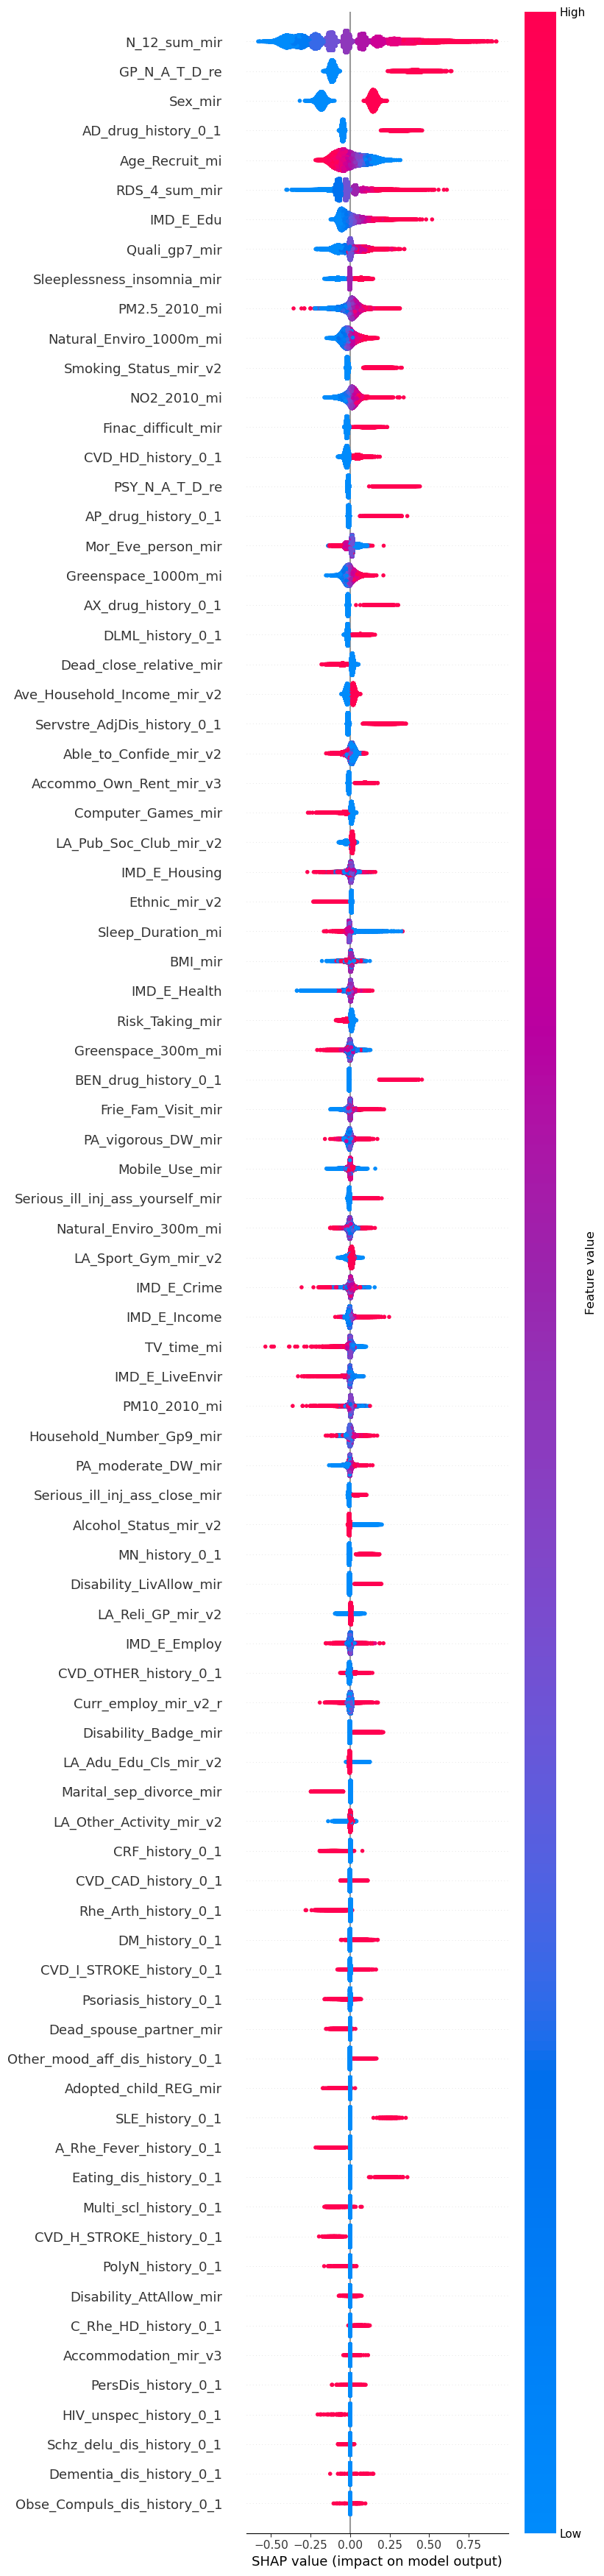

Index(['IMD_E_Income', 'IMD_E_Employ', 'IMD_E_Health', 'IMD_E_Edu',
       'IMD_E_Housing', 'IMD_E_Crime', 'IMD_E_LiveEnvir', 'Age_Recruit_mi',
       'NO2_2010_mi', 'PM10_2010_mi', 'PM2.5_2010_mi', 'Greenspace_1000m_mi',
       'Greenspace_300m_mi', 'Natural_Enviro_1000m_mi',
       'Natural_Enviro_300m_mi', 'TV_time_mi', 'Sleep_Duration_mi',
       'RDS_4_sum_mir', 'N_12_sum_mir', 'PA_moderate_DW_mir',
       'PA_vigorous_DW_mir', 'Mobile_Use_mir', 'Sex_mir', 'BMI_mir',
       'Ethnic_mir_v2', 'Accommodation_mir_v3', 'Accommo_Own_Rent_mir_v3',
       'Household_Number_Gp9_mir', 'Ave_Household_Income_mir_v2',
       'Quali_gp7_mir', 'Curr_employ_mir_v2_r', 'Adopted_child_REG_mir',
       'Serious_ill_inj_ass_yourself_mir', 'Serious_ill_inj_ass_close_mir',
       'Dead_close_relative_mir', 'Dead_spouse_partner_mir',
       'Marital_sep_divorce_mir', 'Finac_difficult_mir',
       'Disability_AttAllow_mir', 'Disability_LivAllow_mir',
       'Disability_Badge_mir', 'Computer_Games_mir', '

In [ ]:

# Function to predict risk, adapted for DataFrame input
def predict_risk(x):
    # Convert DataFrame row to tensor if not already a tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x.values, dtype=torch.float32)
    # Disable gradient calculation
    with torch.no_grad():
        # Ensure output is a numpy array for compatibility with SHAP
        return model.predict(x).cpu().numpy().astype(np.float32)

# Prepare the background data, assuming x_train is a numpy array
# Convert x_train to a DataFrame with appropriate column names
col = ["IMD_E_Income",
                   "IMD_E_Employ",
                   "IMD_E_Health",
                   "IMD_E_Edu",
                   "IMD_E_Housing",
                   "IMD_E_Crime",
                   "IMD_E_LiveEnvir",
    "Age_Recruit_mi", 
    "NO2_2010_mi",
    "PM10_2010_mi",
    "PM2.5_2010_mi", 
    "Greenspace_1000m_mi", 
    "Greenspace_300m_mi", 
    "Natural_Enviro_1000m_mi", 
    "Natural_Enviro_300m_mi", 
    "TV_time_mi", 
    "Sleep_Duration_mi", 
    "RDS_4_sum_mir",
    "N_12_sum_mir",
    "PA_moderate_DW_mir",
    "PA_vigorous_DW_mir",
    "Mobile_Use_mir",
             "Sex_mir",
             "BMI_mir",
    "Ethnic_mir_v2",
    "Accommodation_mir_v3",
    "Accommo_Own_Rent_mir_v3",
    "Household_Number_Gp9_mir",
    "Ave_Household_Income_mir_v2",
    "Quali_gp7_mir",
    "Curr_employ_mir_v2_r",
    "Adopted_child_REG_mir",
    "Serious_ill_inj_ass_yourself_mir",
    "Serious_ill_inj_ass_close_mir",
    "Dead_close_relative_mir",
    "Dead_spouse_partner_mir",
    "Marital_sep_divorce_mir",
    "Finac_difficult_mir",
    "Disability_AttAllow_mir",
    "Disability_LivAllow_mir",
    "Disability_Badge_mir",
    "Computer_Games_mir",
    "Frie_Fam_Visit_mir",
    "Mor_Eve_person_mir",
    "Smoking_Status_mir_v2",
    "Alcohol_Status_mir_v2",
    "LA_Sport_Gym_mir_v2",
    "LA_Pub_Soc_Club_mir_v2",
    "LA_Reli_GP_mir_v2",
    "LA_Adu_Edu_Cls_mir_v2",
    "LA_Other_Activity_mir_v2",
    "Sleeplessness_insomnia_mir",
    "Risk_Taking_mir",
    "Able_to_Confide_mir_v2",
    "Other_mood_aff_dis_history_0_1",
    "Obse_Compuls_dis_history_0_1",
    "Eating_dis_history_0_1",
    "Dementia_dis_history_0_1",
    "Schz_delu_dis_history_0_1",
    "A_Rhe_Fever_history_0_1",
    "C_Rhe_HD_history_0_1",
    "CVD_HD_history_0_1",
    "CVD_CAD_history_0_1",
    "CVD_H_STROKE_history_0_1",
    "CVD_I_STROKE_history_0_1",
    "CVD_OTHER_history_0_1",
    "HIV_unspec_history_0_1",
    "DM_history_0_1",
    "DLML_history_0_1",
    "CRF_history_0_1",
    "Rhe_Arth_history_0_1",
    "SLE_history_0_1",
    "Multi_scl_history_0_1",
    "MN_history_0_1",
    "PolyN_history_0_1",
    "Psoriasis_history_0_1",
     "PersDis_history_0_1",
     "Servstre_AdjDis_history_0_1",
    "AD_drug_history_0_1",
    "AX_drug_history_0_1",
    "AP_drug_history_0_1",
     "BEN_drug_history_0_1",
     "GP_N_A_T_D_re",
      "PSY_N_A_T_D_re",
]

background_df = pd.DataFrame(x_train[:1000000], columns=col)  # Assuming x_train is available

# Initialize the SHAP explainer with appropriate feature names and DataFrame
explainer = shap.Explainer(predict_risk, background_df)

# Compute SHAP values
shap_values = explainer(background_df)

# Plotting SHAP values
shap.summary_plot(shap_values, background_df, max_display=100)

# Print the DataFrame columns
print(background_df.columns)

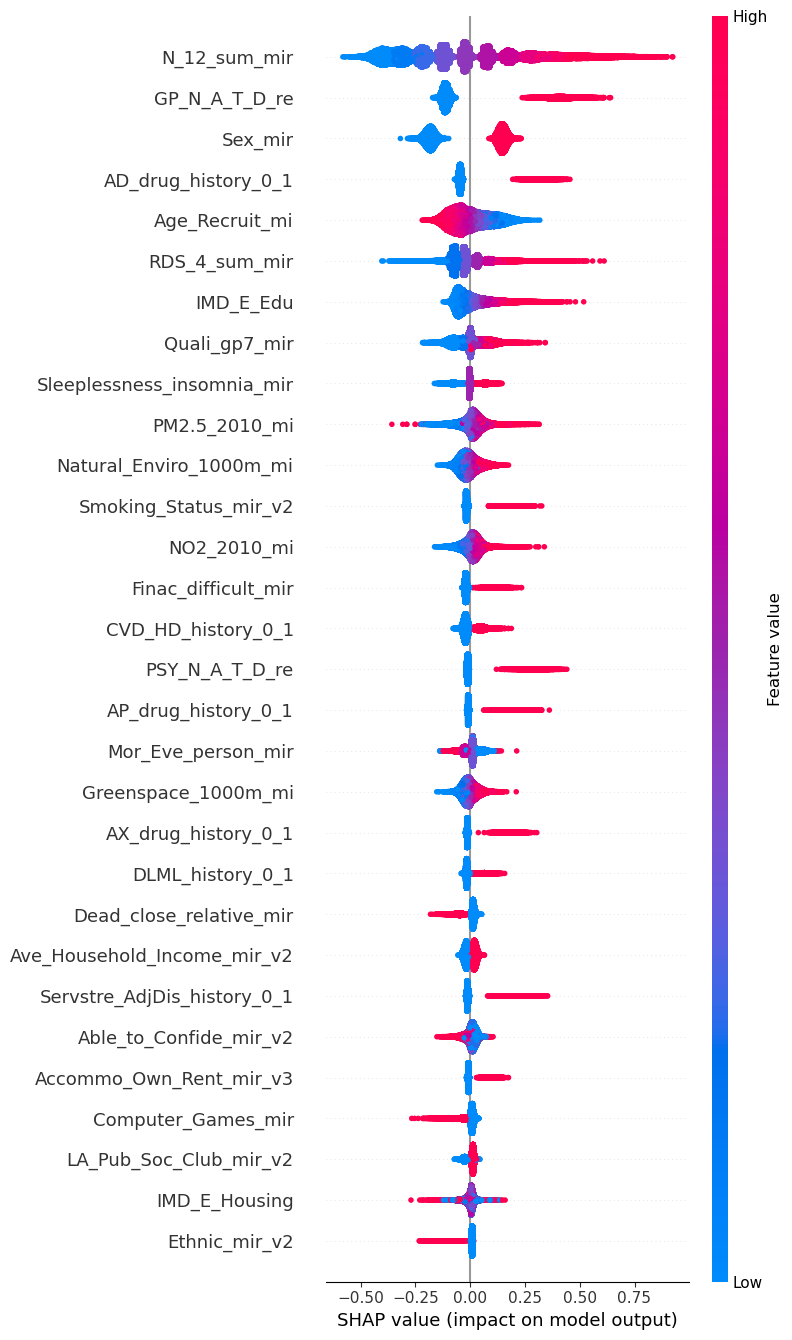

In [14]:
shap.summary_plot (shap_values, background_df, max_display=30)

In [ ]:
### plot SHAP dependence interaction plots ###
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pdf_path = "d:/OneDrive - The Education University of Hong Kong/KITE - WONG, Lam Evon [CPH]'s files/Evon control file/20250214_Anxiety_IMD_shap_dependence_plots_auto_kite_result07_0699.pdf"

variables = ["IMD_E_Income",
                   "IMD_E_Employ",
                   "IMD_E_Health",
                   "IMD_E_Edu",
                   "IMD_E_Housing",
                   "IMD_E_Crime",
                   "IMD_E_LiveEnvir",
    "Age_Recruit_mi", 
    "NO2_2010_mi",
    "PM10_2010_mi",
    "PM2.5_2010_mi", 
    "Greenspace_1000m_mi", 
    "Greenspace_300m_mi", 
    "Natural_Enviro_1000m_mi", 
    "Natural_Enviro_300m_mi", 
    "TV_time_mi", 
    "Sleep_Duration_mi", 
    "RDS_4_sum_mir",
    "N_12_sum_mir",
    "PA_moderate_DW_mir",
    "PA_vigorous_DW_mir",
    "Mobile_Use_mir",
             "Sex_mir",
             "BMI_mir",
    "Ethnic_mir_v2",
    "Accommodation_mir_v3",
    "Accommo_Own_Rent_mir_v3",
    "Household_Number_Gp9_mir",
    "Ave_Household_Income_mir_v2",
    "Quali_gp7_mir",
    "Curr_employ_mir_v2_r",
    "Adopted_child_REG_mir",
    "Serious_ill_inj_ass_yourself_mir",
    "Serious_ill_inj_ass_close_mir",
    "Dead_close_relative_mir",
    "Dead_spouse_partner_mir",
    "Marital_sep_divorce_mir",
    "Finac_difficult_mir",
    "Disability_AttAllow_mir",
    "Disability_LivAllow_mir",
    "Disability_Badge_mir",
    "Computer_Games_mir",
    "Frie_Fam_Visit_mir",
    "Mor_Eve_person_mir",
    "Smoking_Status_mir_v2",
    "Alcohol_Status_mir_v2",
    "LA_Sport_Gym_mir_v2",
    "LA_Pub_Soc_Club_mir_v2",
    "LA_Reli_GP_mir_v2",
    "LA_Adu_Edu_Cls_mir_v2",
    "LA_Other_Activity_mir_v2",
    "Sleeplessness_insomnia_mir",
    "Risk_Taking_mir",
    "Able_to_Confide_mir_v2",
    "Other_mood_aff_dis_history_0_1",
    "Obse_Compuls_dis_history_0_1",
    "Eating_dis_history_0_1",
    "Dementia_dis_history_0_1",
    "Schz_delu_dis_history_0_1",
    "A_Rhe_Fever_history_0_1",
    "C_Rhe_HD_history_0_1",
    "CVD_HD_history_0_1",
    "CVD_CAD_history_0_1",
    "CVD_H_STROKE_history_0_1",
    "CVD_I_STROKE_history_0_1",
    "CVD_OTHER_history_0_1",
    "HIV_unspec_history_0_1",
    "DM_history_0_1",
    "DLML_history_0_1",
    "CRF_history_0_1",
    "Rhe_Arth_history_0_1",
    "SLE_history_0_1",
    "Multi_scl_history_0_1",
    "MN_history_0_1",
    "PolyN_history_0_1",
    "Psoriasis_history_0_1",
     "PersDis_history_0_1",
     "Servstre_AdjDis_history_0_1",
    "AD_drug_history_0_1",
    "AX_drug_history_0_1",
    "AP_drug_history_0_1",
     "BEN_drug_history_0_1",
     "GP_N_A_T_D_re",
      "PSY_N_A_T_D_re",
     ]

with PdfPages(pdf_path) as pdf:
    for var in variables:
        plt.figure(figsize=(8, 6))  # Specify a larger figure size
        shap.dependence_plot(var, shap_values.values, background_df, interaction_index='auto',show=False)
        plt.title(f'SHAP Dependence Plot for {var}')
        plt.tight_layout()  # Adjust layout to fit elements
        pdf.savefig(dpi=600)  # Save the figure into the PDF with 600 dpi
        plt.close()  # Close the figure to free up memory

print(f"All plots saved into a single PDF file at {pdf_path} with 600 dpi.")
print("All plots saved into a single PDF file.")


c:\ProgramData\anaconda3\Lib\site-packages\shap\plots\_scatter.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=figsize)
D:\Temp\ipykernel_25304\172553459.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))  # Specify a larger figure size


All plots saved into a single PDF file at d:/OneDrive - The Education University of Hong Kong/KITE - WONG, Lam Evon [CPH]'s files/Evon control file/20250214_Anxiety_IMD_shap_dependence_plots_auto_kite_result07_0699.pdf with 600 dpi.
All plots saved into a single PDF file.


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

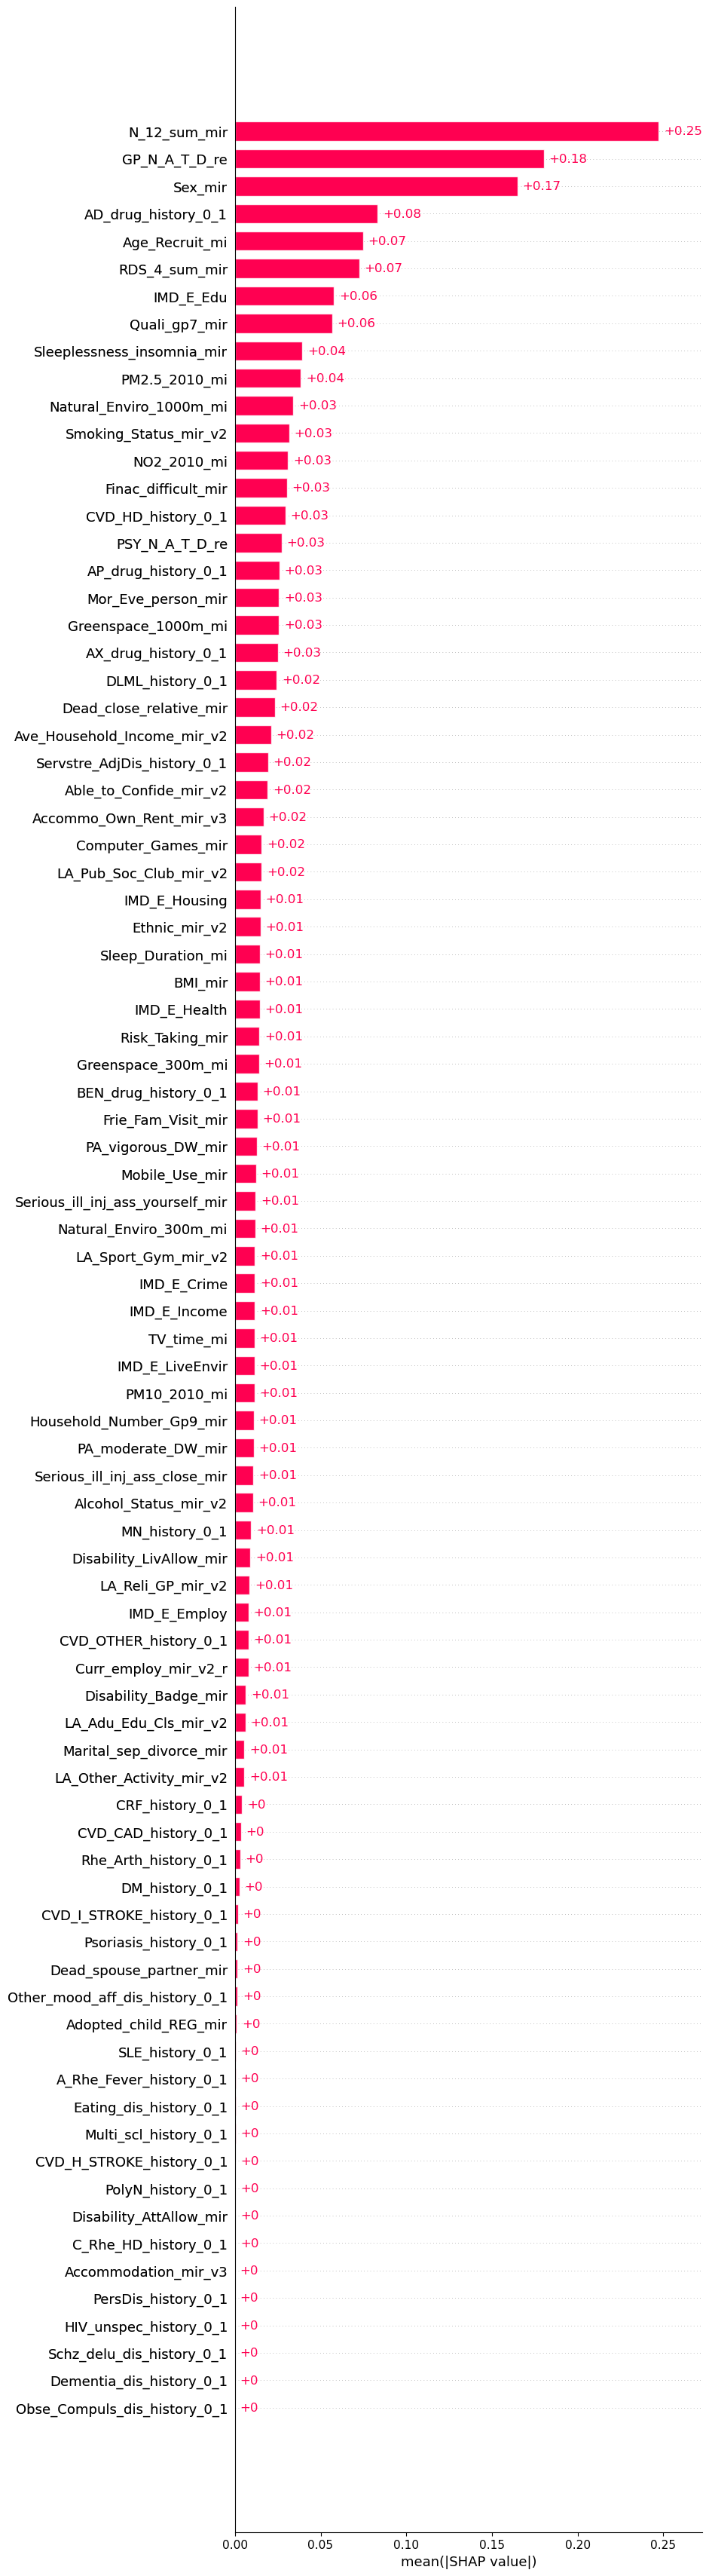

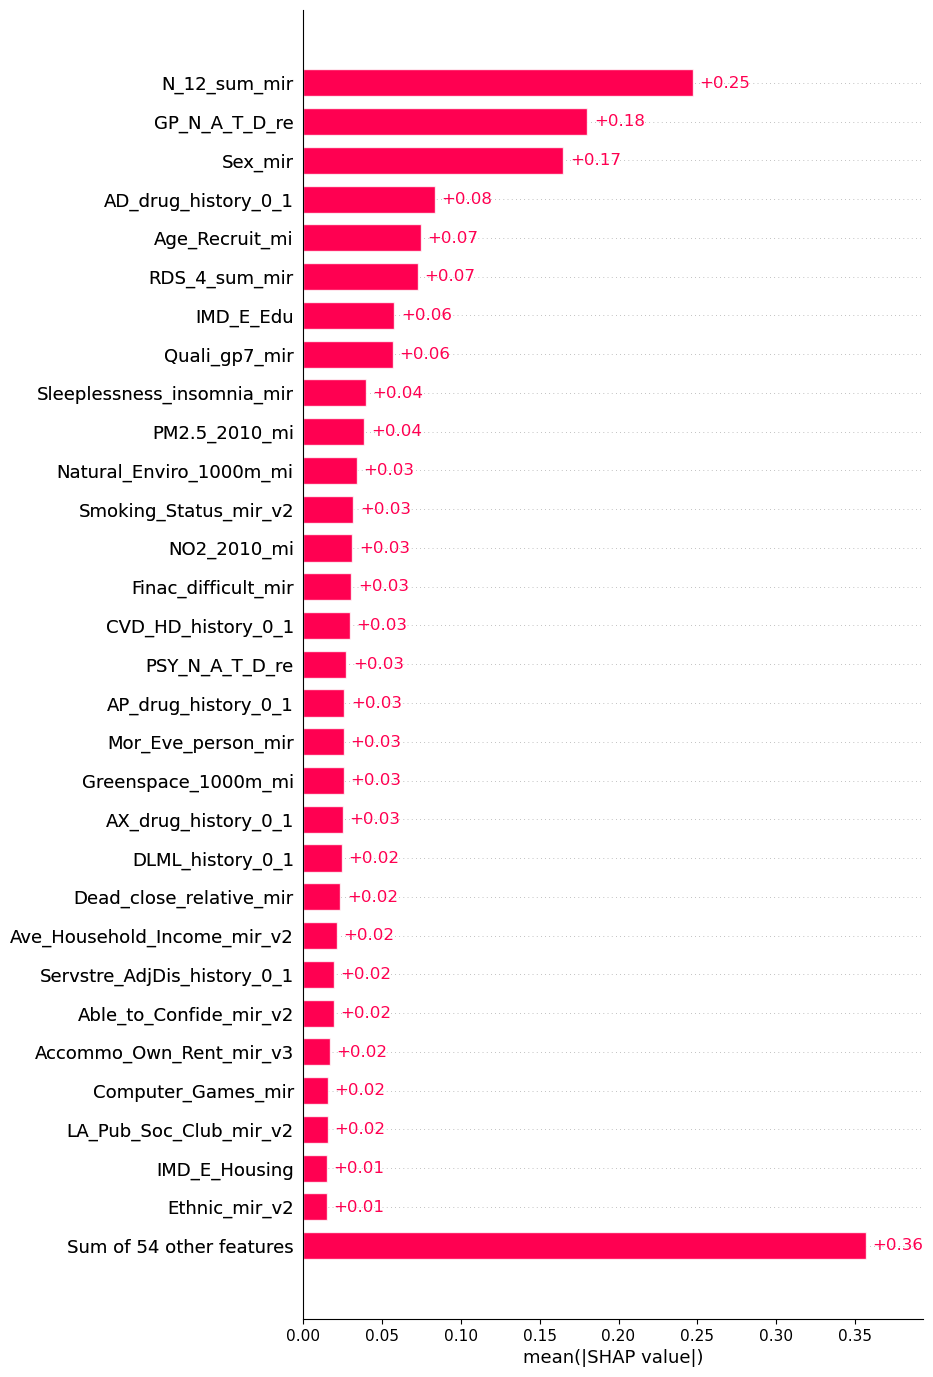

In [17]:
# Plot SHAP absolute mean values including all features and top 30 features
shap.plots.bar(shap_values.abs.mean(0), max_display=len(shap_values.feature_names))
shap.plots.bar(shap_values.abs.mean(0), max_display=31)